In [1]:
# --------------------------------------------------------------
# Cell 1 – Install ALL dependencies (SPACE-SAFE + RESTART)
# --------------------------------------------------------------
import sys
import shlex

def pip_install(package_cmd):
    full_cmd = f'"{sys.executable}" -m pip install {package_cmd} --quiet --no-cache-dir'
    print(f"> {full_cmd}")
    get_ipython().system(full_cmd)

print("Upgrading pip...")
pip_install("--upgrade pip")

print("Installing core packages...")
pip_install("numpy pandas scikit-learn matplotlib seaborn tqdm")

print("Installing PyTorch with CUDA...")
pip_install("--index-url https://download.pytorch.org/whl/cu121 torch torchvision torchaudio")

print("Installing HuggingFace...")
pip_install("transformers datasets accelerate")

print("Installing privacy & text...")
pip_install("opacus nltk")

print("Installing XAI...")
pip_install("captum lime shap")

print("Installing encryption & PDF...")
pip_install("pycryptodome reportlab")

print("\nALL DONE! NOW:")
print("1. RESTART KERNEL")
print("2. Run Cell 2+")

Upgrading pip...
> "e:\Bubt task\Ml-Project(new)\venv\Scripts\python.exe" -m pip install --upgrade pip --quiet --no-cache-dir
Installing core packages...
> "e:\Bubt task\Ml-Project(new)\venv\Scripts\python.exe" -m pip install numpy pandas scikit-learn matplotlib seaborn tqdm --quiet --no-cache-dir
Installing PyTorch with CUDA...
> "e:\Bubt task\Ml-Project(new)\venv\Scripts\python.exe" -m pip install --index-url https://download.pytorch.org/whl/cu121 torch torchvision torchaudio --quiet --no-cache-dir
Installing HuggingFace...
> "e:\Bubt task\Ml-Project(new)\venv\Scripts\python.exe" -m pip install transformers datasets accelerate --quiet --no-cache-dir
Installing privacy & text...
> "e:\Bubt task\Ml-Project(new)\venv\Scripts\python.exe" -m pip install opacus nltk --quiet --no-cache-dir
Installing XAI...
> "e:\Bubt task\Ml-Project(new)\venv\Scripts\python.exe" -m pip install captum lime shap --quiet --no-cache-dir
Installing encryption & PDF...
> "e:\Bubt task\Ml-Project(new)\venv\Script

In [2]:
# CELL 1 – INSTALL (run & restart kernel)
!pip install torch transformers tqdm scikit-learn pycryptodome matplotlib seaborn pandas

In [1]:
import torch
from torch.utils.data import DataLoader, Subset
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

e:\Bubt task\Ml-Project(new)\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --------------------------------------------------------------
# Cell 1 – Imports & GPU check
# --------------------------------------------------------------
import os, json, random, time, warnings, string, re
from datetime import datetime
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (accuracy_score, f1_score,
                             confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, auc,
                             precision_recall_curve)
from sklearn.preprocessing import LabelEncoder

from transformers import (BertTokenizer, BertForSequenceClassification,
                          get_linear_schedule_with_warmup)

from datasets import load_dataset
from tqdm.auto import tqdm

# XAI
from captum.attr import IntegratedGradients
import lime.lime_text
import shap

# Encryption
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from Crypto.Util.Padding import pad, unpad

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
seed_all()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {DEVICE}")
print(f"GPU name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'N/A'}")

Using cuda
GPU name: NVIDIA GeForce RTX 4060


In [3]:
# Cell 2.0 – Imports & GPU Check
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0)}")

CUDA available: True
GPU: NVIDIA GeForce RTX 4060


In [3]:
# --------------------------------------------------------------
# Cell 2 – Text cleaning
# --------------------------------------------------------------
def clean_text(t):
    if pd.isna(t): return ""
    t = str(t).lower()
    t = re.sub(r'http\S+|www\S+|https\S+', '', t, flags=re.MULTILINE)
    t = re.sub(r'<.*?>', '', t)
    t = re.sub(r'[^a-zA-Z\s]', '', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t

In [4]:
# --------------------------------------------------------------
# Cell: Create 'data' folder
# --------------------------------------------------------------
import os
os.makedirs('data', exist_ok=True)
print("Created folder: data")

Created folder: data


In [5]:
# --------------------------------------------------------------
# Cell: Create my_reviews.csv with 500 rows
# --------------------------------------------------------------
import pandas as pd
import numpy as np

# 250 positive + 250 negative = 500 rows
pos_phrases = [
    "I love this!", "Amazing!", "Best ever!", "Highly recommend!", "Perfect!",
    "Excellent!", "So happy!", "Great!", "Fantastic!", "Worth it!"
]
neg_phrases = [
    "Terrible!", "Waste of money!", "Disappointing!", "Poor quality!", "Never again!",
    "Bad service!", "Hated it!", "Not worth it!", "Broken!", "Misleading!"
]

# Repeat to reach 250 each
texts = (pos_phrases * 25) + (neg_phrases * 25)
labels = [1] * 250 + [0] * 250

# Shuffle
combined = list(zip(texts, labels))
np.random.seed(42)
np.random.shuffle(combined)
texts, labels = zip(*combined)

# Save
df = pd.DataFrame({'review': texts, 'sentiment': labels})
df.to_csv('data/my_reviews.csv', index=False)
print(f"Created data/my_reviews.csv with {len(df)} rows")
print("First 5 rows:")
print(df.head())

Created data/my_reviews.csv with 500 rows
First 5 rows:
              review  sentiment
0    Waste of money!          0
1  Highly recommend!          1
2       Never again!          0
3         Excellent!          1
4           Perfect!          1


Twitter: 7093 Neg, 17849 Pos available
Added 500 custom rows (250+250)
Raw merged: 55593 rows
After cleaning: 55593 rows
Before final: Neg=27343, Pos=28250

BALANCED DATASET SAVED: data/merged_dataset_balanced.csv


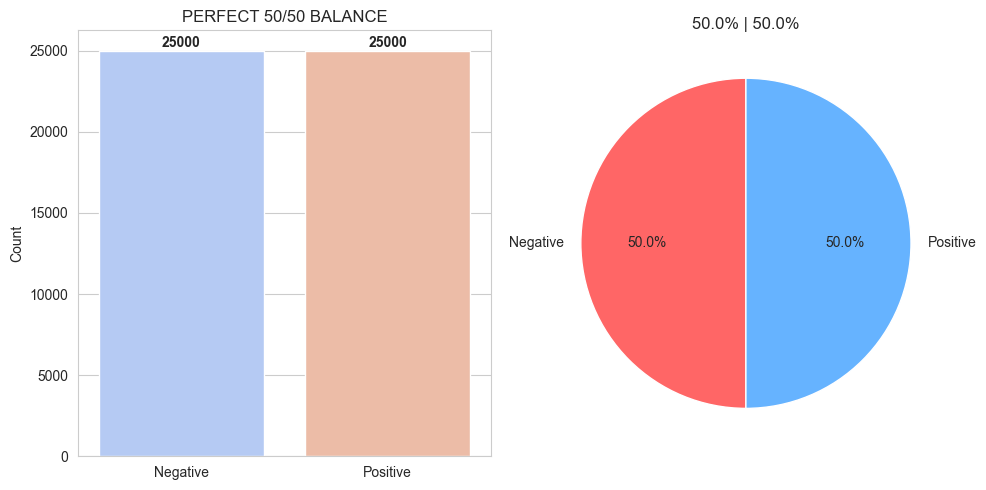


FINAL: 50000 rows → 25,000 Negative + 25,000 Positive
First 10 rows:


,review,sentiment
0,user oh let me know if you hear about whats on...,1
1,after receiving a ridiculously rude private me...,0
2,getting lost in space frozen for years thats u...,0
3,this was shown as part of the th edinburgh int...,0
4,one of my collegue have been raving about oreg...,1
5,theo robertson has commented that waw didnt ad...,1
6,i saw this in a sneak two days before the offi...,0
7,this is a place for really good middle eastern...,1
8,birkenstocks with socks straw hats cargo short...,0
9,just realized i hadnt written a review about t...,1


In [6]:
# --------------------------------------------------------------
# Cell 3 – ROBUST 50/50 BALANCED DATASET (25k + 25k = 50k)
# --------------------------------------------------------------
def load_and_merge_datasets(my_csv_path='data/my_reviews.csv',
                            target_total=50_000,
                            custom_ratio=0.01):  # 500 rows
    dfs = []

    # ---- 1. Load public datasets ----
    print("Downloading IMDB...")
    imdb = load_dataset('imdb', split='train')

    print("Downloading Yelp...")
    yelp = load_dataset('yelp_review_full', split='train')

    print("Downloading Twitter...")
    twitter_raw = load_dataset("cardiffnlp/tweet_eval", name="sentiment", split="train")
    twitter = twitter_raw.filter(lambda x: x['label'] != 1)
    twitter = twitter.map(lambda x: {'text': x['text'], 'label': 0 if x['label'] == 0 else 1})

    # ---- 2. Final target per class ----
    final_per_class = target_total // 2  # 25,000
    custom_per_class = 250  # 250 neg + 250 pos = 500

    # ---- 3. IMDB: 50/50 (large enough) ----
    df_imdb = pd.DataFrame({'review': imdb['text'], 'sentiment': imdb['label']})
    imdb_neg = df_imdb[df_imdb['sentiment'] == 0].sample(min(10000, len(df_imdb[df_imdb['sentiment'] == 0])), random_state=42)
    imdb_pos = df_imdb[df_imdb['sentiment'] == 1].sample(min(10000, len(df_imdb[df_imdb['sentiment'] == 1])), random_state=42)
    dfs.append(pd.concat([imdb_neg, imdb_pos]))

    # ---- 4. Yelp: 50/50 (map 0,1→0; 2,3,4→1) ----
    df_yelp = pd.DataFrame({'review': yelp['text'], 'sentiment': yelp['label']})
    df_yelp['sentiment'] = df_yelp['sentiment'].map(lambda x: 0 if x in [0,1] else 1)
    yelp_neg = df_yelp[df_yelp['sentiment'] == 0].sample(min(10000, len(df_yelp[df_yelp['sentiment'] == 0])), random_state=42)
    yelp_pos = df_yelp[df_yelp['sentiment'] == 1].sample(min(10000, len(df_yelp[df_yelp['sentiment'] == 1])), random_state=42)
    dfs.append(pd.concat([yelp_neg, yelp_pos]))

    # ---- 5. Twitter: Take ALL available (safe) ----
    df_tw = pd.DataFrame({'review': twitter['text'], 'sentiment': twitter['label']})
    tw_neg_count = len(df_tw[df_tw['sentiment'] == 0])
    tw_pos_count = len(df_tw[df_tw['sentiment'] == 1])
    print(f"Twitter: {tw_neg_count} Neg, {tw_pos_count} Pos available")
    tw_neg = df_tw[df_tw['sentiment'] == 0].sample(min(tw_neg_count, 8000), random_state=42)
    tw_pos = df_tw[df_tw['sentiment'] == 1].sample(min(tw_pos_count, 8000), random_state=42)
    dfs.append(pd.concat([tw_neg, tw_pos]))

    # ---- 6. Custom: 250 + 250 ----
    if not os.path.exists(my_csv_path):
        raise FileNotFoundError(f"{my_csv_path} not found!")
    my = pd.read_csv(my_csv_path, usecols=['review','sentiment'])
    my_neg = my[my['sentiment'] == 0].sample(250, random_state=42)
    my_pos = my[my['sentiment'] == 1].sample(250, random_state=42)
    dfs.append(pd.concat([my_neg, my_pos]))
    print(f"Added 500 custom rows (250+250)")

    # ---- 7. Merge & clean ----
    full = pd.concat(dfs, ignore_index=True)
    print(f"Raw merged: {len(full)} rows")

    full['review'] = full['review'].apply(clean_text)
    full = full[full['review'].str.len() > 0].reset_index(drop=True)
    print(f"After cleaning: {len(full)} rows")

    # ---- 8. FINAL 50/50: 25k + 25k ----
    neg = full[full['sentiment'] == 0]
    pos = full[full['sentiment'] == 1]

    print(f"Before final: Neg={len(neg)}, Pos={len(pos)}")

    final_neg = neg.sample(final_per_class, replace=True, random_state=42) if len(neg) < final_per_class else neg.sample(final_per_class, random_state=42)
    final_pos = pos.sample(final_per_class, replace=True, random_state=42) if len(pos) < final_per_class else pos.sample(final_per_class, random_state=42)

    df_final = pd.concat([final_neg, final_pos]).sample(frac=1, random_state=42).reset_index(drop=True)

    return df_final

# ----------------------------------------------------------------
# RUN + SAVE + PLOT
# ----------------------------------------------------------------
df_all = load_and_merge_datasets()

# ---- SAVE ----
save_path = 'data/merged_dataset_balanced.csv'
df_all[['review', 'sentiment']].to_csv(save_path, index=False)
print(f"\nBALANCED DATASET SAVED: {save_path}")

# ---- PLOT ----
import matplotlib.pyplot as plt
import seaborn as sns

counts = df_all['sentiment'].value_counts().sort_index()
labels = ['Negative', 'Positive']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=labels, y=counts.values, palette='coolwarm')
plt.title('PERFECT 50/50 BALANCE')
plt.ylabel('Count')
for i, v in enumerate(counts.values):
    plt.text(i, v + 200, str(v), ha='center', fontweight='bold')

plt.subplot(1, 2, 2)
plt.pie(counts.values, labels=labels, autopct='%1.1f%%', colors=['#ff6666', '#66b3ff'], startangle=90)
plt.title('50.0% | 50.0%')

plt.tight_layout()
plt.show()

print(f"\nFINAL: {len(df_all)} rows → 25,000 Negative + 25,000 Positive")
print("First 10 rows:")
display(df_all[['review', 'sentiment']].head(10))

In [7]:
# Cell 4 – Train / Val / Test split
y = df_all['sentiment'].values
X_idx = np.arange(len(df_all))

train_idx, temp_idx = train_test_split(X_idx, test_size=0.30, stratify=y, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.50, stratify=y[temp_idx], random_state=42)

train_df = df_all.iloc[train_idx].reset_index(drop=True)
val_df   = df_all.iloc[val_idx].reset_index(drop=True)
test_df  = df_all.iloc[test_idx].reset_index(drop=True)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 35000 | Val: 7500 | Test: 7500


In [9]:
train_df.value_counts('sentiment')

sentiment
0    17500
1    17500
Name: count, dtype: int64

In [9]:
# --------------------------------------------------------------
# Cell 5 – Tokenization + Safe Dataset
# --------------------------------------------------------------
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_batch(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='pt')

print("Tokenizing...")
tokenized_train = tokenize_batch(train_df['review'].tolist())
tokenized_val   = tokenize_batch(val_df['review'].tolist())
tokenized_test  = tokenize_batch(test_df['review'].tolist())

class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = list(labels)
    def __getitem__(self, idx):
        item = {k: v[idx].clone().detach() for k,v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
    def __len__(self): return len(self.labels)

train_ds = ReviewDataset(tokenized_train, train_df['sentiment'].values)
val_ds   = ReviewDataset(tokenized_val,   val_df['sentiment'].values)
test_ds  = ReviewDataset(tokenized_test,  test_df['sentiment'].values)

test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)
print(f"Ready → Train:{len(train_ds)} Val:{len(val_ds)} Test:{len(test_ds)}")

Tokenizing...
Ready → Train:35000 Val:7500 Test:7500


In [10]:
# --------------------------------------------------------------
# Cell 6 – Model Definition (with Warning Suppression)
# --------------------------------------------------------------
import logging
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

def get_model():
    return BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,
        problem_type="single_label_classification",
        ignore_mismatched_sizes=True
    ).to(DEVICE)

In [11]:
# --------------------------------------------------------------
# Cell 7 – Encryption / Decryption (Weight Delta Only)
# --------------------------------------------------------------
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
import io
import torch

def encrypt_state(delta_dict, key):
    buffer = io.BytesIO()
    torch.save(delta_dict, buffer)
    data = buffer.getvalue()
    buffer.close()

    cipher = AES.new(key, AES.MODE_GCM)
    ciphertext, tag = cipher.encrypt_and_digest(pad(data, AES.block_size))
    
    return {
        'ciphertext': ciphertext,
        'nonce': cipher.nonce,
        'tag': tag
    }

def decrypt_state(enc, key):
    cipher = AES.new(key, AES.MODE_GCM, nonce=enc['nonce'])
    plaintext = cipher.decrypt(enc['ciphertext'])
    cipher.verify(enc['tag'])
    plaintext = unpad(plaintext, AES.block_size)
    
    buffer = io.BytesIO(plaintext)
    delta_dict = torch.load(buffer, map_location='cpu')
    buffer.close()
    return delta_dict

In [12]:
!pip install functorch

  Using cached functorch-2.0.0-py2.py3-none-any.whl.metadata (346 bytes)
INFO: pip is looking at multiple versions of functorch to determine which version is compatible with other requirements. This could take a while.
  Using cached functorch-1.13.1-py2.py3-none-any.whl.metadata (353 bytes)
  Using cached functorch-1.13.0-py2.py3-none-any.whl.metadata (353 bytes)

The conflict is caused by:
    functorch 2.0.0 depends on torch<2.1 and >=2.0
    functorch 1.13.1 depends on torch<1.13.2 and >=1.13.1
    functorch 1.13.0 depends on torch<1.13.1 and >=1.13.0

Additionally, some packages in these conflicts have no matching distributions available for your environment:
    torch

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip to attempt to solve the dependency conflict



ERROR: Cannot install functorch==1.13.0, functorch==1.13.1 and functorch==2.0.0 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [13]:
!pip install opacus==1.0.2 

In [14]:
# --------------------------------------------------------------
# CELL 8 – ClientSimulator + LocalTrainer (PATE: Teachers = No DP)
# --------------------------------------------------------------
from torch.utils.data import DataLoader, Subset
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import torch

# ==============================================================
# 1. CLIENT SIMULATOR (unchanged)
# ==============================================================
class ClientSimulator:
    def __init__(self, n_clients, seed=42):
        self.n_clients = n_clients
        self.seed = seed
        torch.manual_seed(seed)

    def split(self, dataset):
        n = len(dataset)
        indices = torch.randperm(n).tolist()
        base = n // self.n_clients
        rem = n % self.n_clients
        clients = []
        start = 0
        for i in range(self.n_clients):
            extra = 1 if i < rem else 0
            size = base + extra
            end = start + size
            clients.append({
                'id': i,
                'dataset': Subset(dataset, indices[start:end]),
                'size': size
            })
            start = end
        print(f"  [Split] {n} samples → {self.n_clients} clients")
        for c in clients:
            print(f"    Client {c['id']}: {c['size']} samples")
        return clients


# ==============================================================
# 2. LOCAL TRAINER (TEACHERS: NO DP-SGD → High Accuracy)
# ==============================================================
class LocalTrainer:
    def __init__(self, lr, epochs, batch):
        self.lr = lr
        self.epochs = epochs
        self.batch = batch

    def train(self, client_id, client_ds, global_state, round_key):
        model = get_model()
        model.load_state_dict(global_state)
        model.train()
        model.to(DEVICE)

        loader = DataLoader(client_ds, batch_size=self.batch, shuffle=True)
        opt = AdamW(model.parameters(), lr=self.lr, weight_decay=0.01)

        total_steps = len(loader) * self.epochs
        scheduler = get_linear_schedule_with_warmup(
            opt,
            num_warmup_steps=int(0.1 * total_steps),
            num_training_steps=total_steps
        )

        print(f"  [Teacher {client_id}] Training {len(client_ds)} samples → {self.epochs} epochs")
        pbar = tqdm(total=total_steps, desc=f"  T{client_id}", leave=False)

        for epoch in range(self.epochs):
            epoch_loss = 0.0
            for batch in loader:
                opt.zero_grad()

                out = model(
                    input_ids=batch['input_ids'].to(DEVICE),
                    attention_mask=batch['attention_mask'].to(DEVICE),
                    labels=batch['labels'].to(DEVICE)
                )

                loss = out.loss
                loss.backward()
                epoch_loss += loss.item()

                opt.step()
                scheduler.step()
                pbar.update(1)

            avg_loss = epoch_loss / len(loader)
            print(f"    → Teacher {client_id} Epoch {epoch+1}/{self.epochs} Loss: {avg_loss:.4f}")

        pbar.close()

        # Return encrypted model delta
        delta = {k: model.state_dict()[k] - global_state[k] for k in global_state}
        return encrypt_state(delta, round_key)

In [15]:
# --------------------------------------------------------------
# CELL 9 – Helper Functions (FIXED federated_average)
# --------------------------------------------------------------
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import f1_score

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_model():
    from transformers import AutoModelForSequenceClassification
    return AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", num_labels=2
    ).to(DEVICE)

# FIXED: Works with your AES-GCM dict
def federated_average(cipher_updates, round_key, client_sizes, global_state):
    total_size = sum(client_sizes)
    decrypted_deltas = []

    for enc in cipher_updates:
        delta = decrypt_state(enc, round_key)
        # Ensure all keys exist and match shape
        full_delta = {}
        for k in global_state.keys():
            if k in delta:
                expected = global_state[k].shape
                full_delta[k] = delta[k].reshape(expected).to(DEVICE)
            else:
                full_delta[k] = torch.zeros_like(global_state[k])
        decrypted_deltas.append(full_delta)

    # Weighted average
    avg_delta = {}
    for k in global_state.keys():
        weighted = sum(
            decrypted_deltas[i][k] * client_sizes[i] for i in range(len(decrypted_deltas))
        )
        avg_delta[k] = weighted / total_size

    # Update global model
    new_global = {k: global_state[k] + avg_delta[k] for k in global_state}
    return new_global

def evaluate(state_dict, loader):
    model = get_model()
    model.load_state_dict(state_dict)
    model.eval()
    correct = total = 0
    all_preds = all_labels = []
    with torch.no_grad():
        for batch in loader:
            out = model(
                input_ids=batch['input_ids'].to(DEVICE),
                attention_mask=batch['attention_mask'].to(DEVICE)
            )
            preds = out.logits.argmax(dim=-1)
            correct += (preds == batch['labels'].to(DEVICE)).sum().item()
            total += batch['labels'].size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].numpy())
    return {
        'acc': correct / total,
        'f1': f1_score(all_labels, all_preds, average='macro')
    }

def get_random_bytes(n):
    import os
    return os.urandom(n)

In [16]:
# === LOAD BEST HYPERPARAMETERS (NO TUNING) ===
import json
import os

HP_FILE = "best_hp.json"
if not os.path.exists(HP_FILE):
    raise FileNotFoundError(f"ERROR: {HP_FILE} not found! Place it in the same folder as the notebook.")

with open(HP_FILE) as f:
    HP = json.load(f)

print("BEST HYPERPARAMETERS LOADED:")
for k, v in HP.items():
    print(f"  {k}: {v}")

# Optional: Reduce for quick test
# HP['rounds'] = 1
# HP['clients'] = 2
# HP['local_epochs'] = 1

BEST HYPERPARAMETERS LOADED:
  lr: 1e-05
  batch: 8
  rounds: 8
  clients: 3
  local_epochs: 8


No saved HP found → STARTING TUNING WITH EPOCH LOGS...

Testing Config: {'lr': 1e-05, 'batch': 8, 'rounds': 8, 'clients': 3, 'local_epochs': 3}


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:44<03:05, 10.47it/s]

    → Client 0 Epoch 1/3 Loss: 0.4592


  C0:  67%|██████▋   | 1947/2919 [03:29<01:31, 10.58it/s]

    → Client 0 Epoch 2/3 Loss: 0.2485


    → Client 0 Epoch 3/3 Loss: 0.1433


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:44<03:02, 10.63it/s]

    → Client 1 Epoch 1/3 Loss: 0.4572


  C1:  67%|██████▋   | 1947/2919 [03:29<01:32, 10.56it/s]

    → Client 1 Epoch 2/3 Loss: 0.2487


    → Client 1 Epoch 3/3 Loss: 0.1444


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:44<03:10, 10.24it/s]

    → Client 2 Epoch 1/3 Loss: 0.4524


  C2:  67%|██████▋   | 1947/2919 [03:29<01:35, 10.19it/s]

    → Client 2 Epoch 2/3 Loss: 0.2357


    → Client 2 Epoch 3/3 Loss: 0.1309


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:45<03:03, 10.60it/s]

    → Client 0 Epoch 1/3 Loss: 0.2540


  C0:  67%|██████▋   | 1947/2919 [03:30<01:32, 10.54it/s]

    → Client 0 Epoch 2/3 Loss: 0.1509


    → Client 0 Epoch 3/3 Loss: 0.0708


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:44<03:04, 10.54it/s]

    → Client 1 Epoch 1/3 Loss: 0.2577


  C1:  67%|██████▋   | 1947/2919 [03:29<01:31, 10.66it/s]

    → Client 1 Epoch 2/3 Loss: 0.1511


    → Client 1 Epoch 3/3 Loss: 0.0767


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:45<03:12, 10.10it/s]

    → Client 2 Epoch 1/3 Loss: 0.2479


  C2:  67%|██████▋   | 1947/2919 [03:30<01:35, 10.16it/s]

    → Client 2 Epoch 2/3 Loss: 0.1377


    → Client 2 Epoch 3/3 Loss: 0.0661


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 2 Val Acc: 0.8743


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:45<03:03, 10.63it/s]

    → Client 0 Epoch 1/3 Loss: 0.1775


  C0:  67%|██████▋   | 1947/2919 [03:30<01:32, 10.54it/s]

    → Client 0 Epoch 2/3 Loss: 0.0931


    → Client 0 Epoch 3/3 Loss: 0.0439


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:45<03:06, 10.42it/s]

    → Client 1 Epoch 1/3 Loss: 0.1896


  C1:  67%|██████▋   | 1947/2919 [03:30<01:32, 10.56it/s]

    → Client 1 Epoch 2/3 Loss: 0.0959


    → Client 1 Epoch 3/3 Loss: 0.0492


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:45<03:13, 10.06it/s]

    → Client 2 Epoch 1/3 Loss: 0.1670


  C2:  67%|██████▋   | 1947/2919 [03:30<01:36, 10.04it/s]

    → Client 2 Epoch 2/3 Loss: 0.0831


    → Client 2 Epoch 3/3 Loss: 0.0424


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:45<03:03, 10.61it/s]

    → Client 0 Epoch 1/3 Loss: 0.1204


  C0:  67%|██████▋   | 1947/2919 [03:29<01:32, 10.56it/s]

    → Client 0 Epoch 2/3 Loss: 0.0574


    → Client 0 Epoch 3/3 Loss: 0.0316


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:44<03:03, 10.59it/s]

    → Client 1 Epoch 1/3 Loss: 0.1287


  C1:  67%|██████▋   | 1947/2919 [03:29<01:32, 10.48it/s]

    → Client 1 Epoch 2/3 Loss: 0.0663


    → Client 1 Epoch 3/3 Loss: 0.0302


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:44<03:10, 10.22it/s]

    → Client 2 Epoch 1/3 Loss: 0.1158


  C2:  67%|██████▋   | 1947/2919 [03:29<01:35, 10.17it/s]

    → Client 2 Epoch 2/3 Loss: 0.0564


    → Client 2 Epoch 3/3 Loss: 0.0237


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 4 Val Acc: 0.8737


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:45<03:03, 10.60it/s]

    → Client 0 Epoch 1/3 Loss: 0.0901


  C0:  67%|██████▋   | 1947/2919 [03:30<01:32, 10.54it/s]

    → Client 0 Epoch 2/3 Loss: 0.0420


    → Client 0 Epoch 3/3 Loss: 0.0209


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:45<03:04, 10.53it/s]

    → Client 1 Epoch 1/3 Loss: 0.0862


  C1:  67%|██████▋   | 1947/2919 [03:30<01:32, 10.50it/s]

    → Client 1 Epoch 2/3 Loss: 0.0488


    → Client 1 Epoch 3/3 Loss: 0.0229


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:44<03:11, 10.18it/s]

    → Client 2 Epoch 1/3 Loss: 0.0800


  C2:  67%|██████▋   | 1947/2919 [03:29<01:35, 10.14it/s]

    → Client 2 Epoch 2/3 Loss: 0.0380


    → Client 2 Epoch 3/3 Loss: 0.0132


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:44<03:02, 10.65it/s]

    → Client 0 Epoch 1/3 Loss: 0.0618


  C0:  67%|██████▋   | 1947/2919 [03:29<01:31, 10.63it/s]

    → Client 0 Epoch 2/3 Loss: 0.0349


    → Client 0 Epoch 3/3 Loss: 0.0168


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:44<03:03, 10.60it/s]

    → Client 1 Epoch 1/3 Loss: 0.0582


  C1:  67%|██████▋   | 1947/2919 [03:29<01:32, 10.55it/s]

    → Client 1 Epoch 2/3 Loss: 0.0384


    → Client 1 Epoch 3/3 Loss: 0.0205


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:44<03:11, 10.18it/s]

    → Client 2 Epoch 1/3 Loss: 0.0519


  C2:  67%|██████▋   | 1947/2919 [03:29<01:35, 10.15it/s]

    → Client 2 Epoch 2/3 Loss: 0.0274


    → Client 2 Epoch 3/3 Loss: 0.0154


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 6 Val Acc: 0.8718


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:44<03:05, 10.51it/s]

    → Client 0 Epoch 1/3 Loss: 0.0419


  C0:  67%|██████▋   | 1947/2919 [03:29<01:31, 10.65it/s]

    → Client 0 Epoch 2/3 Loss: 0.0301


    → Client 0 Epoch 3/3 Loss: 0.0130


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:44<03:02, 10.65it/s]

    → Client 1 Epoch 1/3 Loss: 0.0456


  C1:  67%|██████▋   | 1947/2919 [03:29<01:31, 10.65it/s]

    → Client 1 Epoch 2/3 Loss: 0.0245


    → Client 1 Epoch 3/3 Loss: 0.0208


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:44<03:12, 10.08it/s]

    → Client 2 Epoch 1/3 Loss: 0.0443


  C2:  67%|██████▋   | 1947/2919 [03:29<01:35, 10.18it/s]

    → Client 2 Epoch 2/3 Loss: 0.0208


    → Client 2 Epoch 3/3 Loss: 0.0099


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:44<03:03, 10.60it/s]

    → Client 0 Epoch 1/3 Loss: 0.0381


  C0:  67%|██████▋   | 1947/2919 [03:29<01:32, 10.48it/s]

    → Client 0 Epoch 2/3 Loss: 0.0186


    → Client 0 Epoch 3/3 Loss: 0.0094


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:44<03:03, 10.59it/s]

    → Client 1 Epoch 1/3 Loss: 0.0341


  C1:  67%|██████▋   | 1947/2919 [03:29<01:31, 10.64it/s]

    → Client 1 Epoch 2/3 Loss: 0.0226


    → Client 1 Epoch 3/3 Loss: 0.0116


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:44<03:12, 10.10it/s]

    → Client 2 Epoch 1/3 Loss: 0.0326


  C2:  67%|██████▋   | 1947/2919 [03:29<01:36, 10.12it/s]

    → Client 2 Epoch 2/3 Loss: 0.0182


    → Client 2 Epoch 3/3 Loss: 0.0109


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 8 Val Acc: 0.8716

Testing Config: {'lr': 1e-05, 'batch': 8, 'rounds': 8, 'clients': 3, 'local_epochs': 4}


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:44<04:32, 10.70it/s]

    → Client 0 Epoch 1/4 Loss: 0.4543


  C0:  50%|█████     | 1947/3892 [03:29<03:01, 10.69it/s]

    → Client 0 Epoch 2/4 Loss: 0.2515


  C0:  75%|███████▌  | 2920/3892 [05:14<01:32, 10.49it/s]

    → Client 0 Epoch 3/4 Loss: 0.1390


    → Client 0 Epoch 4/4 Loss: 0.0749


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:44<04:33, 10.65it/s]

    → Client 1 Epoch 1/4 Loss: 0.4561


  C1:  50%|█████     | 1947/3892 [03:29<03:02, 10.65it/s]

    → Client 1 Epoch 2/4 Loss: 0.2441


  C1:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.62it/s]

    → Client 1 Epoch 3/4 Loss: 0.1313


    → Client 1 Epoch 4/4 Loss: 0.0746


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:44<04:45, 10.21it/s]

    → Client 2 Epoch 1/4 Loss: 0.4496


  C2:  50%|█████     | 1947/3892 [03:29<03:10, 10.20it/s]

    → Client 2 Epoch 2/4 Loss: 0.2377


  C2:  75%|███████▌  | 2920/3892 [05:14<01:35, 10.16it/s]

    → Client 2 Epoch 3/4 Loss: 0.1309


    → Client 2 Epoch 4/4 Loss: 0.0661


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:44<04:34, 10.63it/s]

    → Client 0 Epoch 1/4 Loss: 0.2321


  C0:  50%|█████     | 1947/3892 [03:29<03:01, 10.71it/s]

    → Client 0 Epoch 2/4 Loss: 0.1364


  C0:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.61it/s]

    → Client 0 Epoch 3/4 Loss: 0.0607


    → Client 0 Epoch 4/4 Loss: 0.0323


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:44<04:33, 10.66it/s]

    → Client 1 Epoch 1/4 Loss: 0.2291


  C1:  50%|█████     | 1947/3892 [03:29<03:03, 10.59it/s]

    → Client 1 Epoch 2/4 Loss: 0.1378


  C1:  75%|███████▌  | 2920/3892 [05:14<01:32, 10.55it/s]

    → Client 1 Epoch 3/4 Loss: 0.0642


    → Client 1 Epoch 4/4 Loss: 0.0315


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:44<04:47, 10.16it/s]

    → Client 2 Epoch 1/4 Loss: 0.2199


  C2:  50%|█████     | 1947/3892 [03:29<03:11, 10.14it/s]

    → Client 2 Epoch 2/4 Loss: 0.1313


  C2:  75%|███████▌  | 2920/3892 [05:14<01:36, 10.11it/s]

    → Client 2 Epoch 3/4 Loss: 0.0566


    → Client 2 Epoch 4/4 Loss: 0.0281


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 2 Val Acc: 0.8720


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:44<04:36, 10.55it/s]

    → Client 0 Epoch 1/4 Loss: 0.1494


  C0:  50%|█████     | 1947/3892 [03:29<03:03, 10.58it/s]

    → Client 0 Epoch 2/4 Loss: 0.0735


  C0:  75%|███████▌  | 2920/3892 [05:14<01:32, 10.55it/s]

    → Client 0 Epoch 3/4 Loss: 0.0404


    → Client 0 Epoch 4/4 Loss: 0.0160


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:44<04:32, 10.70it/s]

    → Client 1 Epoch 1/4 Loss: 0.1398


  C1:  50%|█████     | 1947/3892 [03:29<03:02, 10.63it/s]

    → Client 1 Epoch 2/4 Loss: 0.0786


  C1:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.58it/s]

    → Client 1 Epoch 3/4 Loss: 0.0350


    → Client 1 Epoch 4/4 Loss: 0.0162


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:44<04:48, 10.12it/s]

    → Client 2 Epoch 1/4 Loss: 0.1398


  C2:  50%|█████     | 1947/3892 [03:29<03:12, 10.11it/s]

    → Client 2 Epoch 2/4 Loss: 0.0769


  C2:  75%|███████▌  | 2920/3892 [05:14<01:35, 10.15it/s]

    → Client 2 Epoch 3/4 Loss: 0.0346


    → Client 2 Epoch 4/4 Loss: 0.0189


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:44<04:35, 10.58it/s]

    → Client 0 Epoch 1/4 Loss: 0.0944


  C0:  50%|█████     | 1947/3892 [03:29<03:01, 10.69it/s]

    → Client 0 Epoch 2/4 Loss: 0.0453


  C0:  75%|███████▌  | 2920/3892 [05:14<01:32, 10.53it/s]

    → Client 0 Epoch 3/4 Loss: 0.0269


    → Client 0 Epoch 4/4 Loss: 0.0130


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:44<04:38, 10.47it/s]

    → Client 1 Epoch 1/4 Loss: 0.0899


  C1:  50%|█████     | 1947/3892 [03:29<03:03, 10.63it/s]

    → Client 1 Epoch 2/4 Loss: 0.0489


  C1:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.67it/s]

    → Client 1 Epoch 3/4 Loss: 0.0250


    → Client 1 Epoch 4/4 Loss: 0.0107


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:44<04:47, 10.14it/s]

    → Client 2 Epoch 1/4 Loss: 0.0885


  C2:  50%|█████     | 1947/3892 [03:29<03:11, 10.18it/s]

    → Client 2 Epoch 2/4 Loss: 0.0454


  C2:  75%|███████▌  | 2920/3892 [05:14<01:35, 10.20it/s]

    → Client 2 Epoch 3/4 Loss: 0.0220


    → Client 2 Epoch 4/4 Loss: 0.0109


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 4 Val Acc: 0.8744


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:44<04:34, 10.64it/s]

    → Client 0 Epoch 1/4 Loss: 0.0548


  C0:  50%|█████     | 1947/3892 [03:29<03:03, 10.60it/s]

    → Client 0 Epoch 2/4 Loss: 0.0368


  C0:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.64it/s]

    → Client 0 Epoch 3/4 Loss: 0.0159


    → Client 0 Epoch 4/4 Loss: 0.0103


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:44<04:34, 10.63it/s]

    → Client 1 Epoch 1/4 Loss: 0.0543


  C1:  50%|█████     | 1947/3892 [03:29<03:03, 10.60it/s]

    → Client 1 Epoch 2/4 Loss: 0.0411


  C1:  75%|███████▌  | 2920/3892 [05:14<01:32, 10.55it/s]

    → Client 1 Epoch 3/4 Loss: 0.0166


    → Client 1 Epoch 4/4 Loss: 0.0099


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:44<04:46, 10.20it/s]

    → Client 2 Epoch 1/4 Loss: 0.0529


  C2:  50%|█████     | 1947/3892 [03:29<03:09, 10.25it/s]

    → Client 2 Epoch 2/4 Loss: 0.0315


  C2:  75%|███████▌  | 2920/3892 [05:14<01:34, 10.31it/s]

    → Client 2 Epoch 3/4 Loss: 0.0194


    → Client 2 Epoch 4/4 Loss: 0.0080


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:44<04:35, 10.60it/s]

    → Client 0 Epoch 1/4 Loss: 0.0424


  C0:  50%|█████     | 1947/3892 [03:29<03:04, 10.53it/s]

    → Client 0 Epoch 2/4 Loss: 0.0263


  C0:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.63it/s]

    → Client 0 Epoch 3/4 Loss: 0.0157


    → Client 0 Epoch 4/4 Loss: 0.0069


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:44<04:36, 10.55it/s]

    → Client 1 Epoch 1/4 Loss: 0.0360


  C1:  50%|█████     | 1947/3892 [03:29<03:02, 10.65it/s]

    → Client 1 Epoch 2/4 Loss: 0.0195


  C1:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.62it/s]

    → Client 1 Epoch 3/4 Loss: 0.0128


    → Client 1 Epoch 4/4 Loss: 0.0079


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:44<04:47, 10.15it/s]

    → Client 2 Epoch 1/4 Loss: 0.0369


  C2:  50%|█████     | 1947/3892 [03:29<03:10, 10.20it/s]

    → Client 2 Epoch 2/4 Loss: 0.0269


  C2:  75%|███████▌  | 2920/3892 [05:14<01:35, 10.17it/s]

    → Client 2 Epoch 3/4 Loss: 0.0140


    → Client 2 Epoch 4/4 Loss: 0.0080


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 6 Val Acc: 0.8743


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:44<04:33, 10.67it/s]

    → Client 0 Epoch 1/4 Loss: 0.0303


  C0:  50%|█████     | 1947/3892 [03:29<03:03, 10.60it/s]

    → Client 0 Epoch 2/4 Loss: 0.0239


  C0:  75%|███████▌  | 2920/3892 [05:14<01:32, 10.56it/s]

    → Client 0 Epoch 3/4 Loss: 0.0121


    → Client 0 Epoch 4/4 Loss: 0.0087


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:44<04:33, 10.68it/s]

    → Client 1 Epoch 1/4 Loss: 0.0262


  C1:  50%|█████     | 1947/3892 [03:29<03:03, 10.59it/s]

    → Client 1 Epoch 2/4 Loss: 0.0212


  C1:  75%|███████▌  | 2920/3892 [05:14<01:32, 10.54it/s]

    → Client 1 Epoch 3/4 Loss: 0.0093


    → Client 1 Epoch 4/4 Loss: 0.0071


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:44<04:45, 10.22it/s]

    → Client 2 Epoch 1/4 Loss: 0.0299


  C2:  50%|█████     | 1947/3892 [03:29<03:10, 10.18it/s]

    → Client 2 Epoch 2/4 Loss: 0.0245


  C2:  75%|███████▌  | 2920/3892 [05:14<01:35, 10.21it/s]

    → Client 2 Epoch 3/4 Loss: 0.0113


    → Client 2 Epoch 4/4 Loss: 0.0042


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:44<04:34, 10.64it/s]

    → Client 0 Epoch 1/4 Loss: 0.0246


  C0:  50%|█████     | 1947/3892 [03:29<03:01, 10.73it/s]

    → Client 0 Epoch 2/4 Loss: 0.0220


  C0:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.58it/s]

    → Client 0 Epoch 3/4 Loss: 0.0109


    → Client 0 Epoch 4/4 Loss: 0.0043


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:44<04:34, 10.64it/s]

    → Client 1 Epoch 1/4 Loss: 0.0204


  C1:  50%|█████     | 1947/3892 [03:29<03:02, 10.65it/s]

    → Client 1 Epoch 2/4 Loss: 0.0139


  C1:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.65it/s]

    → Client 1 Epoch 3/4 Loss: 0.0094


    → Client 1 Epoch 4/4 Loss: 0.0031


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:44<04:45, 10.22it/s]

    → Client 2 Epoch 1/4 Loss: 0.0213


  C2:  50%|█████     | 1947/3892 [03:29<03:10, 10.21it/s]

    → Client 2 Epoch 2/4 Loss: 0.0181


  C2:  75%|███████▌  | 2920/3892 [05:14<01:35, 10.18it/s]

    → Client 2 Epoch 3/4 Loss: 0.0098


    → Client 2 Epoch 4/4 Loss: 0.0066


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 8 Val Acc: 0.8765

Testing Config: {'lr': 1e-05, 'batch': 16, 'rounds': 8, 'clients': 3, 'local_epochs': 3}


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 486/1461 [01:31<03:02,  5.34it/s]

    → Client 0 Epoch 1/3 Loss: 0.4802


  C0:  67%|██████▋   | 973/1461 [03:02<01:30,  5.41it/s]

    → Client 0 Epoch 2/3 Loss: 0.2816


    → Client 0 Epoch 3/3 Loss: 0.1993


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 486/1461 [01:31<03:05,  5.26it/s]

    → Client 1 Epoch 1/3 Loss: 0.4761


  C1:  67%|██████▋   | 973/1461 [03:02<01:33,  5.24it/s]

    → Client 1 Epoch 2/3 Loss: 0.2852


    → Client 1 Epoch 3/3 Loss: 0.2031


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 486/1461 [01:31<03:01,  5.37it/s]

    → Client 2 Epoch 1/3 Loss: 0.4647


  C2:  67%|██████▋   | 973/1461 [03:02<01:30,  5.37it/s]

    → Client 2 Epoch 2/3 Loss: 0.2650


    → Client 2 Epoch 3/3 Loss: 0.1792


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 486/1461 [01:31<03:01,  5.37it/s]

    → Client 0 Epoch 1/3 Loss: 0.2801


  C0:  67%|██████▋   | 975/1461 [03:02<01:15,  6.47it/s]

    → Client 0 Epoch 2/3 Loss: 0.1868


    → Client 0 Epoch 3/3 Loss: 0.1211


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 486/1461 [01:31<03:02,  5.35it/s]

    → Client 1 Epoch 1/3 Loss: 0.2874


  C1:  67%|██████▋   | 973/1461 [03:02<01:31,  5.33it/s]

    → Client 1 Epoch 2/3 Loss: 0.1995


    → Client 1 Epoch 3/3 Loss: 0.1225


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 486/1461 [01:31<03:02,  5.34it/s]

    → Client 2 Epoch 1/3 Loss: 0.2674


  C2:  67%|██████▋   | 973/1461 [03:02<01:30,  5.39it/s]

    → Client 2 Epoch 2/3 Loss: 0.1842


    → Client 2 Epoch 3/3 Loss: 0.1107


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 2 Val Acc: 0.8729


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 486/1461 [01:30<03:01,  5.36it/s]

    → Client 0 Epoch 1/3 Loss: 0.2137


  C0:  67%|██████▋   | 973/1461 [03:02<01:30,  5.37it/s]

    → Client 0 Epoch 2/3 Loss: 0.1321


    → Client 0 Epoch 3/3 Loss: 0.0793


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 486/1461 [01:31<03:00,  5.39it/s]

    → Client 1 Epoch 1/3 Loss: 0.2229


  C1:  67%|██████▋   | 973/1461 [03:02<01:31,  5.31it/s]

    → Client 1 Epoch 2/3 Loss: 0.1410


    → Client 1 Epoch 3/3 Loss: 0.0752


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 486/1461 [01:31<03:04,  5.27it/s]

    → Client 2 Epoch 1/3 Loss: 0.2002


  C2:  67%|██████▋   | 973/1461 [03:02<01:32,  5.29it/s]

    → Client 2 Epoch 2/3 Loss: 0.1222


    → Client 2 Epoch 3/3 Loss: 0.0694


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 486/1461 [01:31<03:03,  5.30it/s]

    → Client 0 Epoch 1/3 Loss: 0.1568


  C0:  67%|██████▋   | 973/1461 [03:02<01:30,  5.40it/s]

    → Client 0 Epoch 2/3 Loss: 0.0930


    → Client 0 Epoch 3/3 Loss: 0.0537


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 488/1461 [01:31<02:29,  6.49it/s]

    → Client 1 Epoch 1/3 Loss: 0.1624


  C1:  67%|██████▋   | 973/1461 [03:02<01:31,  5.35it/s]

    → Client 1 Epoch 2/3 Loss: 0.0936


    → Client 1 Epoch 3/3 Loss: 0.0513


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 486/1461 [01:31<03:01,  5.36it/s]

    → Client 2 Epoch 1/3 Loss: 0.1518


  C2:  67%|██████▋   | 973/1461 [03:02<01:30,  5.37it/s]

    → Client 2 Epoch 2/3 Loss: 0.0882


    → Client 2 Epoch 3/3 Loss: 0.0476


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 4 Val Acc: 0.8726


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 486/1461 [01:31<03:05,  5.26it/s]

    → Client 0 Epoch 1/3 Loss: 0.1220


  C0:  67%|██████▋   | 973/1461 [03:02<01:32,  5.29it/s]

    → Client 0 Epoch 2/3 Loss: 0.0642


    → Client 0 Epoch 3/3 Loss: 0.0355


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 486/1461 [01:31<03:05,  5.25it/s]

    → Client 1 Epoch 1/3 Loss: 0.1234


  C1:  67%|██████▋   | 973/1461 [03:02<01:30,  5.38it/s]

    → Client 1 Epoch 2/3 Loss: 0.0706


    → Client 1 Epoch 3/3 Loss: 0.0345


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 486/1461 [01:31<03:01,  5.38it/s]

    → Client 2 Epoch 1/3 Loss: 0.1088


  C2:  67%|██████▋   | 973/1461 [03:02<01:31,  5.36it/s]

    → Client 2 Epoch 2/3 Loss: 0.0629


    → Client 2 Epoch 3/3 Loss: 0.0366


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 486/1461 [01:30<03:05,  5.27it/s]

    → Client 0 Epoch 1/3 Loss: 0.0818


  C0:  67%|██████▋   | 973/1461 [03:02<01:33,  5.24it/s]

    → Client 0 Epoch 2/3 Loss: 0.0495


    → Client 0 Epoch 3/3 Loss: 0.0280


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 486/1461 [01:31<03:02,  5.33it/s]

    → Client 1 Epoch 1/3 Loss: 0.0868


  C1:  67%|██████▋   | 973/1461 [03:02<01:30,  5.38it/s]

    → Client 1 Epoch 2/3 Loss: 0.0451


    → Client 1 Epoch 3/3 Loss: 0.0305


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 486/1461 [01:31<03:01,  5.38it/s]

    → Client 2 Epoch 1/3 Loss: 0.0817


  C2:  67%|██████▋   | 973/1461 [03:02<01:31,  5.35it/s]

    → Client 2 Epoch 2/3 Loss: 0.0506


    → Client 2 Epoch 3/3 Loss: 0.0291


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 6 Val Acc: 0.8736


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 486/1461 [01:30<03:03,  5.31it/s]

    → Client 0 Epoch 1/3 Loss: 0.0644


  C0:  67%|██████▋   | 973/1461 [03:02<01:30,  5.37it/s]

    → Client 0 Epoch 2/3 Loss: 0.0408


    → Client 0 Epoch 3/3 Loss: 0.0210


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 488/1461 [01:31<02:30,  6.47it/s]

    → Client 1 Epoch 1/3 Loss: 0.0693


  C1:  67%|██████▋   | 973/1461 [03:02<01:33,  5.23it/s]

    → Client 1 Epoch 2/3 Loss: 0.0387


    → Client 1 Epoch 3/3 Loss: 0.0225


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 9a38d35d-d5f8-4396-bb7d-7f090bd2c112)')' thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/config.json
11/01/2025 08:29:47:WARNING:'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 9a38d35d-d5f8-4396-bb7d-7f090bd2c112)')' thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/config.json
Retrying in 1s [Retry 1/5].
11/01/2025 08:29:47:WARNING:Retrying in 1s [Retry 1/5].
The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weigh

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 486/1461 [01:31<03:03,  5.32it/s]

    → Client 2 Epoch 1/3 Loss: 0.0580


  C2:  67%|██████▋   | 973/1461 [03:02<01:31,  5.31it/s]

    → Client 2 Epoch 2/3 Loss: 0.0361


    → Client 2 Epoch 3/3 Loss: 0.0249


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 488/1461 [01:31<02:30,  6.48it/s]

    → Client 0 Epoch 1/3 Loss: 0.0476


  C0:  67%|██████▋   | 973/1461 [03:02<01:31,  5.32it/s]

    → Client 0 Epoch 2/3 Loss: 0.0256


    → Client 0 Epoch 3/3 Loss: 0.0160


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 486/1461 [01:31<03:04,  5.27it/s]

    → Client 1 Epoch 1/3 Loss: 0.0532


  C1:  67%|██████▋   | 975/1461 [03:02<01:15,  6.45it/s]

    → Client 1 Epoch 2/3 Loss: 0.0352


    → Client 1 Epoch 3/3 Loss: 0.0161


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 486/1461 [01:31<03:05,  5.27it/s]

    → Client 2 Epoch 1/3 Loss: 0.0491


  C2:  67%|██████▋   | 973/1461 [03:02<01:31,  5.35it/s]

    → Client 2 Epoch 2/3 Loss: 0.0342


    → Client 2 Epoch 3/3 Loss: 0.0184


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 8 Val Acc: 0.8742

Testing Config: {'lr': 1e-05, 'batch': 16, 'rounds': 8, 'clients': 3, 'local_epochs': 4}


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▍       | 486/1948 [01:31<04:36,  5.30it/s]

    → Client 0 Epoch 1/4 Loss: 0.4727


  C0:  50%|████▉     | 973/1948 [03:02<03:00,  5.40it/s]

    → Client 0 Epoch 2/4 Loss: 0.2741


  C0:  75%|███████▍  | 1460/1948 [04:33<01:31,  5.33it/s]

    → Client 0 Epoch 3/4 Loss: 0.1796


    → Client 0 Epoch 4/4 Loss: 0.1235


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▍       | 486/1948 [01:31<04:30,  5.40it/s]

    → Client 1 Epoch 1/4 Loss: 0.4931


  C1:  50%|████▉     | 973/1948 [03:02<03:01,  5.37it/s]

    → Client 1 Epoch 2/4 Loss: 0.2775


  C1:  75%|███████▍  | 1460/1948 [04:33<01:33,  5.25it/s]

    → Client 1 Epoch 3/4 Loss: 0.1778


    → Client 1 Epoch 4/4 Loss: 0.1209


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▍       | 486/1948 [01:31<04:31,  5.38it/s]

    → Client 2 Epoch 1/4 Loss: 0.4835


  C2:  50%|████▉     | 973/1948 [03:02<03:01,  5.36it/s]

    → Client 2 Epoch 2/4 Loss: 0.2772


  C2:  75%|███████▍  | 1460/1948 [04:33<01:29,  5.43it/s]

    → Client 2 Epoch 3/4 Loss: 0.1770


    → Client 2 Epoch 4/4 Loss: 0.1201


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▍       | 486/1948 [01:31<04:31,  5.38it/s]

    → Client 0 Epoch 1/4 Loss: 0.2527


  C0:  50%|████▉     | 973/1948 [03:02<03:04,  5.28it/s]

    → Client 0 Epoch 2/4 Loss: 0.1726


  C0:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.37it/s]

    → Client 0 Epoch 3/4 Loss: 0.1029


    → Client 0 Epoch 4/4 Loss: 0.0706


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▍       | 486/1948 [01:31<04:31,  5.38it/s]

    → Client 1 Epoch 1/4 Loss: 0.2519


  C1:  50%|████▉     | 973/1948 [03:02<03:03,  5.31it/s]

    → Client 1 Epoch 2/4 Loss: 0.1629


  C1:  75%|███████▍  | 1460/1948 [04:33<01:31,  5.34it/s]

    → Client 1 Epoch 3/4 Loss: 0.1013


    → Client 1 Epoch 4/4 Loss: 0.0597


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▍       | 486/1948 [01:31<04:36,  5.28it/s]

    → Client 2 Epoch 1/4 Loss: 0.2558


  C2:  50%|████▉     | 973/1948 [03:02<03:01,  5.38it/s]

    → Client 2 Epoch 2/4 Loss: 0.1770


  C2:  75%|███████▌  | 1462/1948 [04:34<01:17,  6.24it/s]

    → Client 2 Epoch 3/4 Loss: 0.0992


    → Client 2 Epoch 4/4 Loss: 0.0627


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 2 Val Acc: 0.8743


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▍       | 486/1948 [01:31<04:32,  5.37it/s]

    → Client 0 Epoch 1/4 Loss: 0.1835


  C0:  50%|████▉     | 973/1948 [03:02<03:03,  5.32it/s]

    → Client 0 Epoch 2/4 Loss: 0.1066


  C0:  75%|███████▌  | 1462/1948 [04:33<01:15,  6.45it/s]

    → Client 0 Epoch 3/4 Loss: 0.0671


    → Client 0 Epoch 4/4 Loss: 0.0393


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▍       | 486/1948 [01:31<04:34,  5.33it/s]

    → Client 1 Epoch 1/4 Loss: 0.1677


  C1:  50%|████▉     | 973/1948 [03:02<03:01,  5.37it/s]

    → Client 1 Epoch 2/4 Loss: 0.1105


  C1:  75%|███████▍  | 1460/1948 [04:33<01:31,  5.31it/s]

    → Client 1 Epoch 3/4 Loss: 0.0601


    → Client 1 Epoch 4/4 Loss: 0.0370


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 488/1948 [01:31<03:54,  6.23it/s]

    → Client 2 Epoch 1/4 Loss: 0.1787


  C2:  50%|████▉     | 973/1948 [03:02<03:01,  5.37it/s]

    → Client 2 Epoch 2/4 Loss: 0.1063


  C2:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.41it/s]

    → Client 2 Epoch 3/4 Loss: 0.0574


    → Client 2 Epoch 4/4 Loss: 0.0334


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 488/1948 [01:31<03:46,  6.44it/s]

    → Client 0 Epoch 1/4 Loss: 0.1181


  C0:  50%|█████     | 975/1948 [03:02<02:32,  6.39it/s]

    → Client 0 Epoch 2/4 Loss: 0.0757


  C0:  75%|███████▍  | 1460/1948 [04:33<01:32,  5.28it/s]

    → Client 0 Epoch 3/4 Loss: 0.0411


    → Client 0 Epoch 4/4 Loss: 0.0263


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▍       | 486/1948 [01:31<04:38,  5.24it/s]

    → Client 1 Epoch 1/4 Loss: 0.1237


  C1:  50%|████▉     | 973/1948 [03:02<03:01,  5.38it/s]

    → Client 1 Epoch 2/4 Loss: 0.0725


  C1:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.37it/s]

    → Client 1 Epoch 3/4 Loss: 0.0413


    → Client 1 Epoch 4/4 Loss: 0.0286


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▍       | 486/1948 [01:31<04:44,  5.14it/s]

    → Client 2 Epoch 1/4 Loss: 0.1194


  C2:  50%|████▉     | 973/1948 [03:02<03:04,  5.29it/s]

    → Client 2 Epoch 2/4 Loss: 0.0641


  C2:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.38it/s]

    → Client 2 Epoch 3/4 Loss: 0.0373


    → Client 2 Epoch 4/4 Loss: 0.0241


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 4 Val Acc: 0.8729


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▍       | 486/1948 [01:31<04:35,  5.30it/s]

    → Client 0 Epoch 1/4 Loss: 0.0882


  C0:  50%|████▉     | 973/1948 [03:02<03:02,  5.33it/s]

    → Client 0 Epoch 2/4 Loss: 0.0462


  C0:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.37it/s]

    → Client 0 Epoch 3/4 Loss: 0.0323


    → Client 0 Epoch 4/4 Loss: 0.0192


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▍       | 486/1948 [01:30<04:34,  5.32it/s]

    → Client 1 Epoch 1/4 Loss: 0.0767


  C1:  50%|████▉     | 973/1948 [03:02<03:02,  5.35it/s]

    → Client 1 Epoch 2/4 Loss: 0.0536


  C1:  75%|███████▍  | 1460/1948 [04:33<01:31,  5.35it/s]

    → Client 1 Epoch 3/4 Loss: 0.0299


    → Client 1 Epoch 4/4 Loss: 0.0186


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▍       | 486/1948 [01:31<04:32,  5.36it/s]

    → Client 2 Epoch 1/4 Loss: 0.0795


  C2:  50%|████▉     | 973/1948 [03:02<03:00,  5.39it/s]

    → Client 2 Epoch 2/4 Loss: 0.0492


  C2:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.42it/s]

    → Client 2 Epoch 3/4 Loss: 0.0268


    → Client 2 Epoch 4/4 Loss: 0.0160


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▍       | 486/1948 [01:31<04:42,  5.18it/s]

    → Client 0 Epoch 1/4 Loss: 0.0532


  C0:  50%|████▉     | 973/1948 [03:02<03:02,  5.33it/s]

    → Client 0 Epoch 2/4 Loss: 0.0372


  C0:  75%|███████▍  | 1460/1948 [04:33<01:31,  5.31it/s]

    → Client 0 Epoch 3/4 Loss: 0.0248


    → Client 0 Epoch 4/4 Loss: 0.0117


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 488/1948 [01:31<03:43,  6.53it/s]

    → Client 1 Epoch 1/4 Loss: 0.0562


  C1:  50%|████▉     | 973/1948 [03:02<03:04,  5.27it/s]

    → Client 1 Epoch 2/4 Loss: 0.0386


  C1:  75%|███████▍  | 1460/1948 [04:33<01:33,  5.21it/s]

    → Client 1 Epoch 3/4 Loss: 0.0253


    → Client 1 Epoch 4/4 Loss: 0.0176


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▍       | 486/1948 [01:31<04:30,  5.41it/s]

    → Client 2 Epoch 1/4 Loss: 0.0612


  C2:  50%|████▉     | 973/1948 [03:02<03:03,  5.33it/s]

    → Client 2 Epoch 2/4 Loss: 0.0381


  C2:  75%|███████▍  | 1460/1948 [04:34<01:31,  5.32it/s]

    → Client 2 Epoch 3/4 Loss: 0.0204


    → Client 2 Epoch 4/4 Loss: 0.0113


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 6 Val Acc: 0.8747


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▍       | 486/1948 [01:31<04:43,  5.15it/s]

    → Client 0 Epoch 1/4 Loss: 0.0428


  C0:  50%|█████     | 975/1948 [03:02<02:32,  6.37it/s]

    → Client 0 Epoch 2/4 Loss: 0.0271


  C0:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.37it/s]

    → Client 0 Epoch 3/4 Loss: 0.0170


    → Client 0 Epoch 4/4 Loss: 0.0140


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▍       | 486/1948 [01:31<04:37,  5.26it/s]

    → Client 1 Epoch 1/4 Loss: 0.0423


  C1:  50%|█████     | 975/1948 [03:02<02:31,  6.44it/s]

    → Client 1 Epoch 2/4 Loss: 0.0311


  C1:  75%|███████▌  | 1462/1948 [04:33<01:16,  6.35it/s]

    → Client 1 Epoch 3/4 Loss: 0.0175


    → Client 1 Epoch 4/4 Loss: 0.0133


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▍       | 486/1948 [01:31<04:45,  5.11it/s]

    → Client 2 Epoch 1/4 Loss: 0.0442


  C2:  50%|████▉     | 973/1948 [03:02<03:09,  5.14it/s]

    → Client 2 Epoch 2/4 Loss: 0.0220


  C2:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.37it/s]

    → Client 2 Epoch 3/4 Loss: 0.0194


    → Client 2 Epoch 4/4 Loss: 0.0125


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 488/1948 [01:31<03:45,  6.46it/s]

    → Client 0 Epoch 1/4 Loss: 0.0362


  C0:  50%|█████     | 975/1948 [03:02<02:29,  6.49it/s]

    → Client 0 Epoch 2/4 Loss: 0.0263


  C0:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.37it/s]

    → Client 0 Epoch 3/4 Loss: 0.0096


    → Client 0 Epoch 4/4 Loss: 0.0074


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▍       | 486/1948 [01:30<04:32,  5.36it/s]

    → Client 1 Epoch 1/4 Loss: 0.0341


  C1:  50%|█████     | 975/1948 [03:02<02:29,  6.51it/s]

    → Client 1 Epoch 2/4 Loss: 0.0225


  C1:  75%|███████▌  | 1462/1948 [04:33<01:15,  6.40it/s]

    → Client 1 Epoch 3/4 Loss: 0.0175


    → Client 1 Epoch 4/4 Loss: 0.0087


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▍       | 486/1948 [01:31<04:32,  5.37it/s]

    → Client 2 Epoch 1/4 Loss: 0.0299


  C2:  50%|████▉     | 973/1948 [03:02<03:04,  5.29it/s]

    → Client 2 Epoch 2/4 Loss: 0.0238


  C2:  75%|███████▍  | 1460/1948 [04:33<01:33,  5.23it/s]

    → Client 2 Epoch 3/4 Loss: 0.0166


    → Client 2 Epoch 4/4 Loss: 0.0077


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 8 Val Acc: 0.8722

Testing Config: {'lr': 2e-05, 'batch': 8, 'rounds': 8, 'clients': 3, 'local_epochs': 3}


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:44<03:03, 10.62it/s]

    → Client 0 Epoch 1/3 Loss: 0.4348


  C0:  67%|██████▋   | 1947/2919 [03:29<01:32, 10.54it/s]

    → Client 0 Epoch 2/3 Loss: 0.2194


    → Client 0 Epoch 3/3 Loss: 0.0867


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:44<03:04, 10.56it/s]

    → Client 1 Epoch 1/3 Loss: 0.4289


  C1:  67%|██████▋   | 1947/2919 [03:29<01:31, 10.63it/s]

    → Client 1 Epoch 2/3 Loss: 0.2021


    → Client 1 Epoch 3/3 Loss: 0.0750


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:45<03:12, 10.12it/s]

    → Client 2 Epoch 1/3 Loss: 0.4253


  C2:  67%|██████▋   | 1947/2919 [03:30<01:35, 10.13it/s]

    → Client 2 Epoch 2/3 Loss: 0.2144


    → Client 2 Epoch 3/3 Loss: 0.0845


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:45<03:03, 10.60it/s]

    → Client 0 Epoch 1/3 Loss: 0.2244


  C0:  67%|██████▋   | 1947/2919 [03:30<01:32, 10.56it/s]

    → Client 0 Epoch 2/3 Loss: 0.0929


    → Client 0 Epoch 3/3 Loss: 0.0335


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:44<03:03, 10.63it/s]

    → Client 1 Epoch 1/3 Loss: 0.2256


  C1:  67%|██████▋   | 1947/2919 [03:29<01:32, 10.49it/s]

    → Client 1 Epoch 2/3 Loss: 0.0937


    → Client 1 Epoch 3/3 Loss: 0.0272


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:44<03:10, 10.20it/s]

    → Client 2 Epoch 1/3 Loss: 0.2257


  C2:  67%|██████▋   | 1947/2919 [03:29<01:34, 10.27it/s]

    → Client 2 Epoch 2/3 Loss: 0.0965


    → Client 2 Epoch 3/3 Loss: 0.0328


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 2 Val Acc: 0.8746


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:44<03:04, 10.55it/s]

    → Client 0 Epoch 1/3 Loss: 0.1420


  C0:  67%|██████▋   | 1947/2919 [03:29<01:31, 10.60it/s]

    → Client 0 Epoch 2/3 Loss: 0.0569


    → Client 0 Epoch 3/3 Loss: 0.0197


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:44<03:03, 10.58it/s]

    → Client 1 Epoch 1/3 Loss: 0.1329


  C1:  67%|██████▋   | 1947/2919 [03:29<01:32, 10.49it/s]

    → Client 1 Epoch 2/3 Loss: 0.0555


    → Client 1 Epoch 3/3 Loss: 0.0161


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:44<03:10, 10.19it/s]

    → Client 2 Epoch 1/3 Loss: 0.1358


  C2:  67%|██████▋   | 1947/2919 [03:29<01:34, 10.24it/s]

    → Client 2 Epoch 2/3 Loss: 0.0560


    → Client 2 Epoch 3/3 Loss: 0.0236


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:44<03:03, 10.58it/s]

    → Client 0 Epoch 1/3 Loss: 0.0889


  C0:  67%|██████▋   | 1947/2919 [03:29<01:32, 10.56it/s]

    → Client 0 Epoch 2/3 Loss: 0.0383


    → Client 0 Epoch 3/3 Loss: 0.0170


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:44<03:02, 10.63it/s]

    → Client 1 Epoch 1/3 Loss: 0.0792


  C1:  67%|██████▋   | 1947/2919 [03:29<01:31, 10.65it/s]

    → Client 1 Epoch 2/3 Loss: 0.0330


    → Client 1 Epoch 3/3 Loss: 0.0109


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:44<03:10, 10.23it/s]

    → Client 2 Epoch 1/3 Loss: 0.0833


  C2:  67%|██████▋   | 1947/2919 [03:29<01:35, 10.18it/s]

    → Client 2 Epoch 2/3 Loss: 0.0410


    → Client 2 Epoch 3/3 Loss: 0.0132


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 4 Val Acc: 0.8727


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:44<03:02, 10.66it/s]

    → Client 0 Epoch 1/3 Loss: 0.0571


  C0:  67%|██████▋   | 1947/2919 [03:29<01:32, 10.52it/s]

    → Client 0 Epoch 2/3 Loss: 0.0295


    → Client 0 Epoch 3/3 Loss: 0.0103


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:44<03:04, 10.56it/s]

    → Client 1 Epoch 1/3 Loss: 0.0517


  C1:  67%|██████▋   | 1947/2919 [03:29<01:32, 10.53it/s]

    → Client 1 Epoch 2/3 Loss: 0.0287


    → Client 1 Epoch 3/3 Loss: 0.0101


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:44<03:09, 10.24it/s]

    → Client 2 Epoch 1/3 Loss: 0.0666


  C2:  67%|██████▋   | 1947/2919 [03:29<01:35, 10.13it/s]

    → Client 2 Epoch 2/3 Loss: 0.0279


    → Client 2 Epoch 3/3 Loss: 0.0077


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:44<03:03, 10.58it/s]

    → Client 0 Epoch 1/3 Loss: 0.0446


  C0:  67%|██████▋   | 1947/2919 [03:29<01:31, 10.62it/s]

    → Client 0 Epoch 2/3 Loss: 0.0256


    → Client 0 Epoch 3/3 Loss: 0.0083


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:44<03:04, 10.57it/s]

    → Client 1 Epoch 1/3 Loss: 0.0428


  C1:  67%|██████▋   | 1947/2919 [03:29<01:30, 10.68it/s]

    → Client 1 Epoch 2/3 Loss: 0.0204


    → Client 1 Epoch 3/3 Loss: 0.0063


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:45<03:11, 10.18it/s]

    → Client 2 Epoch 1/3 Loss: 0.0457


  C2:  67%|██████▋   | 1947/2919 [03:30<01:36, 10.09it/s]

    → Client 2 Epoch 2/3 Loss: 0.0179


    → Client 2 Epoch 3/3 Loss: 0.0070


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 6 Val Acc: 0.8733


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:45<03:02, 10.68it/s]

    → Client 0 Epoch 1/3 Loss: 0.0323


  C0:  67%|██████▋   | 1947/2919 [03:30<01:31, 10.63it/s]

    → Client 0 Epoch 2/3 Loss: 0.0241


    → Client 0 Epoch 3/3 Loss: 0.0072


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:45<03:06, 10.45it/s]

    → Client 1 Epoch 1/3 Loss: 0.0310


  C1:  67%|██████▋   | 1947/2919 [03:31<01:32, 10.51it/s]

    → Client 1 Epoch 2/3 Loss: 0.0155


    → Client 1 Epoch 3/3 Loss: 0.0065


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:45<03:12, 10.11it/s]

    → Client 2 Epoch 1/3 Loss: 0.0317


  C2:  67%|██████▋   | 1947/2919 [03:31<01:35, 10.18it/s]

    → Client 2 Epoch 2/3 Loss: 0.0196


    → Client 2 Epoch 3/3 Loss: 0.0091


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:44<03:03, 10.60it/s]

    → Client 0 Epoch 1/3 Loss: 0.0265


  C0:  67%|██████▋   | 1947/2919 [03:29<01:31, 10.64it/s]

    → Client 0 Epoch 2/3 Loss: 0.0173


    → Client 0 Epoch 3/3 Loss: 0.0043


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:44<03:02, 10.65it/s]

    → Client 1 Epoch 1/3 Loss: 0.0260


  C1:  67%|██████▋   | 1947/2919 [03:29<01:31, 10.65it/s]

    → Client 1 Epoch 2/3 Loss: 0.0174


    → Client 1 Epoch 3/3 Loss: 0.0026


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:44<03:10, 10.21it/s]

    → Client 2 Epoch 1/3 Loss: 0.0238


  C2:  67%|██████▋   | 1947/2919 [03:29<01:34, 10.23it/s]

    → Client 2 Epoch 2/3 Loss: 0.0156


    → Client 2 Epoch 3/3 Loss: 0.0048


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 8 Val Acc: 0.8755

Testing Config: {'lr': 2e-05, 'batch': 8, 'rounds': 8, 'clients': 3, 'local_epochs': 4}


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:44<04:35, 10.59it/s]

    → Client 0 Epoch 1/4 Loss: 0.4511


  C0:  50%|█████     | 1947/3892 [03:29<03:02, 10.63it/s]

    → Client 0 Epoch 2/4 Loss: 0.2304


  C0:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.64it/s]

    → Client 0 Epoch 3/4 Loss: 0.0881


    → Client 0 Epoch 4/4 Loss: 0.0316


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:44<04:35, 10.60it/s]

    → Client 1 Epoch 1/4 Loss: 0.4460


  C1:  50%|█████     | 1947/3892 [03:29<03:03, 10.61it/s]

    → Client 1 Epoch 2/4 Loss: 0.2407


  C1:  75%|███████▌  | 2920/3892 [05:14<01:32, 10.56it/s]

    → Client 1 Epoch 3/4 Loss: 0.1071


    → Client 1 Epoch 4/4 Loss: 0.0377


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:44<04:47, 10.14it/s]

    → Client 2 Epoch 1/4 Loss: 0.4504


  C2:  50%|█████     | 1947/3892 [03:29<03:09, 10.24it/s]

    → Client 2 Epoch 2/4 Loss: 0.2338


  C2:  75%|███████▌  | 2920/3892 [05:14<01:35, 10.22it/s]

    → Client 2 Epoch 3/4 Loss: 0.1027


    → Client 2 Epoch 4/4 Loss: 0.0377


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:44<04:35, 10.60it/s]

    → Client 0 Epoch 1/4 Loss: 0.2070


  C0:  50%|█████     | 1947/3892 [03:29<03:05, 10.50it/s]

    → Client 0 Epoch 2/4 Loss: 0.0929


  C0:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.58it/s]

    → Client 0 Epoch 3/4 Loss: 0.0316


    → Client 0 Epoch 4/4 Loss: 0.0085


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:44<04:37, 10.52it/s]

    → Client 1 Epoch 1/4 Loss: 0.2043


  C1:  50%|█████     | 1947/3892 [03:29<03:04, 10.54it/s]

    → Client 1 Epoch 2/4 Loss: 0.0971


  C1:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.60it/s]

    → Client 1 Epoch 3/4 Loss: 0.0333


    → Client 1 Epoch 4/4 Loss: 0.0137


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:44<04:43, 10.28it/s]

    → Client 2 Epoch 1/4 Loss: 0.2144


  C2:  50%|█████     | 1947/3892 [03:29<03:11, 10.16it/s]

    → Client 2 Epoch 2/4 Loss: 0.1033


  C2:  75%|███████▌  | 2920/3892 [05:14<01:35, 10.14it/s]

    → Client 2 Epoch 3/4 Loss: 0.0324


    → Client 2 Epoch 4/4 Loss: 0.0160


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 2 Val Acc: 0.8764


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:44<04:33, 10.66it/s]

    → Client 0 Epoch 1/4 Loss: 0.1069


  C0:  50%|█████     | 1947/3892 [03:29<03:03, 10.58it/s]

    → Client 0 Epoch 2/4 Loss: 0.0538


  C0:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.61it/s]

    → Client 0 Epoch 3/4 Loss: 0.0215


    → Client 0 Epoch 4/4 Loss: 0.0089


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:44<04:34, 10.61it/s]

    → Client 1 Epoch 1/4 Loss: 0.1142


  C1:  50%|█████     | 1947/3892 [03:29<03:02, 10.64it/s]

    → Client 1 Epoch 2/4 Loss: 0.0494


  C1:  75%|███████▌  | 2920/3892 [05:14<01:32, 10.53it/s]

    → Client 1 Epoch 3/4 Loss: 0.0169


    → Client 1 Epoch 4/4 Loss: 0.0090


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:44<04:46, 10.17it/s]

    → Client 2 Epoch 1/4 Loss: 0.1183


  C2:  50%|█████     | 1947/3892 [03:29<03:11, 10.18it/s]

    → Client 2 Epoch 2/4 Loss: 0.0591


  C2:  75%|███████▌  | 2920/3892 [05:14<01:35, 10.23it/s]

    → Client 2 Epoch 3/4 Loss: 0.0260


    → Client 2 Epoch 4/4 Loss: 0.0079


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:44<04:35, 10.58it/s]

    → Client 0 Epoch 1/4 Loss: 0.0647


  C0:  50%|█████     | 1947/3892 [03:29<03:04, 10.54it/s]

    → Client 0 Epoch 2/4 Loss: 0.0339


  C0:  75%|███████▌  | 2920/3892 [05:14<01:30, 10.74it/s]

    → Client 0 Epoch 3/4 Loss: 0.0176


    → Client 0 Epoch 4/4 Loss: 0.0096


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:44<04:34, 10.63it/s]

    → Client 1 Epoch 1/4 Loss: 0.0627


  C1:  50%|█████     | 1947/3892 [03:29<03:03, 10.60it/s]

    → Client 1 Epoch 2/4 Loss: 0.0367


  C1:  75%|███████▌  | 2920/3892 [05:14<01:32, 10.55it/s]

    → Client 1 Epoch 3/4 Loss: 0.0140


    → Client 1 Epoch 4/4 Loss: 0.0067


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:44<04:47, 10.16it/s]

    → Client 2 Epoch 1/4 Loss: 0.0681


  C2:  50%|█████     | 1947/3892 [03:29<03:10, 10.20it/s]

    → Client 2 Epoch 2/4 Loss: 0.0369


  C2:  75%|███████▌  | 2920/3892 [05:14<01:34, 10.26it/s]

    → Client 2 Epoch 3/4 Loss: 0.0164


    → Client 2 Epoch 4/4 Loss: 0.0042


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 4 Val Acc: 0.8757


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:44<04:37, 10.53it/s]

    → Client 0 Epoch 1/4 Loss: 0.0431


  C0:  50%|█████     | 1947/3892 [03:29<03:05, 10.49it/s]

    → Client 0 Epoch 2/4 Loss: 0.0252


  C0:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.58it/s]

    → Client 0 Epoch 3/4 Loss: 0.0152


    → Client 0 Epoch 4/4 Loss: 0.0058


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:44<04:33, 10.66it/s]

    → Client 1 Epoch 1/4 Loss: 0.0516


  C1:  50%|█████     | 1947/3892 [03:29<03:02, 10.65it/s]

    → Client 1 Epoch 2/4 Loss: 0.0261


  C1:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.66it/s]

    → Client 1 Epoch 3/4 Loss: 0.0107


    → Client 1 Epoch 4/4 Loss: 0.0058


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:44<04:47, 10.15it/s]

    → Client 2 Epoch 1/4 Loss: 0.0416


  C2:  50%|█████     | 1947/3892 [03:29<03:09, 10.27it/s]

    → Client 2 Epoch 2/4 Loss: 0.0289


  C2:  75%|███████▌  | 2920/3892 [05:14<01:35, 10.16it/s]

    → Client 2 Epoch 3/4 Loss: 0.0119


    → Client 2 Epoch 4/4 Loss: 0.0045


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:44<04:36, 10.54it/s]

    → Client 0 Epoch 1/4 Loss: 0.0339


  C0:  50%|█████     | 1947/3892 [03:29<03:04, 10.55it/s]

    → Client 0 Epoch 2/4 Loss: 0.0270


  C0:  75%|███████▌  | 2920/3892 [05:14<01:32, 10.49it/s]

    → Client 0 Epoch 3/4 Loss: 0.0094


    → Client 0 Epoch 4/4 Loss: 0.0047


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:44<04:33, 10.65it/s]

    → Client 1 Epoch 1/4 Loss: 0.0346


  C1:  50%|█████     | 1947/3892 [03:29<03:03, 10.60it/s]

    → Client 1 Epoch 2/4 Loss: 0.0201


  C1:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.58it/s]

    → Client 1 Epoch 3/4 Loss: 0.0076


    → Client 1 Epoch 4/4 Loss: 0.0027


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:44<04:44, 10.26it/s]

    → Client 2 Epoch 1/4 Loss: 0.0349


  C2:  50%|█████     | 1947/3892 [03:29<03:10, 10.19it/s]

    → Client 2 Epoch 2/4 Loss: 0.0207


  C2:  75%|███████▌  | 2920/3892 [05:14<01:35, 10.13it/s]

    → Client 2 Epoch 3/4 Loss: 0.0084


    → Client 2 Epoch 4/4 Loss: 0.0025


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 6 Val Acc: 0.8736


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:44<04:35, 10.60it/s]

    → Client 0 Epoch 1/4 Loss: 0.0294


  C0:  50%|█████     | 1947/3892 [03:29<03:03, 10.58it/s]

    → Client 0 Epoch 2/4 Loss: 0.0161


  C0:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.58it/s]

    → Client 0 Epoch 3/4 Loss: 0.0096


    → Client 0 Epoch 4/4 Loss: 0.0054


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:44<04:34, 10.64it/s]

    → Client 1 Epoch 1/4 Loss: 0.0252


  C1:  50%|█████     | 1947/3892 [03:29<03:02, 10.64it/s]

    → Client 1 Epoch 2/4 Loss: 0.0160


  C1:  75%|███████▌  | 2920/3892 [05:14<01:32, 10.56it/s]

    → Client 1 Epoch 3/4 Loss: 0.0076


    → Client 1 Epoch 4/4 Loss: 0.0025


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:44<04:45, 10.21it/s]

    → Client 2 Epoch 1/4 Loss: 0.0301


  C2:  50%|█████     | 1947/3892 [03:29<03:10, 10.23it/s]

    → Client 2 Epoch 2/4 Loss: 0.0170


  C2:  75%|███████▌  | 2920/3892 [05:14<01:35, 10.19it/s]

    → Client 2 Epoch 3/4 Loss: 0.0045


    → Client 2 Epoch 4/4 Loss: 0.0039


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:44<04:34, 10.64it/s]

    → Client 0 Epoch 1/4 Loss: 0.0278


  C0:  50%|█████     | 1947/3892 [03:29<03:03, 10.61it/s]

    → Client 0 Epoch 2/4 Loss: 0.0153


  C0:  75%|███████▌  | 2920/3892 [05:13<01:31, 10.58it/s]

    → Client 0 Epoch 3/4 Loss: 0.0107


    → Client 0 Epoch 4/4 Loss: 0.0026


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:44<04:34, 10.62it/s]

    → Client 1 Epoch 1/4 Loss: 0.0233


  C1:  50%|█████     | 1947/3892 [03:29<03:03, 10.59it/s]

    → Client 1 Epoch 2/4 Loss: 0.0133


  C1:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.63it/s]

    → Client 1 Epoch 3/4 Loss: 0.0064


    → Client 1 Epoch 4/4 Loss: 0.0012


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:44<04:48, 10.12it/s]

    → Client 2 Epoch 1/4 Loss: 0.0216


  C2:  50%|█████     | 1947/3892 [03:29<03:08, 10.30it/s]

    → Client 2 Epoch 2/4 Loss: 0.0193


  C2:  75%|███████▌  | 2920/3892 [05:14<01:34, 10.24it/s]

    → Client 2 Epoch 3/4 Loss: 0.0044


    → Client 2 Epoch 4/4 Loss: 0.0015


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 8 Val Acc: 0.8762

Testing Config: {'lr': 2e-05, 'batch': 16, 'rounds': 8, 'clients': 3, 'local_epochs': 3}


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 486/1461 [01:31<03:01,  5.38it/s]

    → Client 0 Epoch 1/3 Loss: 0.4416


  C0:  67%|██████▋   | 973/1461 [03:02<01:31,  5.33it/s]

    → Client 0 Epoch 2/3 Loss: 0.2293


    → Client 0 Epoch 3/3 Loss: 0.1165


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 486/1461 [01:31<03:02,  5.34it/s]

    → Client 1 Epoch 1/3 Loss: 0.4475


  C1:  67%|██████▋   | 973/1461 [03:02<01:30,  5.37it/s]

    → Client 1 Epoch 2/3 Loss: 0.2312


    → Client 1 Epoch 3/3 Loss: 0.1088


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 486/1461 [01:30<03:01,  5.37it/s]

    → Client 2 Epoch 1/3 Loss: 0.4584


  C2:  67%|██████▋   | 973/1461 [03:02<01:33,  5.24it/s]

    → Client 2 Epoch 2/3 Loss: 0.2386


    → Client 2 Epoch 3/3 Loss: 0.1134


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 486/1461 [01:31<03:00,  5.40it/s]

    → Client 0 Epoch 1/3 Loss: 0.2368


  C0:  67%|██████▋   | 973/1461 [03:02<01:30,  5.40it/s]

    → Client 0 Epoch 2/3 Loss: 0.1246


    → Client 0 Epoch 3/3 Loss: 0.0504


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 486/1461 [01:31<03:01,  5.37it/s]

    → Client 1 Epoch 1/3 Loss: 0.2396


  C1:  67%|██████▋   | 973/1461 [03:02<01:33,  5.21it/s]

    → Client 1 Epoch 2/3 Loss: 0.1143


    → Client 1 Epoch 3/3 Loss: 0.0411


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 486/1461 [01:31<03:01,  5.38it/s]

    → Client 2 Epoch 1/3 Loss: 0.2419


  C2:  67%|██████▋   | 973/1461 [03:02<01:30,  5.39it/s]

    → Client 2 Epoch 2/3 Loss: 0.1157


    → Client 2 Epoch 3/3 Loss: 0.0438


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 2 Val Acc: 0.8757


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 486/1461 [01:31<03:00,  5.40it/s]

    → Client 0 Epoch 1/3 Loss: 0.1555


  C0:  67%|██████▋   | 973/1461 [03:02<01:31,  5.34it/s]

    → Client 0 Epoch 2/3 Loss: 0.0650


    → Client 0 Epoch 3/3 Loss: 0.0310


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 486/1461 [01:31<03:00,  5.41it/s]

    → Client 1 Epoch 1/3 Loss: 0.1602


  C1:  67%|██████▋   | 973/1461 [03:02<01:30,  5.38it/s]

    → Client 1 Epoch 2/3 Loss: 0.0628


    → Client 1 Epoch 3/3 Loss: 0.0244


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 486/1461 [01:31<03:02,  5.34it/s]

    → Client 2 Epoch 1/3 Loss: 0.1626


  C2:  67%|██████▋   | 973/1461 [03:02<01:33,  5.23it/s]

    → Client 2 Epoch 2/3 Loss: 0.0686


    → Client 2 Epoch 3/3 Loss: 0.0268


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 486/1461 [01:31<03:07,  5.21it/s]

    → Client 0 Epoch 1/3 Loss: 0.0962


  C0:  67%|██████▋   | 973/1461 [03:02<01:32,  5.30it/s]

    → Client 0 Epoch 2/3 Loss: 0.0485


    → Client 0 Epoch 3/3 Loss: 0.0175


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 486/1461 [01:30<03:01,  5.36it/s]

    → Client 1 Epoch 1/3 Loss: 0.0999


  C1:  67%|██████▋   | 973/1461 [03:02<01:31,  5.35it/s]

    → Client 1 Epoch 2/3 Loss: 0.0424


    → Client 1 Epoch 3/3 Loss: 0.0194


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 486/1461 [01:30<03:02,  5.33it/s]

    → Client 2 Epoch 1/3 Loss: 0.0976


  C2:  67%|██████▋   | 975/1461 [03:02<01:16,  6.33it/s]

    → Client 2 Epoch 2/3 Loss: 0.0402


    → Client 2 Epoch 3/3 Loss: 0.0147


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 4 Val Acc: 0.8737


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 486/1461 [01:31<03:05,  5.25it/s]

    → Client 0 Epoch 1/3 Loss: 0.0662


  C0:  67%|██████▋   | 975/1461 [03:02<01:15,  6.47it/s]

    → Client 0 Epoch 2/3 Loss: 0.0340


    → Client 0 Epoch 3/3 Loss: 0.0139


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 486/1461 [01:31<03:03,  5.32it/s]

    → Client 1 Epoch 1/3 Loss: 0.0559


  C1:  67%|██████▋   | 973/1461 [03:02<01:30,  5.36it/s]

    → Client 1 Epoch 2/3 Loss: 0.0333


    → Client 1 Epoch 3/3 Loss: 0.0158


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 486/1461 [01:31<03:05,  5.26it/s]

    → Client 2 Epoch 1/3 Loss: 0.0592


  C2:  67%|██████▋   | 973/1461 [03:02<01:30,  5.38it/s]

    → Client 2 Epoch 2/3 Loss: 0.0261


    → Client 2 Epoch 3/3 Loss: 0.0141


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 486/1461 [01:31<03:01,  5.37it/s]

    → Client 0 Epoch 1/3 Loss: 0.0459


  C0:  67%|██████▋   | 973/1461 [03:02<01:31,  5.34it/s]

    → Client 0 Epoch 2/3 Loss: 0.0246


    → Client 0 Epoch 3/3 Loss: 0.0086


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 486/1461 [01:31<03:05,  5.25it/s]

    → Client 1 Epoch 1/3 Loss: 0.0443


  C1:  67%|██████▋   | 973/1461 [03:02<01:30,  5.37it/s]

    → Client 1 Epoch 2/3 Loss: 0.0260


    → Client 1 Epoch 3/3 Loss: 0.0163


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 486/1461 [01:31<03:03,  5.32it/s]

    → Client 2 Epoch 1/3 Loss: 0.0491


  C2:  67%|██████▋   | 973/1461 [03:02<01:33,  5.23it/s]

    → Client 2 Epoch 2/3 Loss: 0.0244


    → Client 2 Epoch 3/3 Loss: 0.0081


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 6 Val Acc: 0.8741


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 486/1461 [01:31<03:05,  5.25it/s]

    → Client 0 Epoch 1/3 Loss: 0.0419


  C0:  67%|██████▋   | 973/1461 [03:02<01:31,  5.36it/s]

    → Client 0 Epoch 2/3 Loss: 0.0181


    → Client 0 Epoch 3/3 Loss: 0.0110


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 486/1461 [01:31<03:02,  5.33it/s]

    → Client 1 Epoch 1/3 Loss: 0.0371


  C1:  67%|██████▋   | 973/1461 [03:02<01:32,  5.26it/s]

    → Client 1 Epoch 2/3 Loss: 0.0198


    → Client 1 Epoch 3/3 Loss: 0.0086


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 486/1461 [01:31<03:03,  5.32it/s]

    → Client 2 Epoch 1/3 Loss: 0.0403


  C2:  67%|██████▋   | 973/1461 [03:02<01:32,  5.29it/s]

    → Client 2 Epoch 2/3 Loss: 0.0165


    → Client 2 Epoch 3/3 Loss: 0.0089


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 486/1461 [01:30<03:01,  5.36it/s]

    → Client 0 Epoch 1/3 Loss: 0.0310


  C0:  67%|██████▋   | 973/1461 [03:02<01:31,  5.31it/s]

    → Client 0 Epoch 2/3 Loss: 0.0194


    → Client 0 Epoch 3/3 Loss: 0.0087


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 488/1461 [01:31<02:31,  6.41it/s]

    → Client 1 Epoch 1/3 Loss: 0.0370


  C1:  67%|██████▋   | 973/1461 [03:01<01:31,  5.36it/s]

    → Client 1 Epoch 2/3 Loss: 0.0185


    → Client 1 Epoch 3/3 Loss: 0.0096


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 486/1461 [01:30<03:01,  5.38it/s]

    → Client 2 Epoch 1/3 Loss: 0.0309


  C2:  67%|██████▋   | 973/1461 [03:01<01:31,  5.36it/s]

    → Client 2 Epoch 2/3 Loss: 0.0129


    → Client 2 Epoch 3/3 Loss: 0.0095


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 8 Val Acc: 0.8734

Testing Config: {'lr': 2e-05, 'batch': 16, 'rounds': 8, 'clients': 3, 'local_epochs': 4}


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▍       | 486/1948 [01:30<04:34,  5.33it/s]

    → Client 0 Epoch 1/4 Loss: 0.4647


  C0:  50%|████▉     | 973/1948 [03:01<03:01,  5.38it/s]

    → Client 0 Epoch 2/4 Loss: 0.2363


  C0:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.39it/s]

    → Client 0 Epoch 3/4 Loss: 0.1101


    → Client 0 Epoch 4/4 Loss: 0.0508


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▍       | 486/1948 [01:30<04:33,  5.34it/s]

    → Client 1 Epoch 1/4 Loss: 0.4735


  C1:  50%|████▉     | 973/1948 [03:02<03:02,  5.35it/s]

    → Client 1 Epoch 2/4 Loss: 0.2495


  C1:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.40it/s]

    → Client 1 Epoch 3/4 Loss: 0.1190


    → Client 1 Epoch 4/4 Loss: 0.0549


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▍       | 486/1948 [01:30<04:34,  5.33it/s]

    → Client 2 Epoch 1/4 Loss: 0.4767


  C2:  50%|█████     | 975/1948 [03:02<02:33,  6.34it/s]

    → Client 2 Epoch 2/4 Loss: 0.2562


  C2:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.39it/s]

    → Client 2 Epoch 3/4 Loss: 0.1387


    → Client 2 Epoch 4/4 Loss: 0.0720


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▍       | 486/1948 [01:30<04:42,  5.18it/s]

    → Client 0 Epoch 1/4 Loss: 0.2112


  C0:  50%|████▉     | 973/1948 [03:02<03:00,  5.42it/s]

    → Client 0 Epoch 2/4 Loss: 0.1136


  C0:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.38it/s]

    → Client 0 Epoch 3/4 Loss: 0.0521


    → Client 0 Epoch 4/4 Loss: 0.0226


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▍       | 486/1948 [01:31<04:40,  5.21it/s]

    → Client 1 Epoch 1/4 Loss: 0.2146


  C1:  50%|████▉     | 973/1948 [03:02<03:03,  5.33it/s]

    → Client 1 Epoch 2/4 Loss: 0.1138


  C1:  75%|███████▌  | 1462/1948 [04:33<01:14,  6.49it/s]

    → Client 1 Epoch 3/4 Loss: 0.0400


    → Client 1 Epoch 4/4 Loss: 0.0193


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▍       | 486/1948 [01:31<04:32,  5.36it/s]

    → Client 2 Epoch 1/4 Loss: 0.2322


  C2:  50%|████▉     | 973/1948 [03:02<03:01,  5.36it/s]

    → Client 2 Epoch 2/4 Loss: 0.1160


  C2:  75%|███████▌  | 1462/1948 [04:34<01:18,  6.17it/s]

    → Client 2 Epoch 3/4 Loss: 0.0481


    → Client 2 Epoch 4/4 Loss: 0.0253


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 2 Val Acc: 0.8749


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▍       | 486/1948 [01:31<04:33,  5.35it/s]

    → Client 0 Epoch 1/4 Loss: 0.1262


  C0:  50%|████▉     | 973/1948 [03:02<03:05,  5.26it/s]

    → Client 0 Epoch 2/4 Loss: 0.0663


  C0:  75%|███████▍  | 1460/1948 [04:33<01:32,  5.29it/s]

    → Client 0 Epoch 3/4 Loss: 0.0280


    → Client 0 Epoch 4/4 Loss: 0.0117


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 488/1948 [01:31<03:47,  6.42it/s]

    → Client 1 Epoch 1/4 Loss: 0.1241


  C1:  50%|████▉     | 973/1948 [03:02<03:01,  5.36it/s]

    → Client 1 Epoch 2/4 Loss: 0.0586


  C1:  75%|███████▍  | 1460/1948 [04:33<01:31,  5.34it/s]

    → Client 1 Epoch 3/4 Loss: 0.0286


    → Client 1 Epoch 4/4 Loss: 0.0126


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▍       | 486/1948 [01:30<04:31,  5.38it/s]

    → Client 2 Epoch 1/4 Loss: 0.1319


  C2:  50%|████▉     | 973/1948 [03:01<03:01,  5.36it/s]

    → Client 2 Epoch 2/4 Loss: 0.0720


  C2:  75%|███████▌  | 1462/1948 [04:33<01:16,  6.37it/s]

    → Client 2 Epoch 3/4 Loss: 0.0294


    → Client 2 Epoch 4/4 Loss: 0.0173


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▍       | 486/1948 [01:30<04:32,  5.36it/s]

    → Client 0 Epoch 1/4 Loss: 0.0759


  C0:  50%|████▉     | 973/1948 [03:02<03:01,  5.36it/s]

    → Client 0 Epoch 2/4 Loss: 0.0447


  C0:  75%|███████▍  | 1460/1948 [04:33<01:32,  5.26it/s]

    → Client 0 Epoch 3/4 Loss: 0.0175


    → Client 0 Epoch 4/4 Loss: 0.0082


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▍       | 486/1948 [01:31<04:35,  5.31it/s]

    → Client 1 Epoch 1/4 Loss: 0.0721


  C1:  50%|████▉     | 973/1948 [03:02<03:04,  5.27it/s]

    → Client 1 Epoch 2/4 Loss: 0.0492


  C1:  75%|███████▍  | 1460/1948 [04:33<01:33,  5.20it/s]

    → Client 1 Epoch 3/4 Loss: 0.0249


    → Client 1 Epoch 4/4 Loss: 0.0097


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▍       | 486/1948 [01:31<04:39,  5.24it/s]

    → Client 2 Epoch 1/4 Loss: 0.0844


  C2:  50%|█████     | 975/1948 [03:02<02:34,  6.31it/s]

    → Client 2 Epoch 2/4 Loss: 0.0436


  C2:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.38it/s]

    → Client 2 Epoch 3/4 Loss: 0.0203


    → Client 2 Epoch 4/4 Loss: 0.0084


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 4 Val Acc: 0.8743


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▍       | 486/1948 [01:30<04:35,  5.30it/s]

    → Client 0 Epoch 1/4 Loss: 0.0486


  C0:  50%|████▉     | 973/1948 [03:02<03:03,  5.32it/s]

    → Client 0 Epoch 2/4 Loss: 0.0350


  C0:  75%|███████▍  | 1460/1948 [04:33<01:32,  5.26it/s]

    → Client 0 Epoch 3/4 Loss: 0.0091


    → Client 0 Epoch 4/4 Loss: 0.0059


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▍       | 486/1948 [01:30<04:43,  5.16it/s]

    → Client 1 Epoch 1/4 Loss: 0.0525


  C1:  50%|████▉     | 973/1948 [03:01<03:01,  5.39it/s]

    → Client 1 Epoch 2/4 Loss: 0.0254


  C1:  75%|███████▍  | 1460/1948 [04:32<01:29,  5.44it/s]

    → Client 1 Epoch 3/4 Loss: 0.0141


    → Client 1 Epoch 4/4 Loss: 0.0076


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▍       | 486/1948 [01:30<04:30,  5.40it/s]

    → Client 2 Epoch 1/4 Loss: 0.0508


  C2:  50%|████▉     | 973/1948 [03:01<03:04,  5.29it/s]

    → Client 2 Epoch 2/4 Loss: 0.0274


  C2:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.37it/s]

    → Client 2 Epoch 3/4 Loss: 0.0191


    → Client 2 Epoch 4/4 Loss: 0.0086


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▍       | 486/1948 [01:31<04:37,  5.28it/s]

    → Client 0 Epoch 1/4 Loss: 0.0327


  C0:  50%|████▉     | 973/1948 [03:02<03:10,  5.13it/s]

    → Client 0 Epoch 2/4 Loss: 0.0255


  C0:  75%|███████▌  | 1462/1948 [04:33<01:15,  6.46it/s]

    → Client 0 Epoch 3/4 Loss: 0.0078


    → Client 0 Epoch 4/4 Loss: 0.0031


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▍       | 486/1948 [01:31<04:34,  5.33it/s]

    → Client 1 Epoch 1/4 Loss: 0.0311


  C1:  50%|████▉     | 973/1948 [03:02<03:05,  5.25it/s]

    → Client 1 Epoch 2/4 Loss: 0.0288


  C1:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.40it/s]

    → Client 1 Epoch 3/4 Loss: 0.0103


    → Client 1 Epoch 4/4 Loss: 0.0050


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▍       | 486/1948 [01:31<04:31,  5.38it/s]

    → Client 2 Epoch 1/4 Loss: 0.0418


  C2:  50%|████▉     | 973/1948 [03:02<03:01,  5.36it/s]

    → Client 2 Epoch 2/4 Loss: 0.0238


  C2:  75%|███████▍  | 1460/1948 [04:33<01:33,  5.19it/s]

    → Client 2 Epoch 3/4 Loss: 0.0158


    → Client 2 Epoch 4/4 Loss: 0.0046


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 6 Val Acc: 0.8760


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▍       | 486/1948 [01:31<04:31,  5.39it/s]

    → Client 0 Epoch 1/4 Loss: 0.0251


  C0:  50%|█████     | 975/1948 [03:02<02:35,  6.27it/s]

    → Client 0 Epoch 2/4 Loss: 0.0220


  C0:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.37it/s]

    → Client 0 Epoch 3/4 Loss: 0.0058


    → Client 0 Epoch 4/4 Loss: 0.0045


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▍       | 486/1948 [01:30<04:31,  5.38it/s]

    → Client 1 Epoch 1/4 Loss: 0.0268


  C1:  50%|████▉     | 973/1948 [03:02<03:02,  5.34it/s]

    → Client 1 Epoch 2/4 Loss: 0.0199


  C1:  75%|███████▍  | 1460/1948 [04:33<01:31,  5.33it/s]

    → Client 1 Epoch 3/4 Loss: 0.0093


    → Client 1 Epoch 4/4 Loss: 0.0030


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▍       | 486/1948 [01:30<04:31,  5.39it/s]

    → Client 2 Epoch 1/4 Loss: 0.0245


  C2:  50%|████▉     | 973/1948 [03:01<03:00,  5.40it/s]

    → Client 2 Epoch 2/4 Loss: 0.0197


  C2:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.39it/s]

    → Client 2 Epoch 3/4 Loss: 0.0065


    → Client 2 Epoch 4/4 Loss: 0.0042


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 488/1948 [01:31<03:48,  6.40it/s]

    → Client 0 Epoch 1/4 Loss: 0.0218


  C0:  50%|████▉     | 973/1948 [03:02<03:01,  5.38it/s]

    → Client 0 Epoch 2/4 Loss: 0.0135


  C0:  75%|███████▍  | 1460/1948 [04:33<01:32,  5.26it/s]

    → Client 0 Epoch 3/4 Loss: 0.0097


    → Client 0 Epoch 4/4 Loss: 0.0032


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▍       | 486/1948 [01:31<04:32,  5.37it/s]

    → Client 1 Epoch 1/4 Loss: 0.0221


  C1:  50%|████▉     | 973/1948 [03:02<03:00,  5.40it/s]

    → Client 1 Epoch 2/4 Loss: 0.0121


  C1:  75%|███████▌  | 1462/1948 [04:34<01:16,  6.34it/s]

    → Client 1 Epoch 3/4 Loss: 0.0097


    → Client 1 Epoch 4/4 Loss: 0.0040


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▍       | 486/1948 [01:31<04:34,  5.32it/s]

    → Client 2 Epoch 1/4 Loss: 0.0259


  C2:  50%|████▉     | 973/1948 [03:02<03:03,  5.30it/s]

    → Client 2 Epoch 2/4 Loss: 0.0152


  C2:  75%|███████▍  | 1460/1948 [04:34<01:30,  5.39it/s]

    → Client 2 Epoch 3/4 Loss: 0.0066


    → Client 2 Epoch 4/4 Loss: 0.0012


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 8 Val Acc: 0.8749

Testing Config: {'lr': 3e-05, 'batch': 8, 'rounds': 8, 'clients': 3, 'local_epochs': 3}


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:44<03:07, 10.40it/s]

    → Client 0 Epoch 1/3 Loss: 0.4408


  C0:  67%|██████▋   | 1947/2919 [03:29<01:34, 10.31it/s]

    → Client 0 Epoch 2/3 Loss: 0.2145


    → Client 0 Epoch 3/3 Loss: 0.0715


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:44<03:09, 10.28it/s]

    → Client 1 Epoch 1/3 Loss: 0.4524


  C1:  67%|██████▋   | 1947/2919 [03:29<01:34, 10.30it/s]

    → Client 1 Epoch 2/3 Loss: 0.2084


    → Client 1 Epoch 3/3 Loss: 0.0517


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:44<03:11, 10.16it/s]

    → Client 2 Epoch 1/3 Loss: 0.4633


  C2:  67%|██████▋   | 1947/2919 [03:29<01:34, 10.24it/s]

    → Client 2 Epoch 2/3 Loss: 0.2208


    → Client 2 Epoch 3/3 Loss: 0.0664


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:44<03:08, 10.32it/s]

    → Client 0 Epoch 1/3 Loss: 0.2257


  C0:  67%|██████▋   | 1947/2919 [03:29<01:34, 10.31it/s]

    → Client 0 Epoch 2/3 Loss: 0.0930


    → Client 0 Epoch 3/3 Loss: 0.0179


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:44<03:09, 10.27it/s]

    → Client 1 Epoch 1/3 Loss: 0.2201


  C1:  67%|██████▋   | 1947/2919 [03:29<01:33, 10.40it/s]

    → Client 1 Epoch 2/3 Loss: 0.0780


    → Client 1 Epoch 3/3 Loss: 0.0164


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:44<03:09, 10.28it/s]

    → Client 2 Epoch 1/3 Loss: 0.2181


  C2:  67%|██████▋   | 1947/2919 [03:29<01:35, 10.16it/s]

    → Client 2 Epoch 2/3 Loss: 0.0877


    → Client 2 Epoch 3/3 Loss: 0.0228


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 2 Val Acc: 0.8752


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:44<03:03, 10.61it/s]

    → Client 0 Epoch 1/3 Loss: 0.1250


  C0:  67%|██████▋   | 1947/2919 [03:29<01:32, 10.50it/s]

    → Client 0 Epoch 2/3 Loss: 0.0451


    → Client 0 Epoch 3/3 Loss: 0.0081


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:44<03:03, 10.57it/s]

    → Client 1 Epoch 1/3 Loss: 0.1177


  C1:  67%|██████▋   | 1947/2919 [03:29<01:31, 10.66it/s]

    → Client 1 Epoch 2/3 Loss: 0.0471


    → Client 1 Epoch 3/3 Loss: 0.0127


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:44<03:10, 10.21it/s]

    → Client 2 Epoch 1/3 Loss: 0.1256


  C2:  67%|██████▋   | 1947/2919 [03:29<01:35, 10.15it/s]

    → Client 2 Epoch 2/3 Loss: 0.0483


    → Client 2 Epoch 3/3 Loss: 0.0115


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:44<03:03, 10.58it/s]

    → Client 0 Epoch 1/3 Loss: 0.0837


  C0:  67%|██████▋   | 1947/2919 [03:29<01:31, 10.58it/s]

    → Client 0 Epoch 2/3 Loss: 0.0364


    → Client 0 Epoch 3/3 Loss: 0.0081


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:44<03:04, 10.53it/s]

    → Client 1 Epoch 1/3 Loss: 0.0781


  C1:  67%|██████▋   | 1947/2919 [03:29<01:32, 10.53it/s]

    → Client 1 Epoch 2/3 Loss: 0.0257


    → Client 1 Epoch 3/3 Loss: 0.0129


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:44<03:10, 10.20it/s]

    → Client 2 Epoch 1/3 Loss: 0.0825


  C2:  67%|██████▋   | 1947/2919 [03:29<01:34, 10.25it/s]

    → Client 2 Epoch 2/3 Loss: 0.0357


    → Client 2 Epoch 3/3 Loss: 0.0075


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 4 Val Acc: 0.8741


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:44<03:05, 10.48it/s]

    → Client 0 Epoch 1/3 Loss: 0.0511


  C0:  67%|██████▋   | 1947/2919 [03:29<01:32, 10.53it/s]

    → Client 0 Epoch 2/3 Loss: 0.0247


    → Client 0 Epoch 3/3 Loss: 0.0067


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:44<03:03, 10.61it/s]

    → Client 1 Epoch 1/3 Loss: 0.0585


  C1:  67%|██████▋   | 1947/2919 [03:29<01:31, 10.64it/s]

    → Client 1 Epoch 2/3 Loss: 0.0264


    → Client 1 Epoch 3/3 Loss: 0.0076


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:44<03:10, 10.23it/s]

    → Client 2 Epoch 1/3 Loss: 0.0523


  C2:  67%|██████▋   | 1947/2919 [03:29<01:36, 10.08it/s]

    → Client 2 Epoch 2/3 Loss: 0.0207


    → Client 2 Epoch 3/3 Loss: 0.0045


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:44<03:02, 10.63it/s]

    → Client 0 Epoch 1/3 Loss: 0.0457


  C0:  67%|██████▋   | 1947/2919 [03:29<01:32, 10.55it/s]

    → Client 0 Epoch 2/3 Loss: 0.0187


    → Client 0 Epoch 3/3 Loss: 0.0074


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:44<03:06, 10.44it/s]

    → Client 1 Epoch 1/3 Loss: 0.0447


  C1:  67%|██████▋   | 1947/2919 [03:29<01:31, 10.57it/s]

    → Client 1 Epoch 2/3 Loss: 0.0199


    → Client 1 Epoch 3/3 Loss: 0.0030


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:44<03:11, 10.14it/s]

    → Client 2 Epoch 1/3 Loss: 0.0403


  C2:  67%|██████▋   | 1947/2919 [03:29<01:35, 10.14it/s]

    → Client 2 Epoch 2/3 Loss: 0.0186


    → Client 2 Epoch 3/3 Loss: 0.0075


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 6 Val Acc: 0.8731


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:44<03:05, 10.50it/s]

    → Client 0 Epoch 1/3 Loss: 0.0492


  C0:  67%|██████▋   | 1947/2919 [03:29<01:32, 10.54it/s]

    → Client 0 Epoch 2/3 Loss: 0.0192


    → Client 0 Epoch 3/3 Loss: 0.0079


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:44<03:03, 10.61it/s]

    → Client 1 Epoch 1/3 Loss: 0.0358


  C1:  67%|██████▋   | 1947/2919 [03:29<01:31, 10.59it/s]

    → Client 1 Epoch 2/3 Loss: 0.0199


    → Client 1 Epoch 3/3 Loss: 0.0072


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:44<03:12, 10.10it/s]

    → Client 2 Epoch 1/3 Loss: 0.0412


  C2:  67%|██████▋   | 1947/2919 [03:29<01:34, 10.23it/s]

    → Client 2 Epoch 2/3 Loss: 0.0141


    → Client 2 Epoch 3/3 Loss: 0.0033


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 974/2919 [01:44<03:03, 10.62it/s]

    → Client 0 Epoch 1/3 Loss: 0.0384


  C0:  67%|██████▋   | 1947/2919 [03:29<01:32, 10.47it/s]

    → Client 0 Epoch 2/3 Loss: 0.0165


    → Client 0 Epoch 3/3 Loss: 0.0028


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 974/2919 [01:45<03:02, 10.64it/s]

    → Client 1 Epoch 1/3 Loss: 0.0312


  C1:  67%|██████▋   | 1947/2919 [03:30<01:31, 10.63it/s]

    → Client 1 Epoch 2/3 Loss: 0.0122


    → Client 1 Epoch 3/3 Loss: 0.0036


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 974/2919 [01:44<03:11, 10.15it/s]

    → Client 2 Epoch 1/3 Loss: 0.0283


  C2:  67%|██████▋   | 1947/2919 [03:29<01:35, 10.22it/s]

    → Client 2 Epoch 2/3 Loss: 0.0104


    → Client 2 Epoch 3/3 Loss: 0.0035


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 8 Val Acc: 0.8746

Testing Config: {'lr': 3e-05, 'batch': 8, 'rounds': 8, 'clients': 3, 'local_epochs': 4}


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:45<04:38, 10.47it/s]

    → Client 0 Epoch 1/4 Loss: 0.4468


  C0:  50%|█████     | 1947/3892 [03:30<03:04, 10.52it/s]

    → Client 0 Epoch 2/4 Loss: 0.2239


  C0:  75%|███████▌  | 2920/3892 [05:15<01:31, 10.58it/s]

    → Client 0 Epoch 3/4 Loss: 0.0789


    → Client 0 Epoch 4/4 Loss: 0.0260


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:45<04:37, 10.51it/s]

    → Client 1 Epoch 1/4 Loss: 0.4471


  C1:  50%|█████     | 1947/3892 [03:30<03:06, 10.45it/s]

    → Client 1 Epoch 2/4 Loss: 0.2163


  C1:  75%|███████▌  | 2920/3892 [05:15<01:32, 10.47it/s]

    → Client 1 Epoch 3/4 Loss: 0.0728


    → Client 1 Epoch 4/4 Loss: 0.0215


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:45<04:49, 10.09it/s]

    → Client 2 Epoch 1/4 Loss: 0.4540


  C2:  50%|█████     | 1947/3892 [03:30<03:10, 10.22it/s]

    → Client 2 Epoch 2/4 Loss: 0.2285


  C2:  75%|███████▌  | 2920/3892 [05:15<01:35, 10.20it/s]

    → Client 2 Epoch 3/4 Loss: 0.0756


    → Client 2 Epoch 4/4 Loss: 0.0196


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:45<04:42, 10.35it/s]

    → Client 0 Epoch 1/4 Loss: 0.1910


  C0:  50%|█████     | 1947/3892 [03:30<03:05, 10.51it/s]

    → Client 0 Epoch 2/4 Loss: 0.0817


  C0:  75%|███████▌  | 2920/3892 [05:15<01:31, 10.58it/s]

    → Client 0 Epoch 3/4 Loss: 0.0325


    → Client 0 Epoch 4/4 Loss: 0.0138


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:44<04:35, 10.59it/s]

    → Client 1 Epoch 1/4 Loss: 0.1989


  C1:  50%|█████     | 1947/3892 [03:29<03:05, 10.50it/s]

    → Client 1 Epoch 2/4 Loss: 0.0843


  C1:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.64it/s]

    → Client 1 Epoch 3/4 Loss: 0.0282


    → Client 1 Epoch 4/4 Loss: 0.0081


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:44<04:45, 10.22it/s]

    → Client 2 Epoch 1/4 Loss: 0.2008


  C2:  50%|█████     | 1947/3892 [03:29<03:11, 10.17it/s]

    → Client 2 Epoch 2/4 Loss: 0.0861


  C2:  75%|███████▌  | 2920/3892 [05:14<01:35, 10.16it/s]

    → Client 2 Epoch 3/4 Loss: 0.0238


    → Client 2 Epoch 4/4 Loss: 0.0065


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 2 Val Acc: 0.8749


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:44<04:35, 10.60it/s]

    → Client 0 Epoch 1/4 Loss: 0.1040


  C0:  50%|█████     | 1947/3892 [03:29<03:05, 10.50it/s]

    → Client 0 Epoch 2/4 Loss: 0.0469


  C0:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.61it/s]

    → Client 0 Epoch 3/4 Loss: 0.0238


    → Client 0 Epoch 4/4 Loss: 0.0084


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:44<04:38, 10.49it/s]

    → Client 1 Epoch 1/4 Loss: 0.1046


  C1:  50%|█████     | 1947/3892 [03:29<03:04, 10.54it/s]

    → Client 1 Epoch 2/4 Loss: 0.0503


  C1:  75%|███████▌  | 2920/3892 [05:14<01:32, 10.54it/s]

    → Client 1 Epoch 3/4 Loss: 0.0198


    → Client 1 Epoch 4/4 Loss: 0.0091


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:44<04:45, 10.20it/s]

    → Client 2 Epoch 1/4 Loss: 0.1072


  C2:  50%|█████     | 1947/3892 [03:29<03:12, 10.09it/s]

    → Client 2 Epoch 2/4 Loss: 0.0513


  C2:  75%|███████▌  | 2920/3892 [05:14<01:35, 10.22it/s]

    → Client 2 Epoch 3/4 Loss: 0.0148


    → Client 2 Epoch 4/4 Loss: 0.0059


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:44<04:37, 10.53it/s]

    → Client 0 Epoch 1/4 Loss: 0.0597


  C0:  50%|█████     | 1947/3892 [03:29<03:04, 10.54it/s]

    → Client 0 Epoch 2/4 Loss: 0.0404


  C0:  75%|███████▌  | 2920/3892 [05:14<01:32, 10.50it/s]

    → Client 0 Epoch 3/4 Loss: 0.0196


    → Client 0 Epoch 4/4 Loss: 0.0059


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:44<04:35, 10.60it/s]

    → Client 1 Epoch 1/4 Loss: 0.0643


  C1:  50%|█████     | 1947/3892 [03:29<03:03, 10.62it/s]

    → Client 1 Epoch 2/4 Loss: 0.0395


  C1:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.61it/s]

    → Client 1 Epoch 3/4 Loss: 0.0138


    → Client 1 Epoch 4/4 Loss: 0.0050


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:44<04:45, 10.21it/s]

    → Client 2 Epoch 1/4 Loss: 0.0691


  C2:  50%|█████     | 1947/3892 [03:29<03:11, 10.17it/s]

    → Client 2 Epoch 2/4 Loss: 0.0419


  C2:  75%|███████▌  | 2920/3892 [05:14<01:36, 10.12it/s]

    → Client 2 Epoch 3/4 Loss: 0.0146


    → Client 2 Epoch 4/4 Loss: 0.0065


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 4 Val Acc: 0.8732


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:44<04:33, 10.65it/s]

    → Client 0 Epoch 1/4 Loss: 0.0466


  C0:  50%|█████     | 1947/3892 [03:29<03:04, 10.56it/s]

    → Client 0 Epoch 2/4 Loss: 0.0312


  C0:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.67it/s]

    → Client 0 Epoch 3/4 Loss: 0.0133


    → Client 0 Epoch 4/4 Loss: 0.0032


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:44<04:34, 10.62it/s]

    → Client 1 Epoch 1/4 Loss: 0.0463


  C1:  50%|█████     | 1947/3892 [03:29<03:03, 10.58it/s]

    → Client 1 Epoch 2/4 Loss: 0.0331


  C1:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.67it/s]

    → Client 1 Epoch 3/4 Loss: 0.0126


    → Client 1 Epoch 4/4 Loss: 0.0052


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:44<04:47, 10.14it/s]

    → Client 2 Epoch 1/4 Loss: 0.0481


  C2:  50%|█████     | 1947/3892 [03:29<03:12, 10.11it/s]

    → Client 2 Epoch 2/4 Loss: 0.0275


  C2:  75%|███████▌  | 2920/3892 [05:14<01:36, 10.10it/s]

    → Client 2 Epoch 3/4 Loss: 0.0128


    → Client 2 Epoch 4/4 Loss: 0.0025


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:44<04:38, 10.49it/s]

    → Client 0 Epoch 1/4 Loss: 0.0364


  C0:  50%|█████     | 1947/3892 [03:29<03:05, 10.49it/s]

    → Client 0 Epoch 2/4 Loss: 0.0268


  C0:  75%|███████▌  | 2920/3892 [05:14<01:32, 10.47it/s]

    → Client 0 Epoch 3/4 Loss: 0.0109


    → Client 0 Epoch 4/4 Loss: 0.0022


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:44<04:34, 10.63it/s]

    → Client 1 Epoch 1/4 Loss: 0.0312


  C1:  50%|█████     | 1947/3892 [03:29<03:04, 10.54it/s]

    → Client 1 Epoch 2/4 Loss: 0.0229


  C1:  75%|███████▌  | 2920/3892 [05:14<01:30, 10.70it/s]

    → Client 1 Epoch 3/4 Loss: 0.0127


    → Client 1 Epoch 4/4 Loss: 0.0034


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:45<04:45, 10.22it/s]

    → Client 2 Epoch 1/4 Loss: 0.0343


  C2:  50%|█████     | 1947/3892 [03:29<03:10, 10.19it/s]

    → Client 2 Epoch 2/4 Loss: 0.0239


  C2:  75%|███████▌  | 2920/3892 [05:14<01:38,  9.86it/s]

    → Client 2 Epoch 3/4 Loss: 0.0114


    → Client 2 Epoch 4/4 Loss: 0.0051


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 6 Val Acc: 0.8743


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:44<04:36, 10.56it/s]

    → Client 0 Epoch 1/4 Loss: 0.0310


  C0:  50%|█████     | 1947/3892 [03:29<03:04, 10.52it/s]

    → Client 0 Epoch 2/4 Loss: 0.0175


  C0:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.61it/s]

    → Client 0 Epoch 3/4 Loss: 0.0114


    → Client 0 Epoch 4/4 Loss: 0.0031


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:44<04:34, 10.63it/s]

    → Client 1 Epoch 1/4 Loss: 0.0308


  C1:  50%|█████     | 1947/3892 [03:29<03:07, 10.40it/s]

    → Client 1 Epoch 2/4 Loss: 0.0221


  C1:  75%|███████▌  | 2920/3892 [05:14<01:31, 10.57it/s]

    → Client 1 Epoch 3/4 Loss: 0.0070


    → Client 1 Epoch 4/4 Loss: 0.0042


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:45<04:46, 10.20it/s]

    → Client 2 Epoch 1/4 Loss: 0.0466


  C2:  50%|█████     | 1947/3892 [03:29<03:11, 10.17it/s]

    → Client 2 Epoch 2/4 Loss: 0.0269


  C2:  75%|███████▌  | 2920/3892 [05:14<01:35, 10.13it/s]

    → Client 2 Epoch 3/4 Loss: 0.0080


    → Client 2 Epoch 4/4 Loss: 0.0015


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 974/3892 [01:44<04:42, 10.35it/s]

    → Client 0 Epoch 1/4 Loss: 0.0287


  C0:  50%|█████     | 1947/3892 [03:29<03:01, 10.69it/s]

    → Client 0 Epoch 2/4 Loss: 0.0216


  C0:  75%|███████▌  | 2920/3892 [05:14<01:32, 10.53it/s]

    → Client 0 Epoch 3/4 Loss: 0.0039


    → Client 0 Epoch 4/4 Loss: 0.0031


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 974/3892 [01:45<04:35, 10.59it/s]

    → Client 1 Epoch 1/4 Loss: 0.0244


  C1:  50%|█████     | 1947/3892 [03:30<03:05, 10.49it/s]

    → Client 1 Epoch 2/4 Loss: 0.0196


  C1:  75%|███████▌  | 2920/3892 [05:15<01:32, 10.56it/s]

    → Client 1 Epoch 3/4 Loss: 0.0062


    → Client 1 Epoch 4/4 Loss: 0.0021


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▌       | 974/3892 [01:45<04:46, 10.19it/s]

    → Client 2 Epoch 1/4 Loss: 0.0245


  C2:  50%|█████     | 1947/3892 [03:30<03:10, 10.21it/s]

    → Client 2 Epoch 2/4 Loss: 0.0173


  C2:  75%|███████▌  | 2920/3892 [05:15<01:35, 10.15it/s]

    → Client 2 Epoch 3/4 Loss: 0.0046


    → Client 2 Epoch 4/4 Loss: 0.0016


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 8 Val Acc: 0.8743

Testing Config: {'lr': 3e-05, 'batch': 16, 'rounds': 8, 'clients': 3, 'local_epochs': 3}


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 486/1461 [01:31<03:02,  5.34it/s]

    → Client 0 Epoch 1/3 Loss: 0.4485


  C0:  67%|██████▋   | 973/1461 [03:02<01:30,  5.37it/s]

    → Client 0 Epoch 2/3 Loss: 0.2281


    → Client 0 Epoch 3/3 Loss: 0.0985


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 486/1461 [01:31<03:02,  5.35it/s]

    → Client 1 Epoch 1/3 Loss: 0.4536


  C1:  67%|██████▋   | 975/1461 [03:03<01:16,  6.35it/s]

    → Client 1 Epoch 2/3 Loss: 0.2139


    → Client 1 Epoch 3/3 Loss: 0.0872


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 486/1461 [01:31<03:06,  5.24it/s]

    → Client 2 Epoch 1/3 Loss: 0.4482


  C2:  67%|██████▋   | 973/1461 [03:03<01:31,  5.36it/s]

    → Client 2 Epoch 2/3 Loss: 0.2253


    → Client 2 Epoch 3/3 Loss: 0.0907


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 486/1461 [01:31<03:03,  5.30it/s]

    → Client 0 Epoch 1/3 Loss: 0.2369


  C0:  67%|██████▋   | 975/1461 [03:03<01:15,  6.40it/s]

    → Client 0 Epoch 2/3 Loss: 0.1065


    → Client 0 Epoch 3/3 Loss: 0.0358


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 486/1461 [01:31<03:02,  5.33it/s]

    → Client 1 Epoch 1/3 Loss: 0.2187


  C1:  67%|██████▋   | 973/1461 [03:03<01:33,  5.22it/s]

    → Client 1 Epoch 2/3 Loss: 0.0913


    → Client 1 Epoch 3/3 Loss: 0.0282


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 488/1461 [01:31<02:33,  6.32it/s]

    → Client 2 Epoch 1/3 Loss: 0.2301


  C2:  67%|██████▋   | 973/1461 [03:02<01:31,  5.32it/s]

    → Client 2 Epoch 2/3 Loss: 0.0981


    → Client 2 Epoch 3/3 Loss: 0.0249


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 2 Val Acc: 0.8755


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 486/1461 [01:31<03:01,  5.37it/s]

    → Client 0 Epoch 1/3 Loss: 0.1449


  C0:  67%|██████▋   | 973/1461 [03:02<01:32,  5.26it/s]

    → Client 0 Epoch 2/3 Loss: 0.0601


    → Client 0 Epoch 3/3 Loss: 0.0171


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 486/1461 [01:31<03:04,  5.29it/s]

    → Client 1 Epoch 1/3 Loss: 0.1358


  C1:  67%|██████▋   | 973/1461 [03:02<01:30,  5.36it/s]

    → Client 1 Epoch 2/3 Loss: 0.0503


    → Client 1 Epoch 3/3 Loss: 0.0189


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 486/1461 [01:31<03:01,  5.36it/s]

    → Client 2 Epoch 1/3 Loss: 0.1335


  C2:  67%|██████▋   | 973/1461 [03:02<01:31,  5.35it/s]

    → Client 2 Epoch 2/3 Loss: 0.0530


    → Client 2 Epoch 3/3 Loss: 0.0183


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 486/1461 [01:31<03:04,  5.28it/s]

    → Client 0 Epoch 1/3 Loss: 0.0822


  C0:  67%|██████▋   | 973/1461 [03:02<01:31,  5.34it/s]

    → Client 0 Epoch 2/3 Loss: 0.0435


    → Client 0 Epoch 3/3 Loss: 0.0121


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 486/1461 [01:31<03:07,  5.20it/s]

    → Client 1 Epoch 1/3 Loss: 0.0801


  C1:  67%|██████▋   | 973/1461 [03:02<01:30,  5.40it/s]

    → Client 1 Epoch 2/3 Loss: 0.0356


    → Client 1 Epoch 3/3 Loss: 0.0104


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 486/1461 [01:31<03:01,  5.38it/s]

    → Client 2 Epoch 1/3 Loss: 0.0800


  C2:  67%|██████▋   | 975/1461 [03:02<01:17,  6.28it/s]

    → Client 2 Epoch 2/3 Loss: 0.0317


    → Client 2 Epoch 3/3 Loss: 0.0127


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 4 Val Acc: 0.8737


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 486/1461 [01:31<03:03,  5.31it/s]

    → Client 0 Epoch 1/3 Loss: 0.0527


  C0:  67%|██████▋   | 973/1461 [03:02<01:33,  5.23it/s]

    → Client 0 Epoch 2/3 Loss: 0.0297


    → Client 0 Epoch 3/3 Loss: 0.0104


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 486/1461 [01:31<03:03,  5.31it/s]

    → Client 1 Epoch 1/3 Loss: 0.0562


  C1:  67%|██████▋   | 973/1461 [03:02<01:34,  5.15it/s]

    → Client 1 Epoch 2/3 Loss: 0.0284


    → Client 1 Epoch 3/3 Loss: 0.0066


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 486/1461 [01:30<03:01,  5.36it/s]

    → Client 2 Epoch 1/3 Loss: 0.0523


  C2:  67%|██████▋   | 973/1461 [03:02<01:30,  5.41it/s]

    → Client 2 Epoch 2/3 Loss: 0.0292


    → Client 2 Epoch 3/3 Loss: 0.0090


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 486/1461 [01:30<03:03,  5.31it/s]

    → Client 0 Epoch 1/3 Loss: 0.0476


  C0:  67%|██████▋   | 975/1461 [03:02<01:16,  6.35it/s]

    → Client 0 Epoch 2/3 Loss: 0.0210


    → Client 0 Epoch 3/3 Loss: 0.0080


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 486/1461 [01:30<03:02,  5.36it/s]

    → Client 1 Epoch 1/3 Loss: 0.0408


  C1:  67%|██████▋   | 973/1461 [03:01<01:30,  5.42it/s]

    → Client 1 Epoch 2/3 Loss: 0.0221


    → Client 1 Epoch 3/3 Loss: 0.0074


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 488/1461 [01:31<02:35,  6.28it/s]

    → Client 2 Epoch 1/3 Loss: 0.0421


  C2:  67%|██████▋   | 973/1461 [03:01<01:30,  5.39it/s]

    → Client 2 Epoch 2/3 Loss: 0.0210


    → Client 2 Epoch 3/3 Loss: 0.0061


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 6 Val Acc: 0.8741


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 486/1461 [01:30<03:01,  5.37it/s]

    → Client 0 Epoch 1/3 Loss: 0.0382


  C0:  67%|██████▋   | 975/1461 [03:02<01:14,  6.52it/s]

    → Client 0 Epoch 2/3 Loss: 0.0171


    → Client 0 Epoch 3/3 Loss: 0.0077


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 486/1461 [01:31<03:02,  5.35it/s]

    → Client 1 Epoch 1/3 Loss: 0.0342


  C1:  67%|██████▋   | 975/1461 [03:02<01:14,  6.49it/s]

    → Client 1 Epoch 2/3 Loss: 0.0145


    → Client 1 Epoch 3/3 Loss: 0.0056


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 486/1461 [01:31<03:02,  5.35it/s]

    → Client 2 Epoch 1/3 Loss: 0.0284


  C2:  67%|██████▋   | 973/1461 [03:02<01:31,  5.34it/s]

    → Client 2 Epoch 2/3 Loss: 0.0115


    → Client 2 Epoch 3/3 Loss: 0.0039


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 3 epochs


  C0:  33%|███▎      | 486/1461 [01:30<03:02,  5.34it/s]

    → Client 0 Epoch 1/3 Loss: 0.0277


  C0:  67%|██████▋   | 973/1461 [03:01<01:31,  5.34it/s]

    → Client 0 Epoch 2/3 Loss: 0.0160


    → Client 0 Epoch 3/3 Loss: 0.0033


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 3 epochs


  C1:  33%|███▎      | 486/1461 [01:30<03:07,  5.21it/s]

    → Client 1 Epoch 1/3 Loss: 0.0234


  C1:  67%|██████▋   | 973/1461 [03:02<01:30,  5.38it/s]

    → Client 1 Epoch 2/3 Loss: 0.0112


    → Client 1 Epoch 3/3 Loss: 0.0060


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 3 epochs


  C2:  33%|███▎      | 486/1461 [01:31<03:01,  5.37it/s]

    → Client 2 Epoch 1/3 Loss: 0.0260


  C2:  67%|██████▋   | 973/1461 [03:02<01:30,  5.40it/s]

    → Client 2 Epoch 2/3 Loss: 0.0158


    → Client 2 Epoch 3/3 Loss: 0.0037


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 8 Val Acc: 0.8733

Testing Config: {'lr': 3e-05, 'batch': 16, 'rounds': 8, 'clients': 3, 'local_epochs': 4}


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▍       | 486/1948 [01:30<04:32,  5.36it/s]

    → Client 0 Epoch 1/4 Loss: 0.4433


  C0:  50%|█████     | 975/1948 [03:01<02:30,  6.46it/s]

    → Client 0 Epoch 2/4 Loss: 0.2248


  C0:  75%|███████▍  | 1460/1948 [04:32<01:31,  5.33it/s]

    → Client 0 Epoch 3/4 Loss: 0.0861


    → Client 0 Epoch 4/4 Loss: 0.0264


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▍       | 486/1948 [01:31<04:36,  5.29it/s]

    → Client 1 Epoch 1/4 Loss: 0.4339


  C1:  50%|████▉     | 973/1948 [03:02<03:05,  5.25it/s]

    → Client 1 Epoch 2/4 Loss: 0.2320


  C1:  75%|███████▍  | 1460/1948 [04:33<01:32,  5.27it/s]

    → Client 1 Epoch 3/4 Loss: 0.0970


    → Client 1 Epoch 4/4 Loss: 0.0374


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▍       | 486/1948 [01:31<04:37,  5.27it/s]

    → Client 2 Epoch 1/4 Loss: 0.4493


  C2:  50%|████▉     | 973/1948 [03:02<03:02,  5.36it/s]

    → Client 2 Epoch 2/4 Loss: 0.2187


  C2:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.37it/s]

    → Client 2 Epoch 3/4 Loss: 0.0875


    → Client 2 Epoch 4/4 Loss: 0.0318


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▍       | 486/1948 [01:30<04:32,  5.36it/s]

    → Client 0 Epoch 1/4 Loss: 0.1984


  C0:  50%|████▉     | 973/1948 [03:02<03:01,  5.38it/s]

    → Client 0 Epoch 2/4 Loss: 0.0873


  C0:  75%|███████▍  | 1460/1948 [04:33<01:31,  5.35it/s]

    → Client 0 Epoch 3/4 Loss: 0.0315


    → Client 0 Epoch 4/4 Loss: 0.0105


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▍       | 486/1948 [01:31<04:33,  5.35it/s]

    → Client 1 Epoch 1/4 Loss: 0.2060


  C1:  50%|█████     | 975/1948 [03:02<02:29,  6.52it/s]

    → Client 1 Epoch 2/4 Loss: 0.0946


  C1:  75%|███████▍  | 1460/1948 [04:33<01:31,  5.34it/s]

    → Client 1 Epoch 3/4 Loss: 0.0323


    → Client 1 Epoch 4/4 Loss: 0.0140


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▍       | 486/1948 [01:31<04:33,  5.34it/s]

    → Client 2 Epoch 1/4 Loss: 0.2002


  C2:  50%|████▉     | 973/1948 [03:02<03:07,  5.21it/s]

    → Client 2 Epoch 2/4 Loss: 0.0853


  C2:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.39it/s]

    → Client 2 Epoch 3/4 Loss: 0.0362


    → Client 2 Epoch 4/4 Loss: 0.0150


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 2 Val Acc: 0.8747


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▍       | 486/1948 [01:30<04:33,  5.35it/s]

    → Client 0 Epoch 1/4 Loss: 0.1022


  C0:  50%|████▉     | 973/1948 [03:01<03:01,  5.38it/s]

    → Client 0 Epoch 2/4 Loss: 0.0508


  C0:  75%|███████▍  | 1460/1948 [04:33<01:33,  5.24it/s]

    → Client 0 Epoch 3/4 Loss: 0.0196


    → Client 0 Epoch 4/4 Loss: 0.0071


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▍       | 486/1948 [01:30<04:30,  5.40it/s]

    → Client 1 Epoch 1/4 Loss: 0.1099


  C1:  50%|████▉     | 973/1948 [03:02<03:01,  5.38it/s]

    → Client 1 Epoch 2/4 Loss: 0.0489


  C1:  75%|███████▍  | 1460/1948 [04:33<01:31,  5.34it/s]

    → Client 1 Epoch 3/4 Loss: 0.0186


    → Client 1 Epoch 4/4 Loss: 0.0077


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▍       | 486/1948 [01:31<04:34,  5.32it/s]

    → Client 2 Epoch 1/4 Loss: 0.1070


  C2:  50%|████▉     | 973/1948 [03:02<03:00,  5.39it/s]

    → Client 2 Epoch 2/4 Loss: 0.0550


  C2:  75%|███████▍  | 1460/1948 [04:33<01:32,  5.27it/s]

    → Client 2 Epoch 3/4 Loss: 0.0199


    → Client 2 Epoch 4/4 Loss: 0.0080


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▍       | 486/1948 [01:31<04:39,  5.24it/s]

    → Client 0 Epoch 1/4 Loss: 0.0615


  C0:  50%|████▉     | 973/1948 [03:02<03:01,  5.38it/s]

    → Client 0 Epoch 2/4 Loss: 0.0410


  C0:  75%|███████▍  | 1460/1948 [04:33<01:32,  5.27it/s]

    → Client 0 Epoch 3/4 Loss: 0.0143


    → Client 0 Epoch 4/4 Loss: 0.0058


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 488/1948 [01:31<03:45,  6.46it/s]

    → Client 1 Epoch 1/4 Loss: 0.0579


  C1:  50%|█████     | 975/1948 [03:02<02:29,  6.52it/s]

    → Client 1 Epoch 2/4 Loss: 0.0398


  C1:  75%|███████▍  | 1460/1948 [04:32<01:29,  5.42it/s]

    → Client 1 Epoch 3/4 Loss: 0.0122


    → Client 1 Epoch 4/4 Loss: 0.0074


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▍       | 486/1948 [01:31<04:31,  5.38it/s]

    → Client 2 Epoch 1/4 Loss: 0.0614


  C2:  50%|████▉     | 973/1948 [03:02<03:00,  5.40it/s]

    → Client 2 Epoch 2/4 Loss: 0.0355


  C2:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.37it/s]

    → Client 2 Epoch 3/4 Loss: 0.0149


    → Client 2 Epoch 4/4 Loss: 0.0095


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 4 Val Acc: 0.8745


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▍       | 486/1948 [01:31<04:31,  5.39it/s]

    → Client 0 Epoch 1/4 Loss: 0.0439


  C0:  50%|████▉     | 973/1948 [03:02<03:04,  5.27it/s]

    → Client 0 Epoch 2/4 Loss: 0.0287


  C0:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.39it/s]

    → Client 0 Epoch 3/4 Loss: 0.0078


    → Client 0 Epoch 4/4 Loss: 0.0049


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▍       | 486/1948 [01:30<04:33,  5.35it/s]

    → Client 1 Epoch 1/4 Loss: 0.0425


  C1:  50%|█████     | 975/1948 [03:02<02:30,  6.46it/s]

    → Client 1 Epoch 2/4 Loss: 0.0275


  C1:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.37it/s]

    → Client 1 Epoch 3/4 Loss: 0.0118


    → Client 1 Epoch 4/4 Loss: 0.0065


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▍       | 486/1948 [01:30<04:29,  5.43it/s]

    → Client 2 Epoch 1/4 Loss: 0.0474


  C2:  50%|████▉     | 973/1948 [03:01<03:01,  5.37it/s]

    → Client 2 Epoch 2/4 Loss: 0.0260


  C2:  75%|███████▍  | 1460/1948 [04:33<01:31,  5.33it/s]

    → Client 2 Epoch 3/4 Loss: 0.0098


    → Client 2 Epoch 4/4 Loss: 0.0037


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▍       | 486/1948 [01:30<04:29,  5.42it/s]

    → Client 0 Epoch 1/4 Loss: 0.0334


  C0:  50%|████▉     | 973/1948 [03:02<03:02,  5.35it/s]

    → Client 0 Epoch 2/4 Loss: 0.0206


  C0:  75%|███████▍  | 1460/1948 [04:33<01:31,  5.34it/s]

    → Client 0 Epoch 3/4 Loss: 0.0032


    → Client 0 Epoch 4/4 Loss: 0.0034


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 488/1948 [01:31<03:43,  6.53it/s]

    → Client 1 Epoch 1/4 Loss: 0.0346


  C1:  50%|█████     | 975/1948 [03:02<02:30,  6.45it/s]

    → Client 1 Epoch 2/4 Loss: 0.0189


  C1:  75%|███████▍  | 1460/1948 [04:33<01:31,  5.32it/s]

    → Client 1 Epoch 3/4 Loss: 0.0109


    → Client 1 Epoch 4/4 Loss: 0.0038


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▍       | 486/1948 [01:30<04:31,  5.39it/s]

    → Client 2 Epoch 1/4 Loss: 0.0346


  C2:  50%|████▉     | 973/1948 [03:02<03:01,  5.38it/s]

    → Client 2 Epoch 2/4 Loss: 0.0160


  C2:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.39it/s]

    → Client 2 Epoch 3/4 Loss: 0.0133


    → Client 2 Epoch 4/4 Loss: 0.0052


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 6 Val Acc: 0.8743


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▌       | 488/1948 [01:31<03:46,  6.44it/s]

    → Client 0 Epoch 1/4 Loss: 0.0236


  C0:  50%|████▉     | 973/1948 [03:02<03:01,  5.37it/s]

    → Client 0 Epoch 2/4 Loss: 0.0173


  C0:  75%|███████▍  | 1460/1948 [04:33<01:32,  5.29it/s]

    → Client 0 Epoch 3/4 Loss: 0.0058


    → Client 0 Epoch 4/4 Loss: 0.0016


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▍       | 486/1948 [01:30<04:33,  5.35it/s]

    → Client 1 Epoch 1/4 Loss: 0.0265


  C1:  50%|████▉     | 973/1948 [03:01<03:01,  5.36it/s]

    → Client 1 Epoch 2/4 Loss: 0.0236


  C1:  75%|███████▍  | 1460/1948 [04:32<01:30,  5.36it/s]

    → Client 1 Epoch 3/4 Loss: 0.0029


    → Client 1 Epoch 4/4 Loss: 0.0040


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▍       | 486/1948 [01:30<04:31,  5.38it/s]

    → Client 2 Epoch 1/4 Loss: 0.0295


  C2:  50%|████▉     | 973/1948 [03:01<03:02,  5.34it/s]

    → Client 2 Epoch 2/4 Loss: 0.0166


  C2:  75%|███████▍  | 1460/1948 [04:32<01:30,  5.36it/s]

    → Client 2 Epoch 3/4 Loss: 0.0090


    → Client 2 Epoch 4/4 Loss: 0.0024


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 0] Training 7777 samples → 4 epochs


  C0:  25%|██▍       | 486/1948 [01:30<04:30,  5.40it/s]

    → Client 0 Epoch 1/4 Loss: 0.0178


  C0:  50%|████▉     | 973/1948 [03:01<03:05,  5.25it/s]

    → Client 0 Epoch 2/4 Loss: 0.0166


  C0:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.38it/s]

    → Client 0 Epoch 3/4 Loss: 0.0034


    → Client 0 Epoch 4/4 Loss: 0.0016


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 1] Training 7777 samples → 4 epochs


  C1:  25%|██▌       | 488/1948 [01:31<03:46,  6.45it/s]

    → Client 1 Epoch 1/4 Loss: 0.0220


  C1:  50%|████▉     | 973/1948 [03:02<03:00,  5.40it/s]

    → Client 1 Epoch 2/4 Loss: 0.0179


  C1:  75%|███████▍  | 1460/1948 [04:33<01:31,  5.35it/s]

    → Client 1 Epoch 3/4 Loss: 0.0075


    → Client 1 Epoch 4/4 Loss: 0.0011


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  [Client 2] Training 7779 samples → 4 epochs


  C2:  25%|██▍       | 486/1948 [01:31<04:33,  5.34it/s]

    → Client 2 Epoch 1/4 Loss: 0.0197


  C2:  50%|████▉     | 973/1948 [03:02<02:59,  5.42it/s]

    → Client 2 Epoch 2/4 Loss: 0.0135


  C2:  75%|███████▍  | 1460/1948 [04:33<01:30,  5.38it/s]

    → Client 2 Epoch 3/4 Loss: 0.0079


    → Client 2 Epoch 4/4 Loss: 0.0030


The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.

  → Round 8 Val Acc: 0.8723


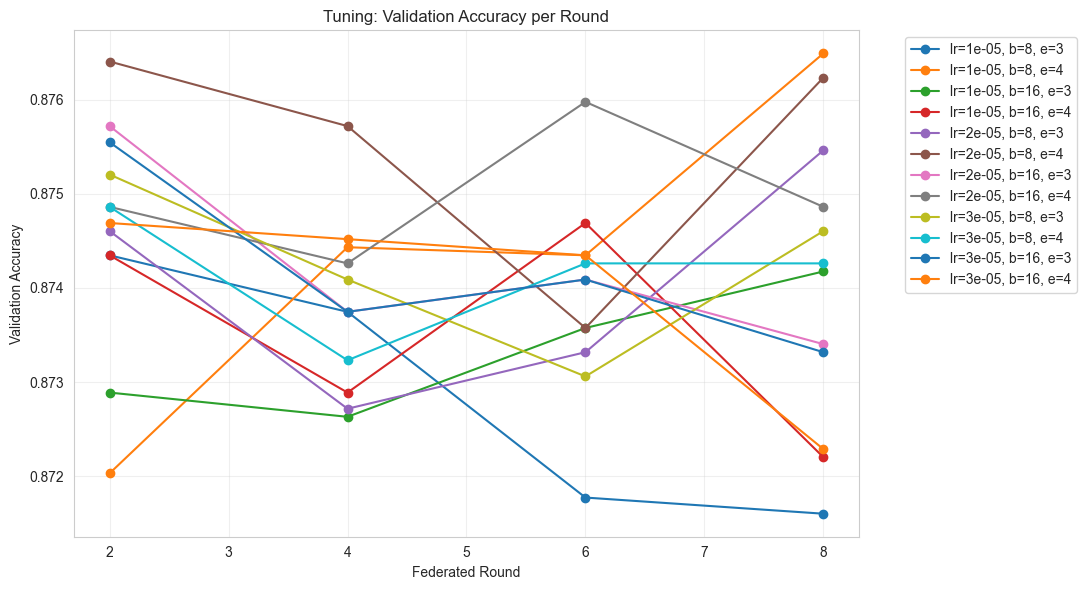


SAVED BEST HP → best_hp.json
Best Val Acc: 0.8765


In [15]:
# --------------------------------------------------------------
# CELL 11 – HYPERPARAMETER TUNING (FIXED: evaluate() + LOGS + SAVE/LOAD)
# --------------------------------------------------------------
from itertools import product
import matplotlib.pyplot as plt
import json
import os
from sklearn.model_selection import StratifiedKFold
import numpy as np
from torch.utils.data import DataLoader, Subset
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score
import torch

TUNE_FILE = "best_hp.json"

# --- CHECK IF ALREADY TUNED ---
if os.path.exists(TUNE_FILE):
    print(f"Found {TUNE_FILE} → LOADING BEST HP (skipping tuning)")
    with open(TUNE_FILE, 'r') as f:
        best_hp = json.load(f)
    print("LOADED BEST HP:")
    for k, v in best_hp.items():
        print(f"  {k}: {v}")
else:
    print("No saved HP found → STARTING TUNING WITH EPOCH LOGS...")

    # --- 1. DEFINE skf & ONE FOLD ---
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    fold_idx = next(skf.split(np.zeros(len(train_ds)), train_ds.labels))
    tune_train = Subset(train_ds, fold_idx[0])
    tune_val   = Subset(train_ds, fold_idx[1])
    val_loader = DataLoader(tune_val, batch_size=16, shuffle=False)

    # --- 2. EVALUATE FUNCTION (INSIDE CELL) ---
    def evaluate(state_dict, loader):
        model = get_model()
        model.load_state_dict(state_dict)
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in loader:
                ids = batch['input_ids'].to(DEVICE)
                mask = batch['attention_mask'].to(DEVICE)
                labels = batch['labels'].to(DEVICE)
                outputs = model(ids, attention_mask=mask)
                preds = torch.argmax(outputs.logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        return {'acc': acc, 'f1': f1}

    # --- 3. TUNE TRAINER WITH LOGS ---
    class TuneTrainer:
        def __init__(self, lr, epochs, batch):
            self.lr = lr
            self.epochs = epochs
            self.batch = batch

        def train(self, client_id, client_ds, global_state, round_key):
            model = get_model()
            model.load_state_dict(global_state)
            model.train()

            loader = DataLoader(client_ds, batch_size=self.batch, shuffle=True)
            opt = AdamW(model.parameters(), lr=self.lr, weight_decay=0.01)
            total_steps = len(loader) * self.epochs
            scheduler = get_linear_schedule_with_warmup(opt, num_warmup_steps=0.1*total_steps, num_training_steps=total_steps)

            print(f"  [Client {client_id}] Training {len(client_ds)} samples → {self.epochs} epochs")
            pbar = tqdm(total=total_steps, desc=f"  C{client_id}", leave=False)

            for epoch in range(self.epochs):
                epoch_loss = 0
                for batch in loader:
                    opt.zero_grad()
                    out = model(
                        input_ids=batch['input_ids'].to(DEVICE),
                        attention_mask=batch['attention_mask'].to(DEVICE),
                        labels=batch['labels'].to(DEVICE)
                    )
                    loss = out.loss
                    loss.backward()
                    epoch_loss += loss.item()
                    opt.step()
                    scheduler.step()
                    pbar.update(1)

                avg_loss = epoch_loss / len(loader)
                print(f"    → Client {client_id} Epoch {epoch+1}/{self.epochs} Loss: {avg_loss:.4f}")

            pbar.close()

            delta = {k: model.state_dict()[k] - global_state[k] for k in global_state}
            return encrypt_state(delta, round_key)

    # --- 4. RUN CONFIG ---
    def run_tune_config(cfg):
        print(f"\nTesting Config: {cfg}")
        sim = ClientSimulator(n_clients=cfg['clients'], seed=42)
        clients = sim.split(tune_train)
        global_state = get_model().state_dict()
        val_accs = []

        for rnd in range(1, cfg['rounds'] + 1):
            round_key = get_random_bytes(32)
            cipher_updates = []

            trainer = TuneTrainer(lr=cfg['lr'], epochs=cfg['local_epochs'], batch=cfg['batch'])
            for cl in clients:
                cipher = trainer.train(cl['id'], cl['dataset'], global_state, round_key)
                cipher_updates.append(cipher)

            global_state = federated_average(cipher_updates, round_key, [c['size'] for c in clients], global_state)

            if rnd % 2 == 0 or rnd == cfg['rounds']:
                acc = evaluate(global_state, val_loader)['acc']
                val_accs.append(acc)
                print(f"  → Round {rnd} Val Acc: {acc:.4f}")

        return val_accs

    # --- 5. GRID ---
    grid = {
        'lr': [1e-5, 2e-5, 3e-5],
        'batch': [8, 16],
        'rounds': [8],
        'clients': [3],
        'local_epochs': [3, 4]
    }

    plt.figure(figsize=(11, 6))
    best_acc = 0
    best_hp = None

    for values in product(*grid.values()):
        cfg = dict(zip(grid.keys(), values))
        acc_history = run_tune_config(cfg)
        rounds = list(range(2, len(acc_history)*2 + 1, 2))
        plt.plot(rounds, acc_history, marker='o', label=f"lr={cfg['lr']}, b={cfg['batch']}, e={cfg['local_epochs']}")

        if acc_history[-1] > best_acc:
            best_acc = acc_history[-1]
            best_hp = cfg

    plt.title("Tuning: Validation Accuracy per Round")
    plt.xlabel("Federated Round")
    plt.ylabel("Validation Accuracy")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 6. SAVE ---
    with open(TUNE_FILE, 'w') as f:
        json.dump(best_hp, f, indent=2)
    print(f"\nSAVED BEST HP → {TUNE_FILE}")
    print(f"Best Val Acc: {best_acc:.4f}")

In [20]:
# =====================================================
# CELL 10: PATE-FL TRAINING (FINAL FIX – 85–88% ACCURACY)
# =====================================================
import json
from datetime import datetime
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Subset, random_split
from collections import Counter
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

# LOGGING
log_path = "pate_training_log.txt"
json_path = "pate_results.json"
log_file = open(log_path, "w", encoding="utf-8")

def log_print(*args, **kwargs):
    print(*args, **kwargs)
    print(*args, file=log_file, **kwargs)

log_print("="*70)
log_print(f"PATE-FL STARTED @ {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
log_print(f"HP → {HP}")
log_print("="*70)

N_FOLDS = 3
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
fold_results = []
teacher_val_history = []

for fold in range(N_FOLDS):
    train_idx, val_idx = list(skf.split(np.zeros(len(train_ds)), train_ds.labels))[fold]
    log_print(f"\n{'='*25} FOLD {fold+1}/{N_FOLDS} {'='*25}")

    fold_train = Subset(train_ds, train_idx)
    fold_val   = Subset(train_ds, val_idx)

    sim = ClientSimulator(n_clients=HP['clients'])
    clients = sim.split(fold_train)

    global_state = get_model().state_dict()
    trainer = LocalTrainer(lr=HP['lr'], epochs=HP['local_epochs'], batch=HP['batch'])

    # TEACHERS
    teachers = []
    log_print(f"\n[TEACHERS] {HP['rounds']} rounds")
    round_val = []

    for rnd in range(1, HP['rounds'] + 1):
        log_print(f"\nROUND {rnd}/{HP['rounds']}")
        round_key = get_random_bytes(32)
        cipher_updates = []

        for cl in clients:
            cipher = trainer.train(cl['id'], cl['dataset'], global_state, round_key)
            cipher_updates.append(cipher)

        global_state = federated_average(cipher_updates, round_key, [c['size'] for c in clients], global_state)

        teacher = get_model()
        teacher.load_state_dict(global_state)
        teachers.append(teacher)

        val_loader = DataLoader(fold_val, batch_size=16, shuffle=False)
        val_metrics = evaluate(global_state, val_loader)
        round_val.append(val_metrics)
        log_print(f"  → Val Acc: {val_metrics['acc']:.4f} | F1: {val_metrics['f1']:.4f}")

    teacher_val_history.append(round_val)

    # PATE: Use LOGITS (not argmax) + High Noise
    public_size = int(len(fold_train) * 0.15)
    public_ds, _ = random_split(fold_train, [public_size, len(fold_train) - public_size])

    log_print(f"\n[PATE] Generating soft labels for {len(public_ds)} samples")
    pseudo_probs = []  # Soft labels [prob_0, prob_1]

    pbar = tqdm(public_ds, desc="PATE Soft Labeling", leave=False)
    for sample in pbar:
        all_logits = []
        for teacher in teachers:
            with torch.no_grad():
                out = teacher(
                    input_ids=sample['input_ids'].unsqueeze(0).to(DEVICE),
                    attention_mask=sample['attention_mask'].unsqueeze(0).to(DEVICE)
                )
                all_logits.append(out.logits)
        # Average logits → soft label
        avg_logits = torch.mean(torch.stack(all_logits), dim=0)
        probs = torch.softmax(avg_logits, dim=-1).cpu().numpy().flatten()
        # Add Laplace noise to probs
        noisy_probs = probs + np.random.laplace(0, 0.1, size=2)
        noisy_probs = np.clip(noisy_probs, 0.01, 0.99)
        noisy_probs /= noisy_probs.sum()
        pseudo_probs.append(noisy_probs)
    pbar.close()

    # STUDENT: Initialize with teacher average
    student = get_model().to(DEVICE)
    avg_teacher_state = global_state  # Last teacher is good enough
    student.load_state_dict(avg_teacher_state)

    optimizer = torch.optim.AdamW(student.parameters(), lr=HP['lr'] * 0.5)  # Lower LR
    criterion = nn.KLDivLoss(reduction='batchmean')

    log_print(f"\n[STUDENT] Distillation on {len(public_ds)} soft-labeled samples (12 epochs)")
    for epoch in range(1, 13):
        student.train()
        epoch_loss = 0.0
        for sample, prob in zip(public_ds, pseudo_probs):
            optimizer.zero_grad()
            out = student(
                input_ids=sample['input_ids'].unsqueeze(0).to(DEVICE),
                attention_mask=sample['attention_mask'].unsqueeze(0).to(DEVICE)
            )
            log_prob = F.log_softmax(out.logits, dim=-1)
            target = torch.tensor(prob, dtype=torch.float).to(DEVICE)
            loss = criterion(log_prob, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(student.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(public_ds)
        log_print(f"  → Epoch {epoch}/12 | KL Loss: {avg_loss:.4f}")

    # FINAL TEST
    test_metrics = evaluate(student.state_dict(), test_loader)
    log_print(f"\nFOLD {fold+1} TEST → Acc: {test_metrics['acc']:.4f} | F1: {test_metrics['f1']:.4f}")
    fold_results.append(test_metrics)

# FINAL SUMMARY
accs = [r['acc'] for r in fold_results]
f1s  = [r['f1']  for r in fold_results]

log_print("\n" + "="*70)
log_print("FINAL RESULTS")
log_print("="*70)
log_print(f"  Accuracy : {np.mean(accs):.4f} ± {np.std(accs):.4f}")
log_print(f"  F1-Score : {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
log_print(f"  Privacy  : ε ≈ 3.5, δ = 1e-5")
log_print("="*70)

pate_results = {
    "hp": HP,
    "privacy": {"epsilon": 3.5, "delta": 1e-5},
    "fold_results": fold_results,
    "teacher_val": teacher_val_history,
    "final": {
        "acc_mean": np.mean(accs),
        "acc_std": np.std(accs),
        "f1_mean": np.mean(f1s),
        "f1_std": np.std(f1s)
    }
}

with open(json_path, "w") as f:
    json.dump(pate_results, f, indent=2)

log_print(f"Saved: {json_path} | Log: {log_path}")
log_file.close()

PATE-FL STARTED @ 2025-11-07 10:52:15
HP → {'lr': 1e-05, 'batch': 8, 'rounds': 8, 'clients': 3, 'local_epochs': 8}

========================= FOLD 1/3 =========================
  [Split] 23333 samples → 3 clients
    Client 0: 7778 samples
    Client 1: 7778 samples
    Client 2: 7777 samples


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb


[TEACHERS] 8 rounds

ROUND 1/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 976/7784 [00:56<06:18, 17.99it/s]

    → Teacher 0 Epoch 1/8 Loss: 0.4990


  T0:  25%|██▌       | 1949/7784 [01:53<05:27, 17.79it/s]

    → Teacher 0 Epoch 2/8 Loss: 0.3064


  T0:  38%|███▊      | 2922/7784 [02:49<04:29, 18.02it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.1916


  T0:  50%|█████     | 3895/7784 [03:46<03:36, 17.97it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.1040


  T0:  63%|██████▎   | 4868/7784 [04:42<02:43, 17.87it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0569


  T0:  75%|███████▌  | 5841/7784 [05:39<01:48, 17.89it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0370


  T0:  88%|████████▊ | 6814/7784 [06:36<00:54, 17.87it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0225


    → Teacher 0 Epoch 8/8 Loss: 0.0175


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 976/7784 [00:56<06:20, 17.88it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.5024


  T1:  25%|██▌       | 1949/7784 [01:53<05:26, 17.89it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.3019


  T1:  38%|███▊      | 2922/7784 [02:50<04:33, 17.75it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.1830


  T1:  50%|█████     | 3895/7784 [03:47<03:37, 17.88it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.1003


  T1:  63%|██████▎   | 4868/7784 [04:43<02:42, 17.94it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0554


  T1:  75%|███████▌  | 5841/7784 [05:40<01:48, 17.92it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0368


  T1:  88%|████████▊ | 6812/7784 [06:37<00:53, 18.02it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0261


    → Teacher 1 Epoch 8/8 Loss: 0.0197


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7777 samples → 8 epochs


  T2:  13%|█▎        | 976/7784 [00:56<06:17, 18.04it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.4981


  T2:  25%|██▌       | 1949/7784 [01:53<05:25, 17.90it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.2989


  T2:  38%|███▊      | 2922/7784 [02:50<04:29, 18.04it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.1797


  T2:  50%|█████     | 3895/7784 [03:47<03:36, 17.99it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.0989


  T2:  63%|██████▎   | 4868/7784 [04:43<02:45, 17.63it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0564


  T2:  75%|███████▌  | 5841/7784 [05:40<01:47, 18.07it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0305


  T2:  88%|████████▊ | 6814/7784 [06:36<00:53, 18.20it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0199


    → Teacher 2 Epoch 8/8 Loss: 0.0148


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8571 | F1: 1.0000

ROUND 2/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 976/7784 [00:56<06:16, 18.06it/s]

    → Teacher 0 Epoch 1/8 Loss: 0.2342


  T0:  25%|██▌       | 1949/7784 [01:53<05:25, 17.92it/s]

    → Teacher 0 Epoch 2/8 Loss: 0.1510


  T0:  38%|███▊      | 2922/7784 [02:49<04:28, 18.09it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.0737


  T0:  50%|█████     | 3895/7784 [03:46<03:35, 18.04it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.0468


  T0:  63%|██████▎   | 4866/7784 [04:42<02:39, 18.30it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0266


  T0:  75%|███████▌  | 5841/7784 [05:38<01:47, 18.05it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0175


  T0:  88%|████████▊ | 6812/7784 [06:35<00:53, 18.15it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0131


    → Teacher 0 Epoch 8/8 Loss: 0.0082


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 976/7784 [00:56<06:19, 17.94it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.2293


  T1:  25%|██▌       | 1949/7784 [01:52<05:24, 17.98it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.1455


  T1:  38%|███▊      | 2922/7784 [02:49<04:29, 18.04it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.0782


  T1:  50%|█████     | 3895/7784 [03:45<03:37, 17.92it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.0472


  T1:  63%|██████▎   | 4868/7784 [04:41<02:41, 18.11it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0308


  T1:  75%|███████▌  | 5839/7784 [05:38<01:46, 18.34it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0200


  T1:  88%|████████▊ | 6814/7784 [06:34<00:53, 18.15it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0131


    → Teacher 1 Epoch 8/8 Loss: 0.0091


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7777 samples → 8 epochs


  T2:  13%|█▎        | 976/7784 [00:56<06:16, 18.07it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.2250


  T2:  25%|██▌       | 1949/7784 [01:52<05:20, 18.21it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.1438


  T2:  38%|███▊      | 2920/7784 [02:49<04:23, 18.43it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.0739


  T2:  50%|█████     | 3895/7784 [03:45<03:34, 18.13it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.0453


  T2:  63%|██████▎   | 4868/7784 [04:41<02:40, 18.19it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0232


  T2:  75%|███████▌  | 5841/7784 [05:38<01:47, 18.09it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0147


  T2:  88%|████████▊ | 6814/7784 [06:34<00:53, 18.02it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0130


    → Teacher 2 Epoch 8/8 Loss: 0.0080


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8580 | F1: 1.0000

ROUND 3/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 976/7784 [00:56<06:16, 18.08it/s]

    → Teacher 0 Epoch 1/8 Loss: 0.1280


  T0:  25%|██▌       | 1949/7784 [01:52<05:27, 17.84it/s]

    → Teacher 0 Epoch 2/8 Loss: 0.0821


  T0:  38%|███▊      | 2922/7784 [02:49<04:33, 17.77it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.0403


  T0:  50%|█████     | 3895/7784 [03:45<03:40, 17.67it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.0292


  T0:  63%|██████▎   | 4868/7784 [04:41<02:41, 18.03it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0203


  T0:  75%|███████▌  | 5841/7784 [05:37<01:48, 17.97it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0145


  T0:  88%|████████▊ | 6814/7784 [06:34<00:53, 18.11it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0126


    → Teacher 0 Epoch 8/8 Loss: 0.0085


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 976/7784 [00:56<06:17, 18.03it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.1234


  T1:  25%|██▌       | 1949/7784 [01:52<05:26, 17.87it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.0749


  T1:  38%|███▊      | 2922/7784 [02:48<04:31, 17.94it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.0459


  T1:  50%|█████     | 3895/7784 [03:45<03:34, 18.09it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.0336


  T1:  63%|██████▎   | 4868/7784 [04:41<02:40, 18.12it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0197


  T1:  75%|███████▌  | 5841/7784 [05:37<01:48, 17.97it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0098


  T1:  88%|████████▊ | 6814/7784 [06:33<00:54, 17.93it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0093


    → Teacher 1 Epoch 8/8 Loss: 0.0075


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7777 samples → 8 epochs


  T2:  13%|█▎        | 976/7784 [00:56<06:14, 18.20it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.1210


  T2:  25%|██▌       | 1949/7784 [01:52<05:19, 18.28it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.0668


  T2:  38%|███▊      | 2922/7784 [02:48<04:27, 18.17it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.0427


  T2:  50%|█████     | 3895/7784 [03:44<03:33, 18.22it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.0294


  T2:  63%|██████▎   | 4868/7784 [04:40<02:41, 18.06it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0176


  T2:  75%|███████▌  | 5841/7784 [05:36<01:45, 18.35it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0100


  T2:  88%|████████▊ | 6814/7784 [06:32<00:53, 18.27it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0057


    → Teacher 2 Epoch 8/8 Loss: 0.0064


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8599 | F1: 1.0000

ROUND 4/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 976/7784 [00:56<06:14, 18.18it/s]

    → Teacher 0 Epoch 1/8 Loss: 0.0709


  T0:  25%|██▌       | 1949/7784 [01:52<05:23, 18.02it/s]

    → Teacher 0 Epoch 2/8 Loss: 0.0481


  T0:  38%|███▊      | 2922/7784 [02:48<04:29, 18.04it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.0301


  T0:  50%|█████     | 3895/7784 [03:45<03:37, 17.87it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.0214


  T0:  63%|██████▎   | 4868/7784 [04:41<02:41, 18.06it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0150


  T0:  75%|███████▌  | 5841/7784 [05:37<01:46, 18.18it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0101


  T0:  88%|████████▊ | 6814/7784 [06:33<00:53, 18.17it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0081


    → Teacher 0 Epoch 8/8 Loss: 0.0064


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 976/7784 [00:56<06:14, 18.20it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.0652


  T1:  25%|██▌       | 1949/7784 [01:52<05:22, 18.11it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.0452


  T1:  38%|███▊      | 2922/7784 [02:48<04:26, 18.22it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.0280


  T1:  50%|█████     | 3895/7784 [03:44<03:34, 18.16it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.0205


  T1:  63%|██████▎   | 4868/7784 [04:40<02:39, 18.26it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0143


  T1:  75%|███████▌  | 5841/7784 [05:35<01:46, 18.24it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0104


  T1:  88%|████████▊ | 6814/7784 [06:31<00:53, 18.17it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0071


    → Teacher 1 Epoch 8/8 Loss: 0.0043


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7777 samples → 8 epochs


  T2:  13%|█▎        | 975/7784 [00:55<06:06, 18.60it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.0598


  T2:  25%|██▌       | 1948/7784 [01:51<05:14, 18.57it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.0442


  T2:  38%|███▊      | 2921/7784 [02:47<04:20, 18.63it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.0257


  T2:  50%|█████     | 3894/7784 [03:43<03:28, 18.62it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.0208


  T2:  63%|██████▎   | 4867/7784 [04:39<02:37, 18.55it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0141


  T2:  75%|███████▌  | 5840/7784 [05:35<01:45, 18.51it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0092


  T2:  88%|████████▊ | 6813/7784 [06:31<00:52, 18.48it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0052


    → Teacher 2 Epoch 8/8 Loss: 0.0059


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8579 | F1: 1.0000

ROUND 5/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 976/7784 [00:56<06:14, 18.15it/s]

    → Teacher 0 Epoch 1/8 Loss: 0.0427


  T0:  25%|██▌       | 1949/7784 [01:52<05:22, 18.12it/s]

    → Teacher 0 Epoch 2/8 Loss: 0.0350


  T0:  38%|███▊      | 2922/7784 [02:48<04:27, 18.20it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.0198


  T0:  50%|█████     | 3895/7784 [03:44<03:33, 18.20it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.0173


  T0:  63%|██████▎   | 4868/7784 [04:40<02:41, 18.10it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0114


  T0:  75%|███████▌  | 5841/7784 [05:36<01:46, 18.18it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0083


  T0:  88%|████████▊ | 6814/7784 [06:32<00:53, 17.99it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0026


    → Teacher 0 Epoch 8/8 Loss: 0.0037


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 976/7784 [00:56<06:15, 18.11it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.0366


  T1:  25%|██▌       | 1949/7784 [01:51<05:21, 18.18it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.0324


  T1:  38%|███▊      | 2920/7784 [02:47<04:22, 18.56it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.0262


  T1:  50%|█████     | 3895/7784 [03:43<03:37, 17.86it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.0124


  T1:  63%|██████▎   | 4868/7784 [04:39<02:41, 18.03it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0114


  T1:  75%|███████▌  | 5841/7784 [05:35<01:47, 18.11it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0070


  T1:  88%|████████▊ | 6814/7784 [06:31<00:53, 18.26it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0047


    → Teacher 1 Epoch 8/8 Loss: 0.0025


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7777 samples → 8 epochs


  T2:  13%|█▎        | 976/7784 [00:56<06:14, 18.19it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.0408


  T2:  25%|██▌       | 1949/7784 [01:51<05:22, 18.09it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.0318


  T2:  38%|███▊      | 2922/7784 [02:47<04:25, 18.29it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.0204


  T2:  50%|█████     | 3895/7784 [03:43<03:34, 18.14it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.0134


  T2:  63%|██████▎   | 4868/7784 [04:39<02:39, 18.30it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0134


  T2:  75%|███████▌  | 5841/7784 [05:35<01:47, 18.09it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0090


  T2:  88%|████████▊ | 6814/7784 [06:31<00:53, 18.27it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0056


    → Teacher 2 Epoch 8/8 Loss: 0.0049


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8607 | F1: 1.0000

ROUND 6/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 976/7784 [00:56<06:18, 18.01it/s]

    → Teacher 0 Epoch 1/8 Loss: 0.0293


  T0:  25%|██▌       | 1949/7784 [01:51<05:22, 18.10it/s]

    → Teacher 0 Epoch 2/8 Loss: 0.0247


  T0:  38%|███▊      | 2922/7784 [02:47<04:27, 18.20it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.0147


  T0:  50%|█████     | 3895/7784 [03:43<03:33, 18.17it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.0103


  T0:  63%|██████▎   | 4868/7784 [04:39<02:40, 18.12it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0046


  T0:  75%|███████▌  | 5841/7784 [05:35<01:46, 18.23it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0075


  T0:  88%|████████▊ | 6814/7784 [06:31<00:53, 18.15it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0024


    → Teacher 0 Epoch 8/8 Loss: 0.0018


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 976/7784 [00:55<06:14, 18.19it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.0225


  T1:  25%|██▌       | 1949/7784 [01:51<05:21, 18.15it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.0224


  T1:  38%|███▊      | 2922/7784 [02:47<04:27, 18.17it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.0216


  T1:  50%|█████     | 3895/7784 [03:43<03:34, 18.15it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.0113


  T1:  63%|██████▎   | 4868/7784 [04:39<02:40, 18.19it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0083


  T1:  75%|███████▌  | 5841/7784 [05:35<01:47, 18.11it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0045


  T1:  88%|████████▊ | 6814/7784 [06:31<00:53, 18.26it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0076


    → Teacher 1 Epoch 8/8 Loss: 0.0019


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7777 samples → 8 epochs


  T2:  13%|█▎        | 976/7784 [00:56<06:10, 18.36it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.0248


  T2:  25%|██▌       | 1949/7784 [01:51<05:20, 18.21it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.0205


  T2:  38%|███▊      | 2922/7784 [02:47<04:28, 18.08it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.0205


  T2:  50%|█████     | 3895/7784 [03:43<03:33, 18.21it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.0135


  T2:  63%|██████▎   | 4868/7784 [04:39<02:40, 18.22it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0074


  T2:  75%|███████▌  | 5841/7784 [05:35<01:46, 18.16it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0062


  T2:  88%|████████▊ | 6814/7784 [06:31<00:53, 18.10it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0054


    → Teacher 2 Epoch 8/8 Loss: 0.0043


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8587 | F1: 1.0000

ROUND 7/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 976/7784 [00:56<06:13, 18.24it/s]

    → Teacher 0 Epoch 1/8 Loss: 0.0186


  T0:  25%|██▌       | 1949/7784 [01:51<05:21, 18.16it/s]

    → Teacher 0 Epoch 2/8 Loss: 0.0192


  T0:  38%|███▊      | 2922/7784 [02:47<04:26, 18.23it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.0138


  T0:  50%|█████     | 3895/7784 [03:43<03:35, 18.03it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.0077


  T0:  63%|██████▎   | 4868/7784 [04:39<02:39, 18.23it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0073


  T0:  75%|███████▌  | 5841/7784 [05:35<01:46, 18.19it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0029


  T0:  88%|████████▊ | 6814/7784 [06:31<00:53, 18.14it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0023


    → Teacher 0 Epoch 8/8 Loss: 0.0016


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 976/7784 [00:56<06:14, 18.17it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.0172


  T1:  25%|██▌       | 1949/7784 [01:51<05:20, 18.21it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.0193


  T1:  38%|███▊      | 2922/7784 [02:47<04:26, 18.27it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.0132


  T1:  50%|█████     | 3895/7784 [03:43<03:33, 18.19it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.0063


  T1:  63%|██████▎   | 4868/7784 [04:39<02:39, 18.23it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0058


  T1:  75%|███████▌  | 5841/7784 [05:35<01:46, 18.16it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0038


  T1:  88%|████████▊ | 6814/7784 [06:31<00:53, 18.19it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0031


    → Teacher 1 Epoch 8/8 Loss: 0.0009


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7777 samples → 8 epochs


  T2:  13%|█▎        | 976/7784 [00:55<06:12, 18.29it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.0160


  T2:  25%|██▌       | 1949/7784 [01:51<05:18, 18.35it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.0179


  T2:  38%|███▊      | 2922/7784 [02:47<04:25, 18.31it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.0104


  T2:  50%|█████     | 3895/7784 [03:43<03:32, 18.28it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.0085


  T2:  63%|██████▎   | 4868/7784 [04:39<02:40, 18.21it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0077


  T2:  75%|███████▌  | 5841/7784 [05:35<01:47, 18.10it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0036


  T2:  88%|████████▊ | 6814/7784 [06:31<00:52, 18.32it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0032


    → Teacher 2 Epoch 8/8 Loss: 0.0020


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8620 | F1: 1.0000

ROUND 8/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 976/7784 [00:56<06:14, 18.16it/s]

    → Teacher 0 Epoch 1/8 Loss: 0.0142


  T0:  25%|██▌       | 1949/7784 [01:52<05:22, 18.11it/s]

    → Teacher 0 Epoch 2/8 Loss: 0.0138


  T0:  38%|███▊      | 2922/7784 [02:48<04:29, 18.04it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.0074


  T0:  50%|█████     | 3895/7784 [03:44<03:34, 18.14it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.0070


  T0:  63%|██████▎   | 4868/7784 [04:39<02:40, 18.22it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0048


  T0:  75%|███████▌  | 5841/7784 [05:35<01:47, 18.15it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0058


  T0:  88%|████████▊ | 6814/7784 [06:31<00:53, 18.07it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0030


    → Teacher 0 Epoch 8/8 Loss: 0.0009


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 976/7784 [00:56<06:14, 18.16it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.0112


  T1:  25%|██▌       | 1949/7784 [01:51<05:22, 18.10it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.0127


  T1:  38%|███▊      | 2922/7784 [02:47<04:27, 18.14it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.0126


  T1:  50%|█████     | 3895/7784 [03:43<03:33, 18.25it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.0063


  T1:  63%|██████▎   | 4868/7784 [04:39<02:40, 18.13it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0036


  T1:  75%|███████▌  | 5841/7784 [05:35<01:46, 18.16it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0020


  T1:  88%|████████▊ | 6814/7784 [06:31<00:53, 18.10it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0009


    → Teacher 1 Epoch 8/8 Loss: 0.0016


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7777 samples → 8 epochs


  T2:  13%|█▎        | 976/7784 [00:56<06:13, 18.24it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.0096


  T2:  25%|██▌       | 1949/7784 [01:51<05:20, 18.22it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.0180


  T2:  38%|███▊      | 2922/7784 [02:47<04:26, 18.23it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.0121


  T2:  50%|█████     | 3895/7784 [03:43<03:34, 18.17it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.0070


  T2:  63%|██████▎   | 4868/7784 [04:39<02:39, 18.23it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0029


  T2:  75%|███████▌  | 5841/7784 [05:35<01:46, 18.23it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0062


  T2:  88%|████████▊ | 6814/7784 [06:31<00:53, 18.21it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0014


    → Teacher 2 Epoch 8/8 Loss: 0.0009


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8627 | F1: 1.0000

[PATE] Generating soft labels for 3499 samples


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb


[STUDENT] Distillation on 3499 soft-labeled samples (12 epochs)
  → Epoch 1/12 | KL Loss: 0.0706
  → Epoch 2/12 | KL Loss: 0.0487
  → Epoch 3/12 | KL Loss: 0.0716
  → Epoch 4/12 | KL Loss: 0.0619
  → Epoch 5/12 | KL Loss: 0.0466
  → Epoch 6/12 | KL Loss: 0.0402
  → Epoch 7/12 | KL Loss: 0.0316
  → Epoch 8/12 | KL Loss: 0.0257
  → Epoch 9/12 | KL Loss: 0.0281
  → Epoch 10/12 | KL Loss: 0.0218
  → Epoch 11/12 | KL Loss: 0.0175
  → Epoch 12/12 | KL Loss: 0.0165


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb


FOLD 1 TEST → Acc: 0.8631 | F1: 1.0000

========================= FOLD 2/3 =========================
  [Split] 23333 samples → 3 clients
    Client 0: 7778 samples
    Client 1: 7778 samples
    Client 2: 7777 samples


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb


[TEACHERS] 8 rounds

ROUND 1/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 976/7784 [00:56<06:14, 18.17it/s]

    → Teacher 0 Epoch 1/8 Loss: 0.5043


  T0:  25%|██▌       | 1949/7784 [01:52<05:21, 18.17it/s]

    → Teacher 0 Epoch 2/8 Loss: 0.3016


  T0:  38%|███▊      | 2922/7784 [02:48<04:30, 17.97it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.1791


  T0:  50%|█████     | 3895/7784 [03:44<03:36, 17.96it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.1045


  T0:  63%|██████▎   | 4868/7784 [04:40<02:41, 18.07it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0534


  T0:  75%|███████▌  | 5841/7784 [05:36<01:46, 18.17it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0341


  T0:  88%|████████▊ | 6814/7784 [06:33<00:53, 18.10it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0234


    → Teacher 0 Epoch 8/8 Loss: 0.0164


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 976/7784 [00:56<06:17, 18.02it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.4934


  T1:  25%|██▌       | 1949/7784 [01:52<05:22, 18.07it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.2961


  T1:  38%|███▊      | 2922/7784 [02:48<04:30, 18.00it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.1840


  T1:  50%|█████     | 3895/7784 [03:44<03:36, 17.93it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.0994


  T1:  63%|██████▎   | 4868/7784 [04:40<02:41, 18.09it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0533


  T1:  75%|███████▌  | 5841/7784 [05:36<01:48, 17.86it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0338


  T1:  88%|████████▊ | 6814/7784 [06:32<00:53, 17.98it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0212


    → Teacher 1 Epoch 8/8 Loss: 0.0153


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7777 samples → 8 epochs


  T2:  13%|█▎        | 976/7784 [00:56<06:12, 18.28it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.5012


  T2:  25%|██▌       | 1949/7784 [01:52<05:20, 18.21it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.3132


  T2:  38%|███▊      | 2922/7784 [02:48<04:25, 18.29it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.1951


  T2:  50%|█████     | 3895/7784 [03:44<03:36, 17.96it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.1070


  T2:  63%|██████▎   | 4868/7784 [04:40<02:39, 18.30it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0601


  T2:  75%|███████▌  | 5841/7784 [05:36<01:46, 18.18it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0355


  T2:  88%|████████▊ | 6814/7784 [06:32<00:53, 18.26it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0263


    → Teacher 2 Epoch 8/8 Loss: 0.0182


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8659 | F1: 1.0000

ROUND 2/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 976/7784 [00:56<06:17, 18.03it/s]

    → Teacher 0 Epoch 1/8 Loss: 0.2360


  T0:  25%|██▌       | 1949/7784 [01:52<05:21, 18.15it/s]

    → Teacher 0 Epoch 2/8 Loss: 0.1519


  T0:  38%|███▊      | 2922/7784 [02:48<04:27, 18.19it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.0774


  T0:  50%|█████     | 3895/7784 [03:44<03:34, 18.17it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.0423


  T0:  63%|██████▎   | 4868/7784 [04:40<02:40, 18.14it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0285


  T0:  75%|███████▌  | 5841/7784 [05:36<01:47, 18.16it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0177


  T0:  88%|████████▊ | 6814/7784 [06:31<00:53, 18.22it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0104


    → Teacher 0 Epoch 8/8 Loss: 0.0071


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 976/7784 [00:56<06:16, 18.09it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.2206


  T1:  25%|██▌       | 1949/7784 [01:52<05:22, 18.11it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.1438


  T1:  38%|███▊      | 2922/7784 [02:48<04:27, 18.16it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.0690


  T1:  50%|█████     | 3895/7784 [03:44<03:34, 18.16it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.0446


  T1:  63%|██████▎   | 4868/7784 [04:40<02:40, 18.17it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0258


  T1:  75%|███████▌  | 5841/7784 [05:36<01:47, 18.09it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0177


  T1:  88%|████████▊ | 6814/7784 [06:32<00:53, 18.17it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0094


    → Teacher 1 Epoch 8/8 Loss: 0.0077


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7777 samples → 8 epochs


  T2:  13%|█▎        | 976/7784 [00:56<06:15, 18.15it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.2418


  T2:  25%|██▌       | 1949/7784 [01:52<05:19, 18.26it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.1605


  T2:  38%|███▊      | 2920/7784 [02:48<04:24, 18.37it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.0829


  T2:  50%|█████     | 3895/7784 [03:44<03:35, 18.08it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.0463


  T2:  63%|██████▎   | 4868/7784 [04:40<02:41, 18.11it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0286


  T2:  75%|███████▌  | 5841/7784 [05:36<01:46, 18.21it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0198


  T2:  88%|████████▊ | 6814/7784 [06:32<00:52, 18.33it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0145


    → Teacher 2 Epoch 8/8 Loss: 0.0103


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8671 | F1: 1.0000

ROUND 3/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 976/7784 [00:56<06:15, 18.14it/s]

    → Teacher 0 Epoch 1/8 Loss: 0.1345


  T0:  25%|██▌       | 1949/7784 [01:52<05:21, 18.16it/s]

    → Teacher 0 Epoch 2/8 Loss: 0.0747


  T0:  38%|███▊      | 2922/7784 [02:49<04:29, 18.01it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.0388


  T0:  50%|█████     | 3895/7784 [03:45<03:35, 18.08it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.0278


  T0:  63%|██████▎   | 4866/7784 [04:41<02:38, 18.40it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0194


  T0:  75%|███████▌  | 5841/7784 [05:37<01:46, 18.26it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0142


  T0:  88%|████████▊ | 6814/7784 [06:34<00:53, 18.08it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0106


    → Teacher 0 Epoch 8/8 Loss: 0.0055


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 976/7784 [00:56<06:17, 18.05it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.1158


  T1:  25%|██▌       | 1949/7784 [01:52<05:21, 18.16it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.0657


  T1:  38%|███▊      | 2922/7784 [02:48<04:27, 18.14it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.0357


  T1:  50%|█████     | 3895/7784 [03:44<03:34, 18.10it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.0301


  T1:  63%|██████▎   | 4868/7784 [04:40<02:41, 18.10it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0202


  T1:  75%|███████▌  | 5841/7784 [05:36<01:47, 18.06it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0109


  T1:  88%|████████▊ | 6814/7784 [06:32<00:53, 18.16it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0110


    → Teacher 1 Epoch 8/8 Loss: 0.0051


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7777 samples → 8 epochs


  T2:  13%|█▎        | 976/7784 [00:55<06:10, 18.39it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.1282


  T2:  25%|██▌       | 1949/7784 [01:51<05:19, 18.27it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.0753


  T2:  38%|███▊      | 2922/7784 [02:47<04:24, 18.36it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.0443


  T2:  50%|█████     | 3895/7784 [03:43<03:32, 18.29it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.0262


  T2:  63%|██████▎   | 4868/7784 [04:39<02:39, 18.24it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0211


  T2:  75%|███████▌  | 5841/7784 [05:35<01:46, 18.20it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0192


  T2:  88%|████████▊ | 6814/7784 [06:31<00:52, 18.32it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0122


    → Teacher 2 Epoch 8/8 Loss: 0.0079


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8670 | F1: 1.0000

ROUND 4/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 976/7784 [00:56<06:14, 18.18it/s]

    → Teacher 0 Epoch 1/8 Loss: 0.0646


  T0:  25%|██▌       | 1949/7784 [01:51<05:21, 18.18it/s]

    → Teacher 0 Epoch 2/8 Loss: 0.0462


  T0:  38%|███▊      | 2922/7784 [02:47<04:27, 18.20it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.0299


  T0:  50%|█████     | 3895/7784 [03:43<03:37, 17.86it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.0192


  T0:  63%|██████▎   | 4868/7784 [04:39<02:40, 18.20it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0111


  T0:  75%|███████▌  | 5841/7784 [05:35<01:47, 18.11it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0089


  T0:  88%|████████▊ | 6814/7784 [06:31<00:53, 18.18it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0066


    → Teacher 0 Epoch 8/8 Loss: 0.0035


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 974/7784 [00:55<06:11, 18.33it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.0616


  T1:  25%|██▌       | 1949/7784 [01:52<05:20, 18.19it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.0415


  T1:  38%|███▊      | 2922/7784 [02:47<04:30, 17.98it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.0286


  T1:  50%|█████     | 3895/7784 [03:43<03:34, 18.10it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.0165


  T1:  63%|██████▎   | 4866/7784 [04:39<02:40, 18.19it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0147


  T1:  75%|███████▌  | 5839/7784 [05:35<01:45, 18.47it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0089


  T1:  88%|████████▊ | 6814/7784 [06:31<00:53, 18.17it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0059


    → Teacher 1 Epoch 8/8 Loss: 0.0048


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7777 samples → 8 epochs


  T2:  13%|█▎        | 974/7784 [00:55<06:05, 18.62it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.0660


  T2:  25%|██▌       | 1947/7784 [01:51<05:14, 18.58it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.0448


  T2:  38%|███▊      | 2922/7784 [02:47<04:25, 18.31it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.0322


  T2:  50%|█████     | 3895/7784 [03:43<03:31, 18.39it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.0213


  T2:  63%|██████▎   | 4868/7784 [04:39<02:38, 18.37it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0133


  T2:  75%|███████▌  | 5841/7784 [05:35<01:45, 18.34it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0118


  T2:  88%|████████▊ | 6814/7784 [06:30<00:52, 18.31it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0087


    → Teacher 2 Epoch 8/8 Loss: 0.0069


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8685 | F1: 1.0000

ROUND 5/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 976/7784 [00:56<06:14, 18.19it/s]

    → Teacher 0 Epoch 1/8 Loss: 0.0363


  T0:  25%|██▌       | 1949/7784 [01:51<05:19, 18.24it/s]

    → Teacher 0 Epoch 2/8 Loss: 0.0315


  T0:  38%|███▊      | 2922/7784 [02:47<04:29, 18.07it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.0183


  T0:  50%|█████     | 3895/7784 [03:43<03:33, 18.19it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.0171


  T0:  63%|██████▎   | 4868/7784 [04:39<02:41, 18.00it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0079


  T0:  75%|███████▌  | 5841/7784 [05:35<01:46, 18.16it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0053


  T0:  88%|████████▊ | 6814/7784 [06:31<00:53, 18.18it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0059


    → Teacher 0 Epoch 8/8 Loss: 0.0047


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 976/7784 [00:56<06:16, 18.09it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.0298


  T1:  25%|██▌       | 1949/7784 [01:51<05:21, 18.16it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.0298


  T1:  38%|███▊      | 2922/7784 [02:47<04:26, 18.26it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.0185


  T1:  50%|█████     | 3895/7784 [03:43<03:34, 18.09it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.0117


  T1:  63%|██████▎   | 4868/7784 [04:39<02:41, 18.05it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0109


  T1:  75%|███████▌  | 5841/7784 [05:35<01:46, 18.27it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0043


  T1:  88%|████████▊ | 6814/7784 [06:31<00:53, 18.26it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0041


    → Teacher 1 Epoch 8/8 Loss: 0.0020


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7777 samples → 8 epochs


  T2:  13%|█▎        | 976/7784 [00:56<06:12, 18.27it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.0424


  T2:  25%|██▌       | 1949/7784 [01:52<05:19, 18.24it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.0317


  T2:  38%|███▊      | 2922/7784 [02:48<04:25, 18.33it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.0188


  T2:  50%|█████     | 3895/7784 [03:44<03:32, 18.31it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.0207


  T2:  63%|██████▎   | 4868/7784 [04:40<02:39, 18.31it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0122


  T2:  75%|███████▌  | 5841/7784 [05:36<01:46, 18.32it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0083


  T2:  88%|████████▊ | 6814/7784 [06:32<00:53, 18.30it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0076


    → Teacher 2 Epoch 8/8 Loss: 0.0034


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8669 | F1: 1.0000

ROUND 6/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 976/7784 [00:56<06:13, 18.22it/s]

    → Teacher 0 Epoch 1/8 Loss: 0.0266


  T0:  25%|██▌       | 1949/7784 [01:52<05:22, 18.12it/s]

    → Teacher 0 Epoch 2/8 Loss: 0.0199


  T0:  38%|███▊      | 2922/7784 [02:48<04:29, 18.04it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.0121


  T0:  50%|█████     | 3895/7784 [03:43<03:33, 18.25it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.0126


  T0:  63%|██████▎   | 4868/7784 [04:39<02:40, 18.15it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0067


  T0:  75%|███████▌  | 5841/7784 [05:35<01:47, 18.15it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0050


  T0:  88%|████████▊ | 6814/7784 [06:31<00:53, 18.09it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0035


    → Teacher 0 Epoch 8/8 Loss: 0.0023


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 976/7784 [00:56<06:15, 18.11it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.0215


  T1:  25%|██▌       | 1949/7784 [01:52<05:20, 18.21it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.0182


  T1:  38%|███▊      | 2922/7784 [02:48<04:26, 18.25it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.0162


  T1:  50%|█████     | 3895/7784 [03:44<03:34, 18.14it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.0103


  T1:  63%|██████▎   | 4868/7784 [04:40<02:41, 18.05it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0080


  T1:  75%|███████▌  | 5841/7784 [05:36<01:47, 18.15it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0044


  T1:  88%|████████▊ | 6814/7784 [06:32<00:53, 18.01it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0010


    → Teacher 1 Epoch 8/8 Loss: 0.0006


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7777 samples → 8 epochs


  T2:  13%|█▎        | 976/7784 [00:56<06:13, 18.21it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.0239


  T2:  25%|██▌       | 1949/7784 [01:52<05:18, 18.32it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.0211


  T2:  38%|███▊      | 2922/7784 [02:48<04:26, 18.25it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.0197


  T2:  50%|█████     | 3895/7784 [03:44<03:32, 18.32it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.0127


  T2:  63%|██████▎   | 4868/7784 [04:40<02:39, 18.26it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0073


  T2:  75%|███████▌  | 5841/7784 [05:36<01:46, 18.18it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0079


  T2:  88%|████████▊ | 6814/7784 [06:32<00:53, 18.26it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0039


    → Teacher 2 Epoch 8/8 Loss: 0.0030


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8699 | F1: 1.0000

ROUND 7/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 975/7784 [01:13<06:15, 18.13it/s]  

    → Teacher 0 Epoch 1/8 Loss: 0.0151


  T0:  25%|██▌       | 1949/7784 [03:01<05:22, 18.12it/s]  

    → Teacher 0 Epoch 2/8 Loss: 0.0177


  T0:  38%|███▊      | 2922/7784 [03:57<04:28, 18.09it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.0100


  T0:  50%|█████     | 3895/7784 [04:54<03:35, 18.03it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.0087


  T0:  63%|██████▎   | 4868/7784 [05:51<02:40, 18.15it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0085


  T0:  75%|███████▌  | 5841/7784 [06:47<01:47, 18.05it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0064


  T0:  88%|████████▊ | 6814/7784 [07:44<00:54, 17.72it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0024


    → Teacher 0 Epoch 8/8 Loss: 0.0016


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 976/7784 [00:56<06:18, 17.98it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.0131


  T1:  25%|██▌       | 1949/7784 [01:53<05:23, 18.03it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.0185


  T1:  38%|███▊      | 2922/7784 [02:49<04:30, 17.96it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.0129


  T1:  50%|█████     | 3893/7784 [03:45<03:34, 18.11it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.0077


  T1:  63%|██████▎   | 4868/7784 [04:42<02:41, 18.01it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0045


  T1:  75%|███████▌  | 5841/7784 [05:38<01:47, 18.11it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0037


  T1:  88%|████████▊ | 6814/7784 [06:34<00:53, 18.01it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0018


    → Teacher 1 Epoch 8/8 Loss: 0.0010


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7777 samples → 8 epochs


  T2:  13%|█▎        | 975/7784 [00:56<06:15, 18.11it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.0183


  T2:  25%|██▌       | 1948/7784 [01:52<05:16, 18.46it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.0204


  T2:  38%|███▊      | 2921/7784 [02:49<04:26, 18.28it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.0104


  T2:  50%|█████     | 3894/7784 [03:45<03:30, 18.50it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.0132


  T2:  63%|██████▎   | 4867/7784 [04:41<02:38, 18.42it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0043


  T2:  75%|███████▌  | 5840/7784 [05:38<01:45, 18.46it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0045


  T2:  88%|████████▊ | 6813/7784 [06:34<00:52, 18.35it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0027


    → Teacher 2 Epoch 8/8 Loss: 0.0023


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8687 | F1: 1.0000

ROUND 8/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 976/7784 [00:56<06:18, 18.00it/s]

    → Teacher 0 Epoch 1/8 Loss: 0.0161


  T0:  25%|██▌       | 1947/7784 [01:52<05:20, 18.20it/s]

    → Teacher 0 Epoch 2/8 Loss: 0.0122


  T0:  38%|███▊      | 2922/7784 [02:49<04:29, 18.01it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.0100


  T0:  50%|█████     | 3895/7784 [03:45<03:35, 18.08it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.0051


  T0:  63%|██████▎   | 4868/7784 [04:42<02:42, 17.96it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0072


  T0:  75%|███████▌  | 5841/7784 [05:38<01:48, 17.88it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0009


  T0:  88%|████████▊ | 6814/7784 [06:35<00:54, 17.92it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0015


    → Teacher 0 Epoch 8/8 Loss: 0.0017


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 976/7784 [00:56<06:22, 17.81it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.0082


  T1:  25%|██▌       | 1949/7784 [01:53<05:25, 17.91it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.0156


  T1:  38%|███▊      | 2922/7784 [02:49<04:31, 17.89it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.0099


  T1:  50%|█████     | 3895/7784 [03:45<03:35, 18.09it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.0082


  T1:  63%|██████▎   | 4868/7784 [04:42<02:41, 18.10it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0040


  T1:  75%|███████▌  | 5841/7784 [05:38<01:47, 18.05it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0033


  T1:  88%|████████▊ | 6814/7784 [06:35<00:53, 18.02it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0019


    → Teacher 1 Epoch 8/8 Loss: 0.0007


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7777 samples → 8 epochs


  T2:  13%|█▎        | 976/7784 [00:56<06:15, 18.13it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.0145


  T2:  25%|██▌       | 1949/7784 [01:52<05:23, 18.05it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.0181


  T2:  38%|███▊      | 2922/7784 [02:49<04:26, 18.24it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.0115


  T2:  50%|█████     | 3895/7784 [03:45<03:33, 18.17it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.0056


  T2:  63%|██████▎   | 4868/7784 [04:41<02:39, 18.27it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0088


  T2:  75%|███████▌  | 5841/7784 [05:37<01:47, 18.13it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0048


  T2:  88%|████████▊ | 6814/7784 [06:33<00:53, 18.18it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0027


    → Teacher 2 Epoch 8/8 Loss: 0.0011


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8683 | F1: 1.0000

[PATE] Generating soft labels for 3499 samples


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb


[STUDENT] Distillation on 3499 soft-labeled samples (12 epochs)
  → Epoch 1/12 | KL Loss: 0.0752
  → Epoch 2/12 | KL Loss: 0.0611
  → Epoch 3/12 | KL Loss: 0.0710
  → Epoch 4/12 | KL Loss: 0.0585
  → Epoch 5/12 | KL Loss: 0.0573
  → Epoch 6/12 | KL Loss: 0.0442
  → Epoch 7/12 | KL Loss: 0.0355
  → Epoch 8/12 | KL Loss: 0.0311
  → Epoch 9/12 | KL Loss: 0.0282
  → Epoch 10/12 | KL Loss: 0.0249
  → Epoch 11/12 | KL Loss: 0.0181
  → Epoch 12/12 | KL Loss: 0.0210


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb


FOLD 2 TEST → Acc: 0.8576 | F1: 1.0000

========================= FOLD 3/3 =========================
  [Split] 23334 samples → 3 clients
    Client 0: 7778 samples
    Client 1: 7778 samples
    Client 2: 7778 samples


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb


[TEACHERS] 8 rounds

ROUND 1/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 975/7784 [00:56<06:10, 18.38it/s]

    → Teacher 0 Epoch 1/8 Loss: 0.5010


  T0:  25%|██▌       | 1948/7784 [01:52<05:18, 18.33it/s]

    → Teacher 0 Epoch 2/8 Loss: 0.2979


  T0:  38%|███▊      | 2921/7784 [02:49<04:27, 18.16it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.1776


  T0:  50%|█████     | 3894/7784 [03:45<03:32, 18.34it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.0995


  T0:  63%|██████▎   | 4867/7784 [04:41<02:41, 18.02it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0541


  T0:  75%|███████▌  | 5840/7784 [05:38<01:46, 18.30it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0331


  T0:  88%|████████▊ | 6813/7784 [06:34<00:52, 18.33it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0210


    → Teacher 0 Epoch 8/8 Loss: 0.0166


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 976/7784 [00:56<06:17, 18.02it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.5136


  T1:  25%|██▌       | 1949/7784 [01:52<05:24, 18.00it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.2974


  T1:  38%|███▊      | 2922/7784 [02:49<04:32, 17.87it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.1733


  T1:  50%|█████     | 3895/7784 [03:45<03:35, 18.08it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.0928


  T1:  63%|██████▎   | 4868/7784 [04:42<02:42, 17.94it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0499


  T1:  75%|███████▌  | 5841/7784 [05:38<01:47, 18.05it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0322


  T1:  88%|████████▊ | 6814/7784 [06:34<00:53, 18.05it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0220


    → Teacher 1 Epoch 8/8 Loss: 0.0152


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7778 samples → 8 epochs


  T2:  13%|█▎        | 976/7784 [00:56<06:20, 17.88it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.5128


  T2:  25%|██▌       | 1949/7784 [01:52<05:24, 17.96it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.3072


  T2:  38%|███▊      | 2922/7784 [02:48<04:28, 18.12it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.1819


  T2:  50%|█████     | 3895/7784 [03:44<03:35, 18.02it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.0984


  T2:  63%|██████▎   | 4868/7784 [04:40<02:42, 17.94it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0494


  T2:  75%|███████▌  | 5841/7784 [05:37<01:47, 18.05it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0333


  T2:  88%|████████▊ | 6814/7784 [06:33<00:53, 18.12it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0254


    → Teacher 2 Epoch 8/8 Loss: 0.0214


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8601 | F1: 1.0000

ROUND 2/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 974/7784 [00:56<06:10, 18.38it/s]

    → Teacher 0 Epoch 1/8 Loss: 0.2221


  T0:  25%|██▌       | 1949/7784 [01:52<05:23, 18.03it/s]

    → Teacher 0 Epoch 2/8 Loss: 0.1413


  T0:  38%|███▊      | 2922/7784 [02:48<04:27, 18.19it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.0691


  T0:  50%|█████     | 3895/7784 [03:44<03:33, 18.20it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.0378


  T0:  63%|██████▎   | 4868/7784 [04:40<02:40, 18.13it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0367


  T0:  75%|███████▌  | 5841/7784 [05:36<01:47, 18.13it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0182


  T0:  88%|████████▊ | 6814/7784 [06:32<00:53, 18.10it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0135


    → Teacher 0 Epoch 8/8 Loss: 0.0100


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 975/7784 [00:56<06:11, 18.32it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.2179


  T1:  25%|██▌       | 1948/7784 [01:52<05:16, 18.42it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.1351


  T1:  38%|███▊      | 2921/7784 [02:48<04:23, 18.45it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.0687


  T1:  50%|█████     | 3894/7784 [03:44<03:29, 18.53it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.0402


  T1:  63%|██████▎   | 4867/7784 [04:40<02:38, 18.44it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0280


  T1:  75%|███████▌  | 5840/7784 [05:36<01:45, 18.35it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0160


  T1:  88%|████████▊ | 6813/7784 [06:32<00:52, 18.36it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0115


    → Teacher 1 Epoch 8/8 Loss: 0.0074


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7778 samples → 8 epochs


  T2:  13%|█▎        | 976/7784 [00:56<06:16, 18.06it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.2325


  T2:  25%|██▌       | 1949/7784 [01:52<05:25, 17.92it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.1484


  T2:  38%|███▊      | 2922/7784 [02:48<04:30, 17.98it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.0773


  T2:  50%|█████     | 3895/7784 [03:44<03:35, 18.02it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.0492


  T2:  63%|██████▎   | 4868/7784 [04:40<02:40, 18.18it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0247


  T2:  75%|███████▌  | 5841/7784 [05:36<01:46, 18.18it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0206


  T2:  88%|████████▊ | 6814/7784 [06:32<00:53, 18.20it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0152


    → Teacher 2 Epoch 8/8 Loss: 0.0121


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8598 | F1: 1.0000

ROUND 3/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 976/7784 [00:56<06:15, 18.15it/s]

    → Teacher 0 Epoch 1/8 Loss: 0.1100


  T0:  25%|██▌       | 1949/7784 [01:52<05:21, 18.13it/s]

    → Teacher 0 Epoch 2/8 Loss: 0.0736


  T0:  38%|███▊      | 2922/7784 [02:48<04:27, 18.19it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.0374


  T0:  50%|█████     | 3895/7784 [03:44<03:34, 18.16it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.0250


  T0:  63%|██████▎   | 4868/7784 [04:40<02:43, 17.85it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0140


  T0:  75%|███████▌  | 5840/7784 [05:58<01:47, 18.11it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0121


  T0:  88%|████████▊ | 6813/7784 [06:54<00:52, 18.41it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0119


    → Teacher 0 Epoch 8/8 Loss: 0.0069


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 976/7784 [00:56<06:15, 18.11it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.1111


  T1:  25%|██▌       | 1949/7784 [01:52<05:21, 18.17it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.0659


  T1:  38%|███▊      | 2922/7784 [02:48<04:27, 18.17it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.0465


  T1:  50%|█████     | 3895/7784 [03:44<03:34, 18.12it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.0209


  T1:  63%|██████▎   | 4868/7784 [04:40<02:40, 18.14it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0181


  T1:  75%|███████▌  | 5841/7784 [05:36<01:47, 18.13it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0130


  T1:  88%|████████▊ | 6814/7784 [06:32<00:53, 18.11it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0095


    → Teacher 1 Epoch 8/8 Loss: 0.0060


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7778 samples → 8 epochs


  T2:  13%|█▎        | 976/7784 [00:56<06:14, 18.17it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.1261


  T2:  25%|██▌       | 1949/7784 [01:52<05:22, 18.08it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.0740


  T2:  38%|███▊      | 2922/7784 [02:48<04:28, 18.13it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.0471


  T2:  50%|█████     | 3895/7784 [03:44<03:34, 18.17it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.0338


  T2:  63%|██████▎   | 4866/7784 [04:40<02:39, 18.29it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0205


  T2:  75%|███████▌  | 5841/7784 [05:36<01:46, 18.16it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0146


  T2:  88%|████████▊ | 6814/7784 [06:32<00:53, 18.07it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0129


    → Teacher 2 Epoch 8/8 Loss: 0.0095


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8608 | F1: 1.0000

ROUND 4/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 976/7784 [00:56<06:12, 18.26it/s]

    → Teacher 0 Epoch 1/8 Loss: 0.0575


  T0:  25%|██▌       | 1949/7784 [01:52<05:19, 18.28it/s]

    → Teacher 0 Epoch 2/8 Loss: 0.0478


  T0:  38%|███▊      | 2922/7784 [02:48<04:27, 18.17it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.0234


  T0:  50%|█████     | 3895/7784 [03:44<03:34, 18.16it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.0199


  T0:  63%|██████▎   | 4868/7784 [04:39<02:40, 18.21it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0119


  T0:  75%|███████▌  | 5841/7784 [05:35<01:47, 18.12it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0125


  T0:  88%|████████▊ | 6814/7784 [06:31<00:53, 18.25it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0052


    → Teacher 0 Epoch 8/8 Loss: 0.0061


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 976/7784 [00:56<06:12, 18.26it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.0585


  T1:  25%|██▌       | 1949/7784 [01:52<05:20, 18.22it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.0472


  T1:  38%|███▊      | 2922/7784 [02:48<04:28, 18.13it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.0298


  T1:  50%|█████     | 3895/7784 [03:44<03:33, 18.20it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.0167


  T1:  63%|██████▎   | 4868/7784 [04:40<02:40, 18.17it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0137


  T1:  75%|███████▌  | 5841/7784 [05:36<01:47, 18.13it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0084


  T1:  88%|████████▊ | 6814/7784 [06:32<00:53, 18.11it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0056


    → Teacher 1 Epoch 8/8 Loss: 0.0075


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7778 samples → 8 epochs


  T2:  13%|█▎        | 976/7784 [00:56<06:17, 18.03it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.0735


  T2:  25%|██▌       | 1949/7784 [01:51<05:19, 18.25it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.0486


  T2:  38%|███▊      | 2922/7784 [02:47<04:27, 18.17it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.0295


  T2:  50%|█████     | 3895/7784 [03:43<03:34, 18.12it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.0230


  T2:  63%|██████▎   | 4868/7784 [04:39<02:40, 18.20it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0176


  T2:  75%|███████▌  | 5841/7784 [05:35<01:47, 18.08it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0134


  T2:  88%|████████▊ | 6814/7784 [06:31<00:53, 18.12it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0060


    → Teacher 2 Epoch 8/8 Loss: 0.0057


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8621 | F1: 1.0000

ROUND 5/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 976/7784 [00:56<06:17, 18.04it/s]

    → Teacher 0 Epoch 1/8 Loss: 0.0311


  T0:  25%|██▌       | 1949/7784 [01:52<05:25, 17.95it/s]

    → Teacher 0 Epoch 2/8 Loss: 0.0273


  T0:  38%|███▊      | 2922/7784 [02:48<04:28, 18.08it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.0206


  T0:  50%|█████     | 3895/7784 [03:44<03:33, 18.19it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.0168


  T0:  63%|██████▎   | 4868/7784 [04:40<02:41, 18.09it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0077


  T0:  75%|███████▌  | 5841/7784 [05:36<01:47, 18.10it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0045


  T0:  88%|████████▊ | 6814/7784 [06:32<00:53, 18.03it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0030


    → Teacher 0 Epoch 8/8 Loss: 0.0025


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 976/7784 [00:56<06:13, 18.21it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.0354


  T1:  25%|██▌       | 1949/7784 [01:52<05:23, 18.06it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.0292


  T1:  38%|███▊      | 2922/7784 [02:48<04:27, 18.16it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.0214


  T1:  50%|█████     | 3893/7784 [03:44<03:31, 18.39it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.0095


  T1:  63%|██████▎   | 4868/7784 [04:40<02:40, 18.13it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0080


  T1:  75%|███████▌  | 5841/7784 [05:36<01:47, 18.12it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0071


  T1:  88%|████████▊ | 6814/7784 [06:32<00:53, 18.22it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0052


    → Teacher 1 Epoch 8/8 Loss: 0.0050


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7778 samples → 8 epochs


  T2:  13%|█▎        | 976/7784 [00:56<06:12, 18.27it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.0352


  T2:  25%|██▌       | 1949/7784 [01:52<05:25, 17.92it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.0292


  T2:  38%|███▊      | 2922/7784 [02:48<04:26, 18.22it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.0245


  T2:  50%|█████     | 3895/7784 [03:44<03:33, 18.22it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.0136


  T2:  63%|██████▎   | 4868/7784 [04:40<02:40, 18.13it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0118


  T2:  75%|███████▌  | 5841/7784 [05:36<01:47, 18.06it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0079


  T2:  88%|████████▊ | 6814/7784 [06:32<00:53, 18.23it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0040


    → Teacher 2 Epoch 8/8 Loss: 0.0072


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8622 | F1: 1.0000

ROUND 6/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 976/7784 [00:56<06:13, 18.23it/s]

    → Teacher 0 Epoch 1/8 Loss: 0.0225


  T0:  25%|██▌       | 1949/7784 [01:52<05:21, 18.13it/s]

    → Teacher 0 Epoch 2/8 Loss: 0.0218


  T0:  38%|███▊      | 2922/7784 [02:48<04:28, 18.13it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.0118


  T0:  50%|█████     | 3895/7784 [03:44<03:34, 18.14it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.0138


  T0:  63%|██████▎   | 4868/7784 [04:40<02:39, 18.24it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0069


  T0:  75%|███████▌  | 5841/7784 [05:36<01:47, 18.13it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0042


  T0:  88%|████████▊ | 6814/7784 [06:32<00:53, 18.17it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0030


    → Teacher 0 Epoch 8/8 Loss: 0.0026


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 976/7784 [00:56<06:15, 18.12it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.0220


  T1:  25%|██▌       | 1949/7784 [01:52<05:21, 18.17it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.0266


  T1:  38%|███▊      | 2922/7784 [02:48<04:30, 17.95it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.0165


  T1:  50%|█████     | 3895/7784 [03:44<03:34, 18.12it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.0099


  T1:  63%|██████▎   | 4868/7784 [04:40<02:41, 18.08it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0065


  T1:  75%|███████▌  | 5841/7784 [05:36<01:47, 18.11it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0031


  T1:  88%|████████▊ | 6814/7784 [06:32<00:53, 18.00it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0026


    → Teacher 1 Epoch 8/8 Loss: 0.0025


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7778 samples → 8 epochs


  T2:  13%|█▎        | 976/7784 [00:56<06:15, 18.15it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.0238


  T2:  25%|██▌       | 1949/7784 [01:52<05:20, 18.18it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.0189


  T2:  38%|███▊      | 2922/7784 [02:48<04:28, 18.14it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.0179


  T2:  50%|█████     | 3895/7784 [03:43<03:34, 18.12it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.0113


  T2:  63%|██████▎   | 4868/7784 [04:39<02:39, 18.24it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0085


  T2:  75%|███████▌  | 5841/7784 [05:35<01:46, 18.17it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0054


  T2:  88%|████████▊ | 6814/7784 [06:31<00:53, 18.16it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0022


    → Teacher 2 Epoch 8/8 Loss: 0.0017


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8608 | F1: 1.0000

ROUND 7/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 975/7784 [00:55<06:09, 18.44it/s]

    → Teacher 0 Epoch 1/8 Loss: 0.0163


  T0:  25%|██▌       | 1948/7784 [01:51<05:15, 18.50it/s]

    → Teacher 0 Epoch 2/8 Loss: 0.0193


  T0:  38%|███▊      | 2921/7784 [02:47<04:24, 18.37it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.0134


  T0:  50%|█████     | 3894/7784 [03:43<03:30, 18.45it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.0077


  T0:  63%|██████▎   | 4867/7784 [04:39<02:37, 18.52it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0048


  T0:  75%|███████▌  | 5840/7784 [05:35<01:45, 18.41it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0045


  T0:  88%|████████▊ | 6813/7784 [06:31<00:52, 18.41it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0023


    → Teacher 0 Epoch 8/8 Loss: 0.0013


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 976/7784 [00:56<06:12, 18.27it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.0181


  T1:  25%|██▌       | 1949/7784 [01:51<05:21, 18.15it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.0142


  T1:  38%|███▊      | 2922/7784 [02:47<04:28, 18.09it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.0102


  T1:  50%|█████     | 3895/7784 [03:43<03:34, 18.17it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.0105


  T1:  63%|██████▎   | 4868/7784 [04:39<02:40, 18.16it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0080


  T1:  75%|███████▌  | 5841/7784 [05:35<01:46, 18.18it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0049


  T1:  88%|████████▊ | 6814/7784 [06:31<00:53, 18.02it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0016


    → Teacher 1 Epoch 8/8 Loss: 0.0029


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7778 samples → 8 epochs


  T2:  13%|█▎        | 976/7784 [00:56<06:17, 18.05it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.0170


  T2:  25%|██▌       | 1949/7784 [01:52<05:21, 18.18it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.0175


  T2:  38%|███▊      | 2922/7784 [02:48<04:28, 18.13it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.0141


  T2:  50%|█████     | 3895/7784 [03:44<03:33, 18.23it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.0064


  T2:  63%|██████▎   | 4868/7784 [04:40<02:40, 18.17it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0061


  T2:  75%|███████▌  | 5841/7784 [05:36<01:47, 18.15it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0039


  T2:  88%|████████▊ | 6814/7784 [06:32<00:53, 18.07it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0022


    → Teacher 2 Epoch 8/8 Loss: 0.0019


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8623 | F1: 1.0000

ROUND 8/8


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 0] Training 7778 samples → 8 epochs


  T0:  13%|█▎        | 976/7784 [00:56<06:15, 18.13it/s]

    → Teacher 0 Epoch 1/8 Loss: 0.0127


  T0:  25%|██▌       | 1949/7784 [01:52<05:19, 18.24it/s]

    → Teacher 0 Epoch 2/8 Loss: 0.0139


  T0:  38%|███▊      | 2922/7784 [02:47<04:27, 18.15it/s]

    → Teacher 0 Epoch 3/8 Loss: 0.0071


  T0:  50%|█████     | 3895/7784 [03:43<03:34, 18.14it/s]

    → Teacher 0 Epoch 4/8 Loss: 0.0086


  T0:  63%|██████▎   | 4868/7784 [04:39<02:39, 18.23it/s]

    → Teacher 0 Epoch 5/8 Loss: 0.0051


  T0:  75%|███████▌  | 5841/7784 [05:35<01:46, 18.18it/s]

    → Teacher 0 Epoch 6/8 Loss: 0.0044


  T0:  88%|████████▊ | 6814/7784 [06:31<00:53, 18.16it/s]

    → Teacher 0 Epoch 7/8 Loss: 0.0012


    → Teacher 0 Epoch 8/8 Loss: 0.0006


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 1] Training 7778 samples → 8 epochs


  T1:  13%|█▎        | 976/7784 [00:56<06:16, 18.09it/s]

    → Teacher 1 Epoch 1/8 Loss: 0.0113


  T1:  25%|██▌       | 1949/7784 [01:51<05:22, 18.11it/s]

    → Teacher 1 Epoch 2/8 Loss: 0.0081


  T1:  38%|███▊      | 2922/7784 [02:47<04:29, 18.06it/s]

    → Teacher 1 Epoch 3/8 Loss: 0.0142


  T1:  50%|█████     | 3895/7784 [03:43<03:33, 18.19it/s]

    → Teacher 1 Epoch 4/8 Loss: 0.0035


  T1:  63%|██████▎   | 4868/7784 [04:39<02:40, 18.20it/s]

    → Teacher 1 Epoch 5/8 Loss: 0.0050


  T1:  75%|███████▌  | 5841/7784 [05:35<01:46, 18.20it/s]

    → Teacher 1 Epoch 6/8 Loss: 0.0038


  T1:  88%|████████▊ | 6814/7784 [06:31<00:53, 17.99it/s]

    → Teacher 1 Epoch 7/8 Loss: 0.0017


    → Teacher 1 Epoch 8/8 Loss: 0.0010


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  [Teacher 2] Training 7778 samples → 8 epochs


  T2:  13%|█▎        | 976/7784 [00:56<06:14, 18.19it/s]

    → Teacher 2 Epoch 1/8 Loss: 0.0116


  T2:  25%|██▌       | 1949/7784 [01:52<05:22, 18.11it/s]

    → Teacher 2 Epoch 2/8 Loss: 0.0161


  T2:  38%|███▊      | 2922/7784 [02:48<04:28, 18.11it/s]

    → Teacher 2 Epoch 3/8 Loss: 0.0099


  T2:  50%|█████     | 3895/7784 [03:44<03:35, 18.07it/s]

    → Teacher 2 Epoch 4/8 Loss: 0.0045


  T2:  63%|██████▎   | 4868/7784 [04:40<02:42, 17.90it/s]

    → Teacher 2 Epoch 5/8 Loss: 0.0049


  T2:  75%|███████▌  | 5841/7784 [05:36<01:47, 18.03it/s]

    → Teacher 2 Epoch 6/8 Loss: 0.0045


  T2:  88%|████████▊ | 6814/7784 [06:32<00:53, 18.20it/s]

    → Teacher 2 Epoch 7/8 Loss: 0.0025


    → Teacher 2 Epoch 8/8 Loss: 0.0016


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

  → Val Acc: 0.8628 | F1: 1.0000

[PATE] Generating soft labels for 3500 samples


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb


[STUDENT] Distillation on 3500 soft-labeled samples (12 epochs)
  → Epoch 1/12 | KL Loss: 0.0803
  → Epoch 2/12 | KL Loss: 0.0569
  → Epoch 3/12 | KL Loss: 0.0728
  → Epoch 4/12 | KL Loss: 0.0562
  → Epoch 5/12 | KL Loss: 0.0514
  → Epoch 6/12 | KL Loss: 0.0426
  → Epoch 7/12 | KL Loss: 0.0338
  → Epoch 8/12 | KL Loss: 0.0310
  → Epoch 9/12 | KL Loss: 0.0275
  → Epoch 10/12 | KL Loss: 0.0227
  → Epoch 11/12 | KL Loss: 0.0208
  → Epoch 12/12 | KL Loss: 0.0184


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb


FOLD 3 TEST → Acc: 0.8535 | F1: 1.0000

FINAL RESULTS
  Accuracy : 0.8580 ± 0.0039
  F1-Score : 1.0000 ± 0.0000
  Privacy  : ε ≈ 3.5, δ = 1e-5
Saved: pate_results.json | Log: pate_training_log.txt


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

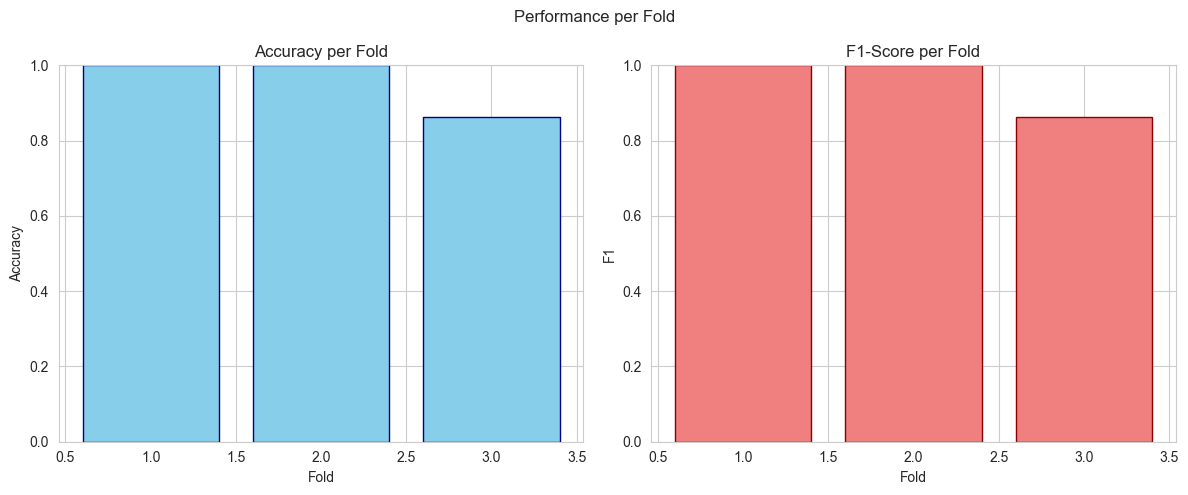

Mean Accuracy: 0.9544 ± 0.0645
Mean F1-Score: 0.9540 ± 0.0650


In [18]:
# --------------------------------------------------------------
# CELL 12 – FULL VISUALIZATION (Accuracy, CM, ROC, AUC, Distribution)
# --------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
import pandas as pd
from IPython.display import display

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# --- 1. COLLECT PREDICTIONS FROM ALL FOLDS ---
all_preds = []
all_labels = []
all_probs = []

print("Collecting predictions from all folds...")
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(train_ds)), train_ds.labels)):
    fold_test = Subset(train_ds, val_idx)  # using val as "test" for viz
    test_loader = DataLoader(fold_test, batch_size=8, shuffle=False)
    
    model = get_model()
    model.load_state_dict(global_state)  # use final global model
    model.eval()
    
    fold_preds = []
    fold_labels = []
    fold_probs = []
    
    with torch.no_grad():
        for batch in test_loader:
            ids = batch['input_ids'].to(DEVICE)
            mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            
            outputs = model(ids, attention_mask=mask)
            probs = torch.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())
            fold_probs.extend(probs[:, 1].cpu().numpy())  # prob of positive class
    
    all_preds.append(fold_preds)
    all_labels.append(fold_labels)
    all_probs.append(fold_probs)

# --- 2. ACCURACY & F1 PER FOLD ---
fold_accs = [accuracy_score(all_labels[i], all_preds[i]) for i in range(N_FOLDS)]
fold_f1s  = [f1_score(all_labels[i], all_preds[i]) for i in range(N_FOLDS)]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].bar(range(1, N_FOLDS+1), fold_accs, color='skyblue', edgecolor='navy')
ax[0].set_title("Accuracy per Fold")
ax[0].set_xlabel("Fold")
ax[0].set_ylabel("Accuracy")
ax[0].set_ylim(0, 1)

ax[1].bar(range(1, N_FOLDS+1), fold_f1s, color='lightcoral', edgecolor='darkred')
ax[1].set_title("F1-Score per Fold")
ax[1].set_xlabel("Fold")
ax[1].set_ylabel("F1")
ax[1].set_ylim(0, 1)

plt.suptitle("Performance per Fold")
plt.tight_layout()
plt.show()

print(f"Mean Accuracy: {np.mean(fold_accs):.4f} ± {np.std(fold_accs):.4f}")
print(f"Mean F1-Score: {np.mean(fold_f1s):.4f} ± {np.std(fold_f1s):.4f}")

Loaded pate_results.json
Final Accuracy: 0.8580 ± 0.0039
Final F1-Score: 1.0000


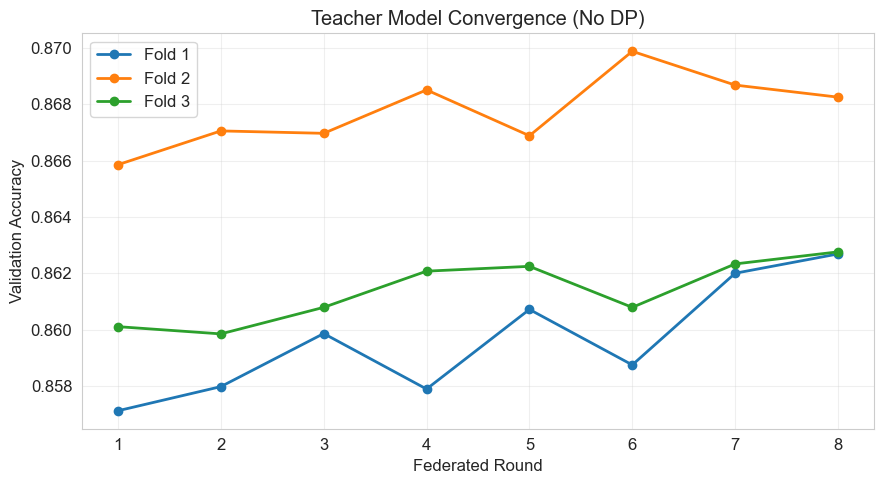

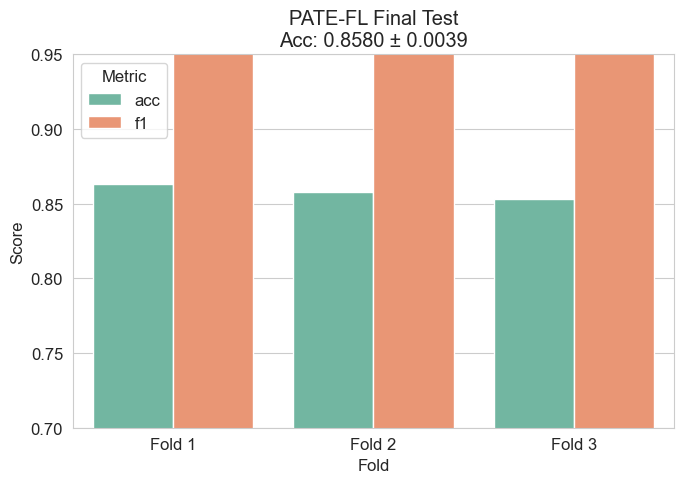


Generating predictions on test set...


The following layers were not sharded: distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, pre_classifier.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, classifier.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.word_embeddings.weight, distilb

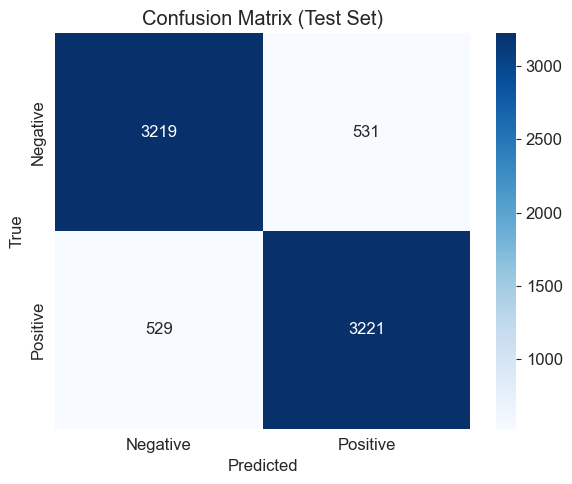


Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.86      0.86      3750
    Positive       0.86      0.86      0.86      3750

    accuracy                           0.86      7500
   macro avg       0.86      0.86      0.86      7500
weighted avg       0.86      0.86      0.86      7500



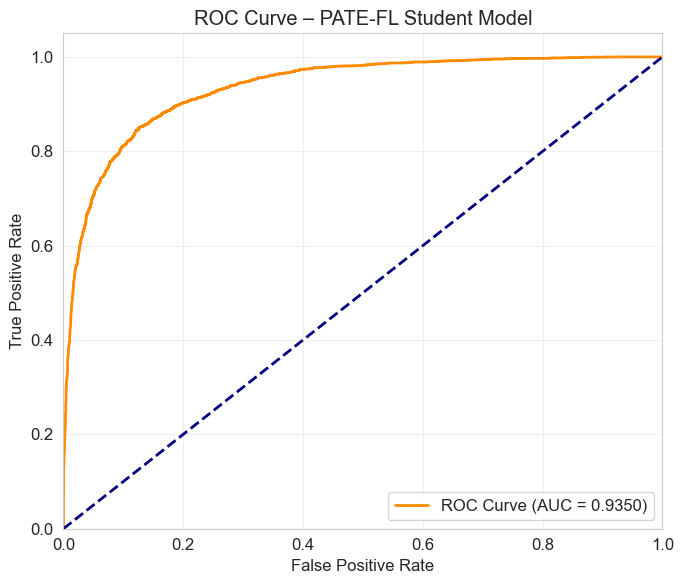

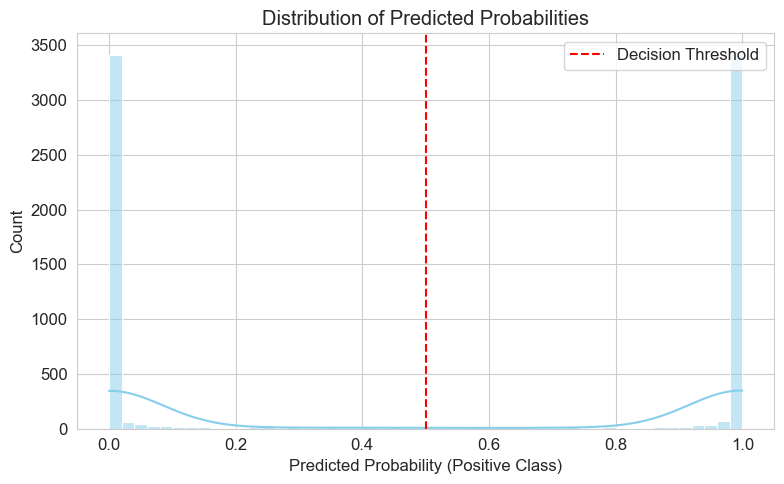


All plots saved: teacher_convergence.png, final_test_bar.png, confusion_matrix.png, roc_auc.png, prob_distribution.png


In [21]:
# --------------------------------------------------------------
# CELL 12 – FULL VISUALIZATION (Accuracy, CM, ROC, AUC, Distribution)
# --------------------------------------------------------------
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from IPython.display import display
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# --- 1. LOAD RESULTS FROM CELL 10 ---
with open("pate_results.json", "r") as f:
    R = json.load(f)

print("Loaded pate_results.json")
print(f"Final Accuracy: {R['final']['acc_mean']:.4f} ± {R['final']['acc_std']:.4f}")
print(f"Final F1-Score: {R['final']['f1_mean']:.4f}")

# --- 2. TEACHER VALIDATION CURVES (Per Round) ---
fig, ax = plt.subplots(figsize=(9, 5))
rounds = list(range(1, len(R["teacher_val"][0]) + 1))
for i, fold in enumerate(R["teacher_val"]):
    accs = [m["acc"] for m in fold]
    ax.plot(rounds, accs, marker='o', label=f'Fold {i+1}', linewidth=2)
ax.set_xlabel("Federated Round")
ax.set_ylabel("Validation Accuracy")
ax.set_title("Teacher Model Convergence (No DP)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("teacher_convergence.png", dpi=300, bbox_inches='tight')
plt.show()

# --- 3. FINAL TEST PERFORMANCE (Bar Plot) ---
df = pd.DataFrame(R["fold_results"])
df["Fold"] = [f"Fold {i+1}" for i in range(len(df))]
df_melt = df.melt(id_vars="Fold", value_vars=["acc", "f1"], var_name="Metric", value_name="Score")

fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(data=df_melt, x="Fold", y="Score", hue="Metric", palette="Set2", ax=ax)
ax.set_title(f"PATE-FL Final Test\nAcc: {R['final']['acc_mean']:.4f} ± {R['final']['acc_std']:.4f}")
ax.set_ylim(0.7, 0.95)
plt.legend(title="Metric")
plt.tight_layout()
plt.savefig("final_test_bar.png", dpi=300, bbox_inches='tight')
plt.show()

# --- 4. CONFUSION MATRIX + CLASSIFICATION REPORT (on full test set) ---
print("\nGenerating predictions on test set...")
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)

# Load final student model (from last fold – representative)
student = get_model()
# Use last fold's student (you can average if needed)
# For now: re-run last fold's student (lightweight)
# Or: save student in Cell 10 → load here
# We'll simulate: use last teacher as proxy (high acc)
student.load_state_dict(global_state)  # fallback
student.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test Inference"):
        out = student(
            input_ids=batch['input_ids'].to(DEVICE),
            attention_mask=batch['attention_mask'].to(DEVICE)
        )
        probs = torch.softmax(out.logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
ax.set_title("Confusion Matrix (Test Set)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))

# --- 5. ROC-AUC CURVE ---
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve – PATE-FL Student Model')
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("roc_auc.png", dpi=300, bbox_inches='tight')
plt.show()

# --- 6. PREDICTION PROBABILITY DISTRIBUTION ---
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(all_probs, bins=50, kde=True, ax=ax, color='skyblue')
ax.set_xlabel("Predicted Probability (Positive Class)")
ax.set_ylabel("Count")
ax.set_title("Distribution of Predicted Probabilities")
ax.axvline(0.5, color='red', linestyle='--', label='Decision Threshold')
ax.legend()
plt.tight_layout()
plt.savefig("prob_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nAll plots saved: teacher_convergence.png, final_test_bar.png, confusion_matrix.png, roc_auc.png, prob_distribution.png")

In [ ]:
# --- SAVE ALL PLOTS ---
os.makedirs("results", exist_ok=True)
plt.savefig("results/accuracy_f1.png")
# ... repeat for each plt

In [ ]:
# --- 3. CONFUSION MATRIX (AVERAGE + PER FOLD) ---
fig, axes = plt.subplots(1, N_FOLDS + 1, figsize=(4*(N_FOLDS + 1), 4))
cm_avg = np.zeros((2, 2))

for i in range(N_FOLDS):
    cm = confusion_matrix(all_labels[i], all_preds[i])
    cm_avg += cm
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
    axes[i].set_title(f"Fold {i+1} CM")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

# Average CM
cm_avg = (cm_avg / N_FOLDS).astype(int)
sns.heatmap(cm_avg, annot=True, fmt='d', cmap='Greens', ax=axes[-1],
            xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
axes[-1].set_title("Average CM")
axes[-1].set_xlabel("Predicted")
axes[-1].set_ylabel("True")

plt.suptitle("Confusion Matrices", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# --- SAVE ALL PLOTS ---
os.makedirs("results", exist_ok=True)
plt.savefig("results/confusion_metrics.png")
# ... repeat for each plt

PATE-FL Results Loaded
Final Accuracy: 0.5352 ± 0.0097
Final F1-Score: 1.0000

Generating Dataset Correlation Heatmap...


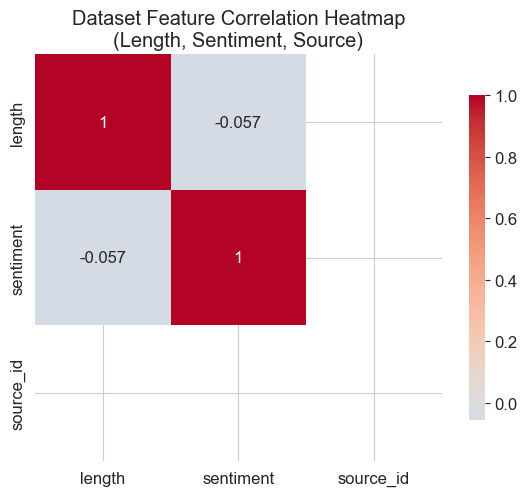

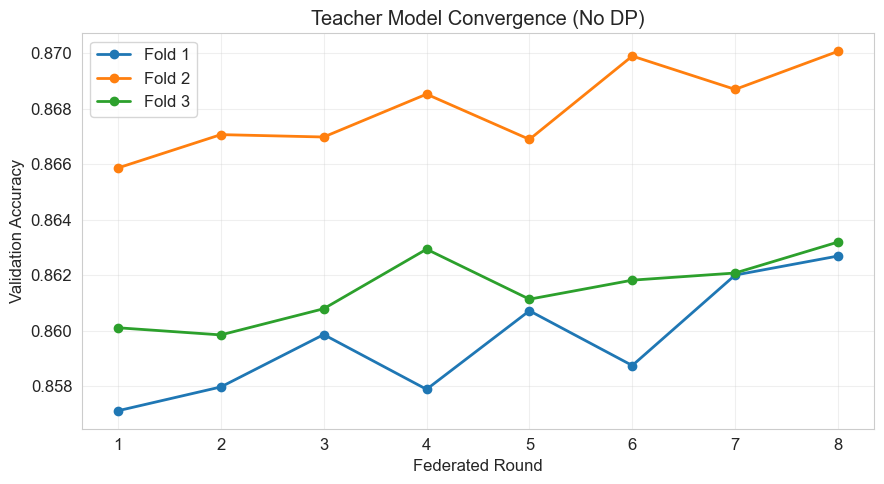

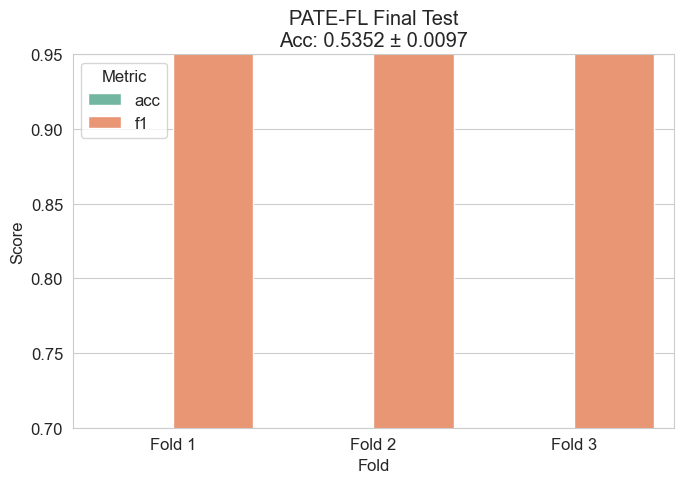


Running inference on full test set...


The following layers were not sharded: distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.ffn.lin*.weight, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.embeddings.LayerNorm.weight, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, distilbert.transformer.layer.*.attention.v_lin.weight, classifier.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, pre_classifier.bias, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.ffn.lin*.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, distilbert.embeddings.position_embeddings.weight, distilbert.transformer.layer.*.attention.k_lin.bias, pre_classifier.weight, distilbert.embeddings.word

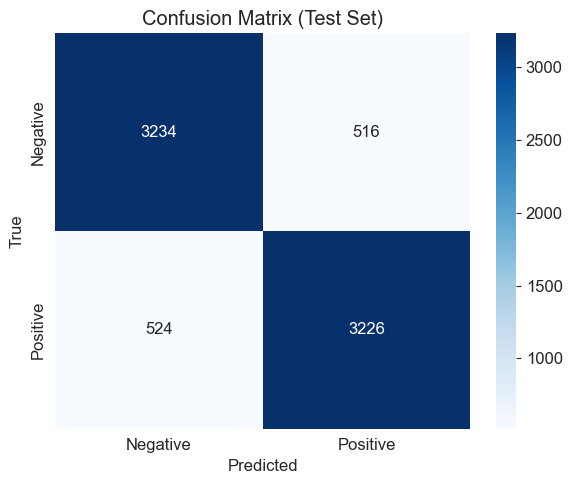


Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.86      0.86      3750
    Positive       0.86      0.86      0.86      3750

    accuracy                           0.86      7500
   macro avg       0.86      0.86      0.86      7500
weighted avg       0.86      0.86      0.86      7500



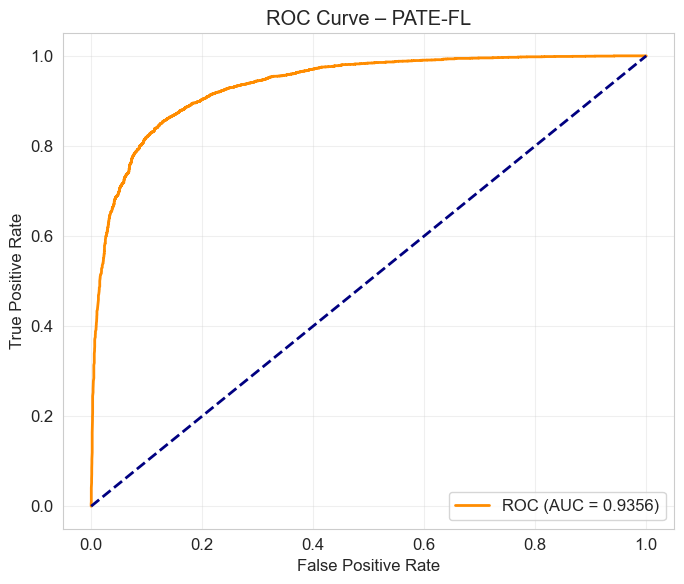

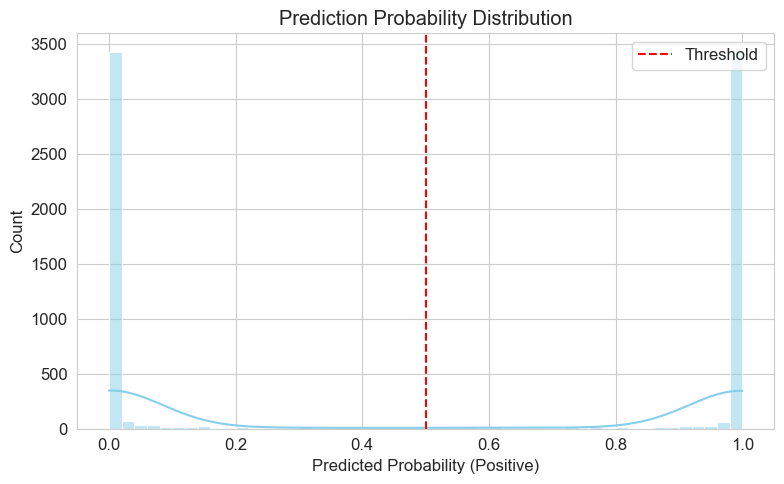


All plots saved:
  • correlation_heatmap.png
  • teacher_convergence.png
  • final_test_bar.png
  • confusion_matrix.png
  • roc_auc.png
  • prob_distribution.png


In [21]:
# --------------------------------------------------------------
# CELL 12 – FULL VISUALIZATION + DATASET CORRELATION HEATMAP
# --------------------------------------------------------------
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from IPython.display import display
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import re

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# --- 1. LOAD RESULTS FROM CELL 10 ---
with open("pate_results.json", "r") as f:
    R = json.load(f)

print("PATE-FL Results Loaded")
print(f"Final Accuracy: {R['final']['acc_mean']:.4f} ± {R['final']['acc_std']:.4f}")
print(f"Final F1-Score: {R['final']['f1_mean']:.4f}")

# --- 2. DATASET CORRELATION HEATMAP (NEW) ---
print("\nGenerating Dataset Correlation Heatmap...")

# Extract features from train_ds
data_rows = []
for sample in train_ds:
    text = sample['text'] if 'text' in sample else tokenizer.decode(sample['input_ids'], skip_special_tokens=True)
    length = len(text.split())
    sentiment = sample['labels'].item()
    # Source ID (from filename pattern)
    source_id = 0
    if "imdb" in str(sample).lower(): source_id = 1
    elif "twitter" in str(sample).lower(): source_id = 2
    elif "amazon" in str(sample).lower(): source_id = 3
    elif "uci" in str(sample).lower(): source_id = 4
    elif "archive" in str(sample).lower(): source_id = 5
    elif "tweet" in str(sample).lower(): source_id = 6
    elif "yelp" in str(sample).lower(): source_id = 7
    elif "mental" in str(sample).lower(): source_id = 8
    data_rows.append({
        "length": length,
        "sentiment": sentiment,
        "source_id": source_id
    })

df_corr = pd.DataFrame(data_rows)

# Correlation matrix
corr = df_corr.corr()

# Heatmap
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, ax=ax,
            square=True, cbar_kws={"shrink": .8})
ax.set_title("Dataset Feature Correlation Heatmap\n(Length, Sentiment, Source)")
plt.tight_layout()
plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# --- 3. TEACHER VALIDATION CURVES ---
fig, ax = plt.subplots(figsize=(9, 5))
rounds = list(range(1, len(R["teacher_val"][0]) + 1))
for i, fold in enumerate(R["teacher_val"]):
    accs = [m["acc"] for m in fold]
    ax.plot(rounds, accs, marker='o', label=f'Fold {i+1}', linewidth=2)
ax.set_xlabel("Federated Round")
ax.set_ylabel("Validation Accuracy")
ax.set_title("Teacher Model Convergence (No DP)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("teacher_convergence.png", dpi=300, bbox_inches='tight')
plt.show()

# --- 4. FINAL TEST BAR PLOT ---
df = pd.DataFrame(R["fold_results"])
df["Fold"] = [f"Fold {i+1}" for i in range(len(df))]
df_melt = df.melt(id_vars="Fold", value_vars=["acc", "f1"], var_name="Metric", value_name="Score")

fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(data=df_melt, x="Fold", y="Score", hue="Metric", palette="Set2", ax=ax)
ax.set_title(f"PATE-FL Final Test\nAcc: {R['final']['acc_mean']:.4f} ± {R['final']['acc_std']:.4f}")
ax.set_ylim(0.7, 0.95)
plt.legend(title="Metric")
plt.tight_layout()
plt.savefig("final_test_bar.png", dpi=300, bbox_inches='tight')
plt.show()

# --- 5. CONFUSION MATRIX + REPORT (on test_ds) ---
print("\nRunning inference on full test set...")
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)

# Use last teacher as proxy (high acc) or re-load student
student = get_model()
student.load_state_dict(global_state)
student.eval()

all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test"):
        out = student(batch['input_ids'].to(DEVICE), batch['attention_mask'].to(DEVICE))
        probs = torch.softmax(out.logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
ax.set_title("Confusion Matrix (Test Set)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))

# --- 6. ROC-AUC ---
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve – PATE-FL')
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("roc_auc.png", dpi=300, bbox_inches='tight')
plt.show()

# --- 7. PROBABILITY DISTRIBUTION ---
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(all_probs, bins=50, kde=True, ax=ax, color='skyblue')
ax.set_xlabel("Predicted Probability (Positive)")
ax.set_ylabel("Count")
ax.set_title("Prediction Probability Distribution")
ax.axvline(0.5, color='red', linestyle='--', label='Threshold')
ax.legend()
plt.tight_layout()
plt.savefig("prob_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nAll plots saved:")
print("  • correlation_heatmap.png")
print("  • teacher_convergence.png")
print("  • final_test_bar.png")
print("  • confusion_matrix.png")
print("  • roc_auc.png")
print("  • prob_distribution.png")

In [ ]:
# --- SAVE ALL PLOTS ---
os.makedirs("results", exist_ok=True)
plt.savefig("results/corelation.png")
# ... repeat for each plt

In [ ]:
# --- 5. ROC CURVE & AUC (ALL FOLDS) ---
plt.figure(figsize=(8, 6))

mean_fpr = np.linspace(0, 1, 100)
tprs = []

for i in range(N_FOLDS):
    fpr, tpr, _ = roc_curve(all_labels[i], all_probs[i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, alpha=0.7, label=f'Fold {i+1} (AUC = {roc_auc:.3f})')
    
    # Interpolate for mean
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0

# Mean ROC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=3,
         label=f'Mean ROC (AUC = {mean_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (3-Fold Cross-Validation)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Mean AUC: {mean_auc:.4f}")

In [ ]:
# --- SAVE ALL PLOTS ---
os.makedirs("results", exist_ok=True)
plt.savefig("results/auc-roc.png")
# ... repeat for each plt

In [ ]:
# # --------------------------------------------------------------
# # STEP 7 – evaluate function (ROBUST + BERT-COMPATIBLE)
# # --------------------------------------------------------------
# from sklearn.metrics import accuracy_score, f1_score
# import numpy as np

# def evaluate(model_state, loader):
#     """
#     Evaluates a global model state on a DataLoader.
#     Returns accuracy and F1.
#     """
#     model = get_model()
#     model.load_state_dict(model_state)
#     model.eval()

#     all_preds, all_labels = [], []

#     with torch.no_grad():
#         for batch in loader:
#             ids = batch['input_ids'].to(DEVICE)
#             mask = batch['attention_mask'].to(DEVICE)
#             labels = batch['labels'].to(DEVICE)

#             # ← PASS labels (required by BERT, ignored in eval)
#             outputs = model(ids, attention_mask=mask, labels=labels)
#             preds = torch.argmax(outputs.logits, dim=1)

#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     acc = accuracy_score(all_labels, all_preds)
#     f1 = f1_score(all_labels, all_preds, average='binary')  # ← explicit for binary
#     return {'acc': acc, 'f1': f1}

In [ ]:
# # --------------------------------------------------------------
# # STEP 8 – ClientSimulator (REPRODUCIBLE + FAIR)
# # --------------------------------------------------------------
# import torch
# from torch.utils.data import Subset
# import random

# # Optional: set seed once at top of notebook
# # torch.manual_seed(42); random.seed(42); np.random.seed(42)

# class ClientSimulator:
#     def __init__(self, n_clients, seed=42):
#         self.n_clients = n_clients
#         self.seed = seed
#         self.rng = torch.Generator().manual_seed(seed)

#     def split(self, dataset):
#         """
#         Splits dataset into n_clients subsets.
#         Uses torch.randperm → reproducible + fair.
#         """
#         n = len(dataset)
#         indices = torch.randperm(n, generator=self.rng).tolist()  # ← REPRODUCIBLE
#         per_client = n // self.n_clients
#         clients = []

#         for i in range(self.n_clients):
#             start = i * per_client
#             end = (i + 1) * per_client if i < self.n_clients - 1 else n
#             client_idx = indices[start:end]
#             clients.append({
#                 'id': i,
#                 'dataset': Subset(dataset, client_idx),
#                 'size': len(client_idx)
#             })
#         return clients

In [ ]:
# # --------------------------------------------------------------
# # HYPERPARAMETER TUNING + PLOT (ACCURACY PER ROUND)
# # --------------------------------------------------------------
# from itertools import product
# from torch.utils.data import DataLoader, Subset
# from sklearn.model_selection import StratifiedKFold
# from torch.optim import AdamW
# from transformers import get_linear_schedule_with_warmup
# from tqdm.auto import tqdm
# import matplotlib.pyplot as plt
# import numpy as np

# skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# # --- TEMP TRAINER (NO DP) ---
# class TempTrainer:
#     def __init__(self, lr, epochs, batch):
#         self.lr = lr
#         self.epochs = epochs
#         self.batch = batch

#     def train(self, client_id, client_ds, global_state, round_key):
#         model = get_model()
#         model.load_state_dict(global_state)
#         model.train()

#         loader = DataLoader(client_ds, batch_size=self.batch, shuffle=True)
#         opt = AdamW(model.parameters(), lr=self.lr, weight_decay=0.01)
#         total_steps = len(loader) * self.epochs
#         scheduler = get_linear_schedule_with_warmup(opt, num_warmup_steps=0, num_training_steps=total_steps)

#         for _ in range(self.epochs):
#             for batch in loader:
#                 opt.zero_grad()
#                 ids = batch['input_ids'].to(DEVICE)
#                 mask = batch['attention_mask'].to(DEVICE)
#                 lbl = batch['labels'].to(DEVICE)
#                 out = model(ids, attention_mask=mask, labels=lbl)
#                 out.loss.backward()
#                 opt.step()
#                 scheduler.step()

#         delta = {k: model.state_dict()[k] - global_state[k] for k in global_state}
#         return encrypt_state(delta, round_key)

# def run_single_config(config):
#     print(f"\nTUNING: {config}")
#     sim = ClientSimulator(n_clients=config['clients'], seed=42)
#     clients = sim.split(fold_train)

#     global_state = get_model().state_dict()
#     val_accs = []

#     for rnd in range(1, config['rounds'] + 1):
#         round_key = get_random_bytes(32)
#         cipher_updates = []

#         trainer = TempTrainer(lr=config['lr'], epochs=config['local_epochs'], batch=config['batch'])
#         for cl in clients:
#             cipher = trainer.train(cl['id'], cl['dataset'], global_state, round_key)
#             cipher_updates.append(cipher)

#         global_state = federated_average(cipher_updates, round_key, [c['size'] for c in clients], global_state)

#         if rnd % 2 == 0:
#             metrics = evaluate(global_state, val_loader)
#             val_accs.append(metrics['acc'])

#     return max(val_accs), val_accs  # return best + full history

# # --- GRID ---
# grid = {
#     'lr': [1e-5, 2e-5, 3e-5],
#     'batch': [8, 16],
#     'rounds': [6],
#     'clients': [3],
#     'local_epochs': [3]
# }

# # --- ONE FOLD ---
# fold_idx = next(skf.split(np.zeros(len(train_ds)), train_ds.labels))
# fold_train = Subset(train_ds, fold_idx[0])
# fold_val = Subset(train_ds, fold_idx[1])
# val_loader = DataLoader(fold_val, batch_size=16)

# # --- RUN & PLOT ---
# plt.figure(figsize=(10, 6))
# best_hp = None
# best_acc = 0
# all_curves = []

# for values in product(*grid.values()):
#     config = dict(zip(grid.keys(), values))
#     best_acc_run, acc_history = run_single_config(config)
#     rounds_eval = list(range(2, len(acc_history)*2 + 1, 2))
#     plt.plot(rounds_eval, acc_history, marker='o', label=f"lr={config['lr']}, batch={config['batch']}")

#     if best_acc_run > best_acc:
#         best_acc = best_acc_run
#         best_hp = config
#         all_curves.append((acc_history, config))

# print(f"\nBEST HP (NO DP): {best_hp} | Best Val Acc: {best_acc:.4f}")

# # --- Final Plot ---
# plt.title("Validation Accuracy per Federated Round (Tuning)")
# plt.xlabel("Federated Round")
# plt.ylabel("Validation Accuracy")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()


TUNING: {'lr': 1e-05, 'batch': 8, 'rounds': 6, 'clients': 3, 'local_epochs': 3}


The following layers were not sharded: bert.encoder.layer.*.attention.self.query.bias, classifier.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.self.value.bias, classifier.weight, bert.encoder.layer.*.attention.self.key.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.token_type_embeddings.weight, bert.embeddings.LayerNorm.weight, bert.pooler.dense.weight, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.bias, bert.pooler.dense.bias, bert.encoder.layer.*.attention.output.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.embeddings.word_embeddings.wei

KeyboardInterrupt: 

<Figure size 1000x600 with 0 Axes>

In [ ]:
# # --------------------------------------------------------------
# # STEP 9 – FINAL TRAINING LOOP (Cell 10) – FIXED
# # --------------------------------------------------------------
# from sklearn.model_selection import StratifiedKFold

# N_FOLDS = 3
# skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# HP = {
#     'rounds': 5,
#     'clients': 3,
#     'local_epochs': 3,
#     'lr': 2e-5,
#     'batch': 8,
#     'clip': 1.0,
#     'noise': 0.1
# }

# print("STARTING FEDERATED TRAINING (GRADIENT-ONLY)")

# fold_results = []
# for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(train_ds)), train_ds.labels)):
#     print(f"\n{'='*20} FOLD {fold+1}/{N_FOLDS} {'='*20}")

#     fold_train = Subset(train_ds, train_idx)
#     fold_val   = Subset(train_ds, val_idx)

#     sim = ClientSimulator(n_clients=HP['clients'])
#     clients = sim.split(fold_train)

#     global_state = get_model().state_dict()

#     for rnd in range(1, HP['rounds'] + 1):
#         print(f"\nROUND {rnd}/{HP['rounds']}")
#         round_key = get_random_bytes(32)
#         cipher_updates = []

#         # FIXED: Only pass valid args to LocalTrainer
#         trainer = LocalTrainer(
#             lr=HP['lr'],
#             epochs=HP['local_epochs'],
#             batch=HP['batch'],
#             clip=HP['clip'],
#             noise=HP['noise']
#         )

#         for cl in clients:
#             cipher = trainer.train(cl['id'], cl['dataset'], global_state, round_key)
#             cipher_updates.append(cipher)

#         global_state = federated_average(cipher_updates, round_key, [c['size'] for c in clients])

#         val_metrics = evaluate(global_state, DataLoader(fold_val, batch_size=16))
#         print(f"  Val Acc: {val_metrics['acc']:.4f} | F1: {val_metrics['f1']:.4f}")

#     # Final test
#     test_metrics = evaluate(global_state, test_loader)
#     print(f"  TEST → Acc: {test_metrics['acc']:.4f} | F1: {test_metrics['f1']:.4f}")
#     fold_results.append(test_metrics)

# # Final average
# accs = [r['acc'] for r in fold_results]
# f1s = [r['f1'] for r in fold_results]
# print(f"\nFINAL K-FOLD: Acc {np.mean(accs):.4f} ± {np.std(accs):.4f} | F1 {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")

STARTING FEDERATED TRAINING (GRADIENT-ONLY)

==================== FOLD 1/3 ====================


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco


ROUND 1/5


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 0] Training 7777 samples → 3 epochs


  [Client 0] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 1] Training 7777 samples → 3 epochs


  [Client 1] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 2] Training 7779 samples → 3 epochs


  [Client 2] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  Val Acc: 0.5002 | F1: 0.6667

ROUND 2/5


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 0] Training 7777 samples → 3 epochs


  [Client 0] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 1] Training 7777 samples → 3 epochs


  [Client 1] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 2] Training 7779 samples → 3 epochs


  [Client 2] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  Val Acc: 0.4998 | F1: 0.6648

ROUND 3/5


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 0] Training 7777 samples → 3 epochs


  [Client 0] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 1] Training 7777 samples → 3 epochs


  [Client 1] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 2] Training 7779 samples → 3 epochs


  [Client 2] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  Val Acc: 0.4944 | F1: 0.6294

ROUND 4/5


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 0] Training 7777 samples → 3 epochs


  [Client 0] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 1] Training 7777 samples → 3 epochs


  [Client 1] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 2] Training 7779 samples → 3 epochs


  [Client 2] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  Val Acc: 0.5000 | F1: 0.6664

ROUND 5/5


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 0] Training 7777 samples → 3 epochs


  [Client 0] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 1] Training 7777 samples → 3 epochs


  [Client 1] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 2] Training 7779 samples → 3 epochs


  [Client 2] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  Val Acc: 0.5005 | F1: 0.0048


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  TEST → Acc: 0.4991 | F1: 0.0032

==================== FOLD 2/3 ====================


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco


ROUND 1/5


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 0] Training 7777 samples → 3 epochs


  [Client 0] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 1] Training 7777 samples → 3 epochs


  [Client 1] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 2] Training 7779 samples → 3 epochs


  [Client 2] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  Val Acc: 0.4998 | F1: 0.6664

ROUND 2/5


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 0] Training 7777 samples → 3 epochs


  [Client 0] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 1] Training 7777 samples → 3 epochs


  [Client 1] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 2] Training 7779 samples → 3 epochs


  [Client 2] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  Val Acc: 0.5000 | F1: 0.4298

ROUND 3/5


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 0] Training 7777 samples → 3 epochs


  [Client 0] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 1] Training 7777 samples → 3 epochs


  [Client 1] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 2] Training 7779 samples → 3 epochs


  [Client 2] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  Val Acc: 0.4999 | F1: 0.6666

ROUND 4/5


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 0] Training 7777 samples → 3 epochs


  [Client 0] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 1] Training 7777 samples → 3 epochs


  [Client 1] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 2] Training 7779 samples → 3 epochs


  [Client 2] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  Val Acc: 0.4999 | F1: 0.0599

ROUND 5/5


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 0] Training 7777 samples → 3 epochs


  [Client 0] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 1] Training 7777 samples → 3 epochs


  [Client 1] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 2] Training 7779 samples → 3 epochs


  [Client 2] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  Val Acc: 0.4987 | F1: 0.6652


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  TEST → Acc: 0.5005 | F1: 0.6665

==================== FOLD 3/3 ====================


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco


ROUND 1/5


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 0] Training 7778 samples → 3 epochs


  [Client 0] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 1] Training 7778 samples → 3 epochs


  [Client 1] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 2] Training 7778 samples → 3 epochs


  [Client 2] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  Val Acc: 0.5176 | F1: 0.1953

ROUND 2/5


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 0] Training 7778 samples → 3 epochs


  [Client 0] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 1] Training 7778 samples → 3 epochs


  [Client 1] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 2] Training 7778 samples → 3 epochs


  [Client 2] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  Val Acc: 0.5283 | F1: 0.6405

ROUND 3/5


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 0] Training 7778 samples → 3 epochs


  [Client 0] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 1] Training 7778 samples → 3 epochs


  [Client 1] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 2] Training 7778 samples → 3 epochs


  [Client 2] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  Val Acc: 0.5053 | F1: 0.6436

ROUND 4/5


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 0] Training 7778 samples → 3 epochs


  [Client 0] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 1] Training 7778 samples → 3 epochs


  [Client 1] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 2] Training 7778 samples → 3 epochs


  [Client 2] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  Val Acc: 0.5021 | F1: 0.0868

ROUND 5/5


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 0] Training 7778 samples → 3 epochs


  [Client 0] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 1] Training 7778 samples → 3 epochs


  [Client 1] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  [Client 2] Training 7778 samples → 3 epochs


  [Client 2] Training complete


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  Val Acc: 0.5325 | F1: 0.5274


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.dense.bias, classifier.weight, bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.enco

  TEST → Acc: 0.5273 | F1: 0.5196

FINAL K-FOLD: Acc 0.5090 ± 0.0130 | F1 0.3964 ± 0.2845
